In [1]:
# Callback to ramp lam_phys in model.loss via attribute; implement as example where model has attribute lam_phys
import tensorflow as tf

class LambdaRamp(tf.keras.callbacks.Callback):
    def __init__(self, start_epoch, end_epoch, final_value):
        self.start = start_epoch
        self.end = end_epoch
        self.final = final_value
    def on_epoch_begin(self, epoch, logs=None):
        if epoch < self.start:
            val = 0.0
        elif epoch >= self.end:
            val = self.final
        else:
            val = (epoch - self.start)/(self.end - self.start) * self.final
        # store in model for your physics loss lambda to read
        setattr(self.model, "lam_phys_current", float(val))
        # optional logging
        print(f"Epoch {epoch}: lam_phys_current={val:.6f}")

# Modify physics loss lambda in compile to read model.lam_phys_current; easiest: implement phys loss using closure that reads model attribute
# Example usage:
ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
# pass ramp_cb to fit callbacks


          t  Ubar  Mubar       Density          Phi2        Energy  Iters  \
0       1.0   0.0   -5.0  1.048576e-14  1.048576e-14  2.097152e-13      8   
1       1.0   0.0   -4.9  1.508449e-14  1.508449e-14  2.882646e-13      8   
2       1.0   0.0   -4.8  2.186340e-14  2.186340e-14  3.987884e-13      8   
3       1.0   0.0   -4.7  3.193733e-14  3.193733e-14  5.553901e-13      8   
4       1.0   0.0   -4.6  4.703477e-14  4.703477e-14  7.788958e-13      8   
...     ...   ...    ...           ...           ...           ...    ...   
163396  1.0  25.0   59.6  3.000000e+00  8.530376e-13 -1.038000e+02     21   
163397  1.0  25.0   59.7  3.000000e+00  7.586920e-13 -1.041000e+02     21   
163398  1.0  25.0   59.8  3.000000e+00  6.791729e-13 -1.044000e+02     21   
163399  1.0  25.0   59.9  3.000000e+00  6.119027e-13 -1.047000e+02     21   
163400  1.0  25.0   60.0  3.000000e+00  5.548081e-13 -1.050000e+02     21   

        Phase  
0           0  
1           0  
2           0  
3          

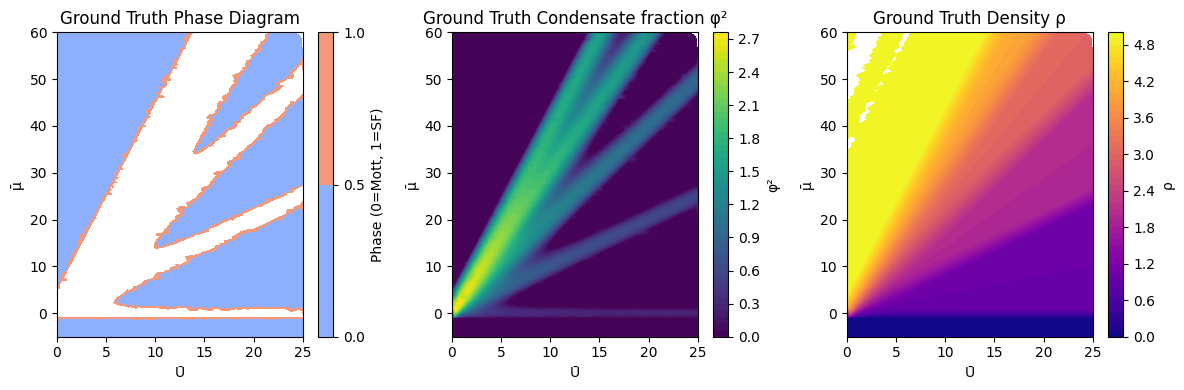

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from pytorch_tabnet.tab_model import TabNetClassifier


# Label: 1 = Superfluid, 0 = Mott
def label_phase(rho, phi2, tol_rho=1e-3, tol_phi=1e-6):
    """
    Classify phase:
    - Mott insulator if (rho ~ integer) and (phi^2 ~ 0).
    - Superfluid otherwise.
    """
    is_integer_rho = np.isclose(rho, np.round(rho), atol=tol_rho)
    is_zero_phi = phi2 < tol_phi
    
    if is_integer_rho and is_zero_phi:
        return 0  # Mott
    else:
        return 1  # Superfluid

        
# # ---------- 1) Load and label ----------
# df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# # Label: 1 = Superfluid, 0 = Mott
# df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

# # Features and target: **only** Ubar, Mubar
# X = df[["Ubar", "Mubar"]].copy()
# y = df["Phase"].copy()

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.25, random_state=42,
#     stratify=y
# )


# # Apply physics-based labeling
# df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)

# # Features and target: **only** Ubar, Mubar
# X = df[["Ubar", "Mubar"]].copy()
# y = df["Phase"].copy()

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.25, random_state=42,
#     stratify=y
# )

# ---------- 1) Load and label ----------
df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Apply physics-based labeling (optional, but consistent)
df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)




# --- pick deep MI (phi2 ≈ 0, density ~ integer) ---



df_MI = df[
    (df["Phi2"] < 1e-8) &
    (np.isclose(df["Density"], np.round(df["Density"]), atol=1e-3))
]

# --- pick deep SF (large phi2) ---
df_SF = df[df["Phi2"] > 1e-2]

# --- pick boundary (ambiguous region) ---
df_boundary = df[
    (df["Phi2"] > 1e-6) & (df["Phi2"] < 1e-2)
]

# ------------------------------
# Smart sampling strategy
# ------------------------------
# n_MI = min(2000, len(df_MI))             # cap deep MI
# n_SF = min(2000, len(df_SF))             # cap deep SF
# n_boundary = min(6000, len(df_boundary)) # oversample boundary

n_MI = min(5000, len(df_MI))
n_SF = min(5000, len(df_SF))
n_boundary = min(10000, len(df_boundary))


df_reduced = pd.concat([
    df_MI.sample(n_MI, random_state=42),
    df_SF.sample(n_SF, random_state=42),
    df_boundary.sample(n_boundary, random_state=42)
])
print(df)
df_reduced = df_reduced.reset_index(drop=True)
# Use reduced dataset
df = df_reduced.reset_index(drop=True)
print(df)


print("Reduced dataset summary:")
print(df_reduced["Phase"].value_counts())

# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")

# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()


         t  Ubar  Mubar       Density          Phi2        Energy  Iters  \
0      1.0  24.4   13.4  1.000000e+00  6.034134e-14 -1.340000e+01      9   
1      1.0  16.0   -1.1  8.624612e-11  8.624612e-11  9.487073e-12    101   
2      1.0  22.4    6.0  1.000000e+00  5.328648e-14 -6.000000e+00     10   
3      1.0  14.2   22.4  2.000000e+00  6.649626e-12 -3.060000e+01     37   
4      1.0  22.0    7.5  1.000000e+00  1.363996e-14 -7.500000e+00     10   
...    ...   ...    ...           ...           ...           ...    ...   
10679  1.0   3.6   -1.0  8.456767e-05  8.456471e-05  4.598585e-09   4589   
10680  1.0   5.3   26.2  4.999955e+00  2.254263e-04 -7.800000e+01   7465   
10681  1.0  10.9   17.5  2.000244e+00  2.100670e-03 -2.410000e+01   2451   
10682  1.0  16.3   -1.0  6.803388e-05  6.803021e-05  4.123775e-09   4118   
10683  1.0   5.1   25.4  4.999955e+00  2.261209e-04 -7.600000e+01   7477   

       Phase  
0          0  
1          0  
2          0  
3          0  
4          0

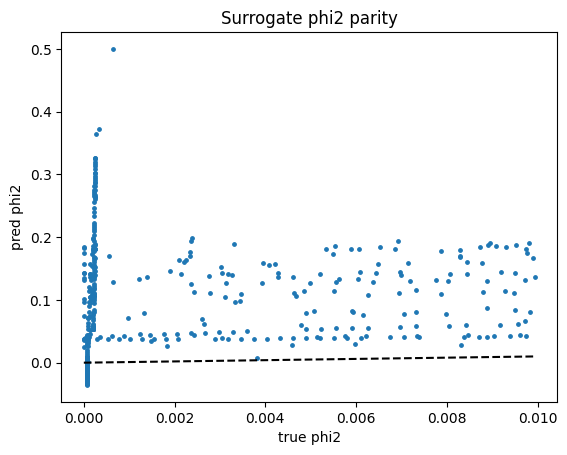


Epoch 0: lam_phys_current=0.000000
Epoch 1/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.6919 - phase_accuracy: 0.6106 - phase_loss: 0.6639 - phi2_loss: 0.5964 - phys_res_loss: 0.5572 - rho_loss: 1.8488 - val_loss: 1.9947 - val_phase_accuracy: 0.5958 - val_phase_loss: 0.7906 - val_phi2_loss: 0.4811 - val_phys_res_loss: 0.4065 - val_rho_loss: 0.2434 - learning_rate: 0.0010
Epoch 1: lam_phys_current=0.000000
Epoch 2/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3654 - phase_accuracy: 0.7671 - phase_loss: 0.5924 - phi2_loss: 0.3115 - phys_res_loss: 0.2949 - rho_loss: 0.1613 - val_loss: 1.3621 - val_phase_accuracy: 0.5964 - val_phase_loss: 0.7950 - val_phi2_loss: 0.2544 - val_phys_res_loss: 0.1826 - val_rho_loss: 0.1411 - learning_rate: 0.0010
Epoch 2: lam_phys_current=0.000000
Epoch 3/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9528 - phase_accuracy: 0.8048 - phase_loss: 0.5413 - phi2_loss: 0.1710 - phys_res_loss: 0.1514 - rho_loss: 0.0864 - val_loss: 1.1966 - val_

In [3]:
# --- 1) Load data ---
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# # Load dataset
# df = reduced_df

print(df)

# Features and targets
X = df[["Ubar","Mubar"]].values.astype(np.float32)
y = {
    "phase": df["Phase"].values.astype(np.float32),
    "phi2": df["Phi2"].values.astype(np.float32),
    "rho": df["Density"].values.astype(np.float32),
}

# --- 2) Train surrogate model ---
def build_surrogate(hidden=(128,64)):
    inp = keras.Input(shape=(2,))
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="relu")(x)
    out = layers.Dense(2, activation="linear")(x)   # [phi2, rho]
    m = keras.Model(inp, out)
    m.compile(optimizer="adam", loss="mse")
    return m

X_surr = df[["Ubar","Mubar"]].values.astype(np.float32)
y_surr = df[["Phi2","Density"]].values.astype(np.float32)

surrogate = build_surrogate()
surrogate.fit(
    X_surr, y_surr,
    epochs=200, batch_size=512,
    validation_split=0.15, verbose=1
)

# Surrogate validation
from sklearn.metrics import mean_squared_error, mean_absolute_error
X_val = X_surr[-500:]   # or better: shuffle and split properly
y_val = y_surr[-500:]
y_pred = surrogate.predict(X_val)
print("Surrogate MSE:", mean_squared_error(y_val, y_pred))
print("Surrogate MAE:", mean_absolute_error(y_val, y_pred))

# parity plot
import matplotlib.pyplot as plt
plt.scatter(y_val[:,0], y_pred[:,0], s=6); plt.xlabel("true phi2"); plt.ylabel("pred phi2"); plt.title("Surrogate phi2 parity")
plt.plot([y_val[:,0].min(), y_val[:,0].max()],[y_val[:,0].min(), y_val[:,0].max()], 'k--'); plt.show()


# Save & reload in new Keras format
surrogate.save("surrogate_phi_rho.keras")
surrogate = keras.models.load_model("surrogate_phi_rho.keras", compile=False)
surrogate.trainable = False   # freeze surrogate

# --- 3) PINN with surrogate residual ---
def make_pinn_with_surrogate(hidden=(128,64), lam_phase=1.0, lam_phys=1.0):
    inp = keras.Input(shape=(2,), name="input")   # [Ubar, Mubar]
    lam_phys_var = tf.Variable(lam_phys, trainable=False, dtype=tf.float32, name="lam_phys")
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="tanh")(x)

    phase_out = layers.Dense(1, activation="sigmoid", name="phase")(x)
    phi_out   = layers.Dense(1, activation="relu", name="phi2")(x)
    rho_out   = layers.Dense(1, activation="relu", name="rho")(x)

    # Physics residual via surrogate
    def phys_residual(inputs):
        UMb, phi_pred = inputs[0], inputs[1]
        s = surrogate(UMb)                  # surrogate predictions [phi2, rho]
        s_phi = tf.expand_dims(s[:, 0], -1) # only phi2
        return phi_pred - s_phi

    phys_out = layers.Lambda(
        lambda t: phys_residual([t[0], t[1]]),
        name="phys_res"
    )([inp, phi_out])

    model = keras.Model(inputs=inp, outputs=[phase_out, phi_out, rho_out, phys_out])

    losses = {
        "phase": "binary_crossentropy",
        "phi2": "mse",
        "rho": "mse",
        "phys_res": lambda y_true, y_pred: lam_phys_var * tf.reduce_mean(tf.square(y_pred))
    }
    loss_weights = {"phase": lam_phase, "phi2": 1.0, "rho": 1.0, "phys_res": 1.0}

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss=losses,
        loss_weights=loss_weights,
        metrics={"phase":"accuracy"}
    )
    model.lam_phys = lam_phys_var
    return model

pinn_surrogate = make_pinn_with_surrogate()

# --- 4) Train PINN ---
y_targets = {
    "phase": df["Phase"].values.reshape(-1,1).astype(np.float32),
    "phi2":  df["Phi2"].values.reshape(-1,1).astype(np.float32),
    "rho":   df["Density"].values.reshape(-1,1).astype(np.float32),
    "phys_res": np.zeros((len(df),1), dtype=np.float32)
}


def mc_predict(model, X, n=50):
    preds = []
    for _ in range(n):
        p = model(X, training=True)  # keep dropout active
        preds.append(p[0].numpy())   # phase output
    preds = np.stack(preds, axis=0)
    return preds.mean(0), preds.std(0)

    
ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
history = pinn_surrogate.fit(
    X, y_targets,
    batch_size=256,
    epochs=200,
    validation_split=0.15,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(patience=8, factor=0.5),ramp_cb
        # keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True)
    ]
)



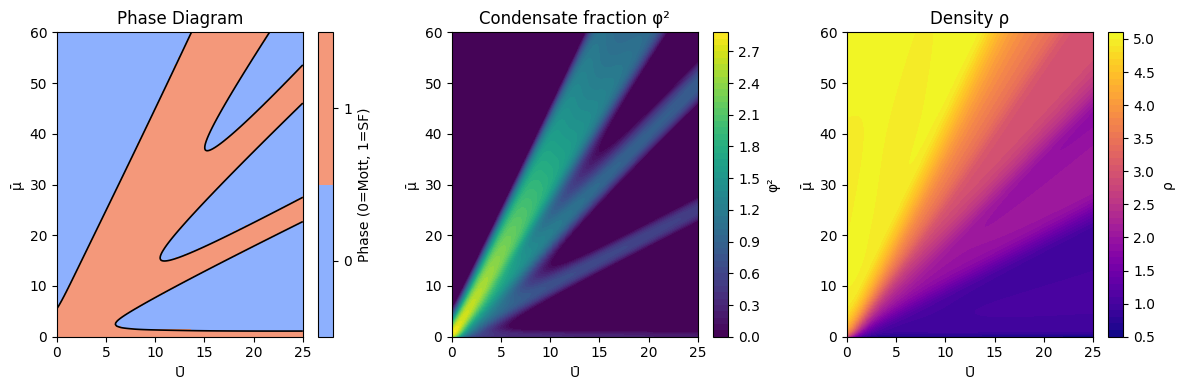

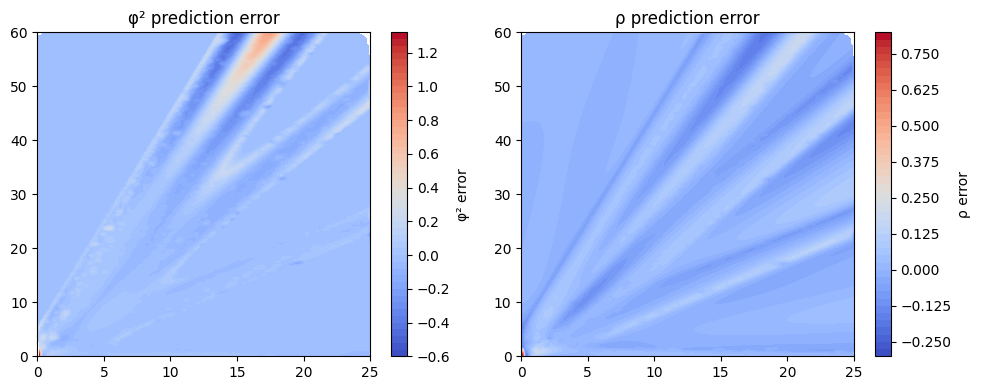

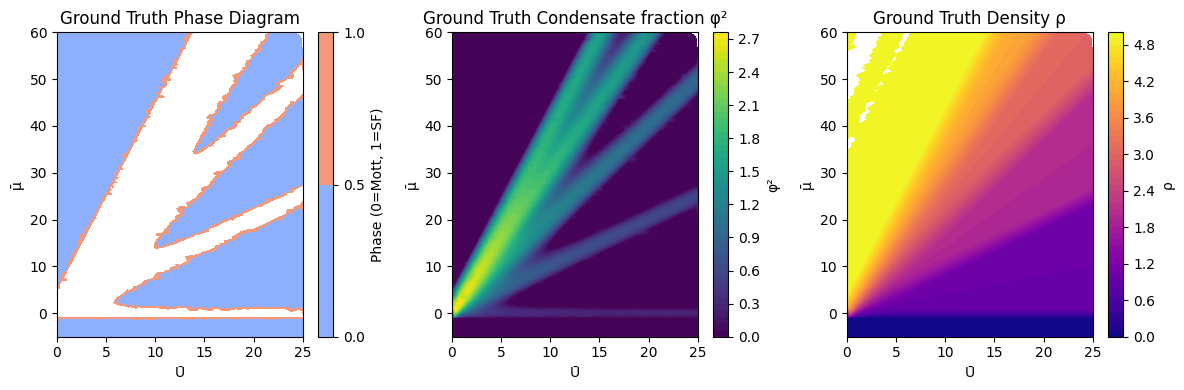


📊 Classification Report (Phase):
              precision    recall  f1-score   support

           0     0.9403    0.9896    0.9643      5000
           1     0.9904    0.9448    0.9670      5684

    accuracy                         0.9657     10684
   macro avg     0.9654    0.9672    0.9657     10684
weighted avg     0.9670    0.9657    0.9658     10684



C:\Users\DELL\AppData\Local\Temp\ipykernel_6640\2991935851.py:106: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_true_labels = df["Phase"].astype(int).ravel()


In [4]:
# --- 5) Phase diagram prediction ---
U_vals = np.linspace(0, 25, 200)   # Ū axis
mu_vals = np.linspace(0, 60, 200)  # μ̄ axis
UU, MU = np.meshgrid(U_vals, mu_vals)
X_grid = np.stack([UU.ravel(), MU.ravel()], axis=1).astype(np.float32)

# Predict → 4 outputs
y_pred_grid = pinn_surrogate.predict(X_grid, verbose=0)
phase_pred, phi2_pred, rho_pred, _ = y_pred_grid

phase_pred = phase_pred.reshape(UU.shape)
phi2_pred  = phi2_pred.reshape(UU.shape)
rho_pred   = rho_pred.reshape(UU.shape)
phase_pred_class = (phase_pred > 0.5).astype(int)

plt.figure(figsize=(12,4))

# --- Phase diagram ---
plt.subplot(1,3,1)
mappable = plt.contourf(UU, MU, phase_pred_class,
                        levels=[-0.5, 0.5, 1.5], cmap="coolwarm")
plt.colorbar(mappable, ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
plt.contour(UU, MU, phase_pred, levels=[0.5], colors="k", linewidths=1.2)  # phase boundary
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Phase Diagram")

# --- φ² diagram ---
plt.subplot(1,3,2)
mappable = plt.contourf(UU, MU, phi2_pred, 50, cmap="viridis")
plt.colorbar(mappable, label="φ²")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Condensate fraction φ²")

# --- ρ diagram ---
plt.subplot(1,3,3)
mappable = plt.contourf(UU, MU, rho_pred, 50, cmap="plasma")
plt.colorbar(mappable, label="ρ")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Density ρ")

plt.tight_layout()
plt.show()

from scipy.interpolate import griddata

# Ground truth values
points = df[["Ubar","Mubar"]].values
phi2_true_interp = griddata(points, df["Phi2"].values, (UU, MU), method="linear")
rho_true_interp  = griddata(points, df["Density"].values, (UU, MU), method="linear")

# Compute errors on grid
phi2_err = phi2_pred - phi2_true_interp
rho_err  = rho_pred - rho_true_interp

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.contourf(UU, MU, phi2_err, 50, cmap="coolwarm")
plt.colorbar(label="φ² error")
plt.title("φ² prediction error")

plt.subplot(1,2,2)
plt.contourf(UU, MU, rho_err, 50, cmap="coolwarm")
plt.colorbar(label="ρ error")
plt.title("ρ prediction error")
plt.tight_layout(); plt.show()



# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")

# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()


# --- 6) Classification report ---
y_pred_phase, y_pred_phi2, y_pred_rho, _ = pinn_surrogate.predict(X, verbose=0)
y_pred_labels = (y_pred_phase > 0.5).astype(int).ravel()
y_true_labels = df["Phase"].astype(int).ravel()

print("\n📊 Classification Report (Phase):")
print(classification_report(y_true_labels, y_pred_labels, digits=4))


In [5]:
# --- 6) Classification report on FULL dataset ---
df_full = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")
df_full["Phase"] = df_full.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)

X_full = df_full[["Ubar","Mubar"]].values.astype(np.float32)
y_true_full = df_full["Phase"].astype(int).ravel()

# Predict with trained model
y_pred_phase_full, _, _, _ = pinn_surrogate.predict(X_full, verbose=0)
y_pred_labels_full = (y_pred_phase_full > 0.5).astype(int).ravel()

from sklearn.metrics import classification_report
print("\n📊 Classification Report (Phase, FULL dataset):")
print(classification_report(y_true_full, y_pred_labels_full, digits=4))

C:\Users\DELL\AppData\Local\Temp\ipykernel_6640\1968048930.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_true_full = df_full["Phase"].astype(int).ravel()



📊 Classification Report (Phase, FULL dataset):
              precision    recall  f1-score   support

           0     0.9947    0.9875    0.9911     97450
           1     0.9818    0.9922    0.9870     65951

    accuracy                         0.9894    163401
   macro avg     0.9882    0.9899    0.9890    163401
weighted avg     0.9895    0.9894    0.9894    163401



# FULL

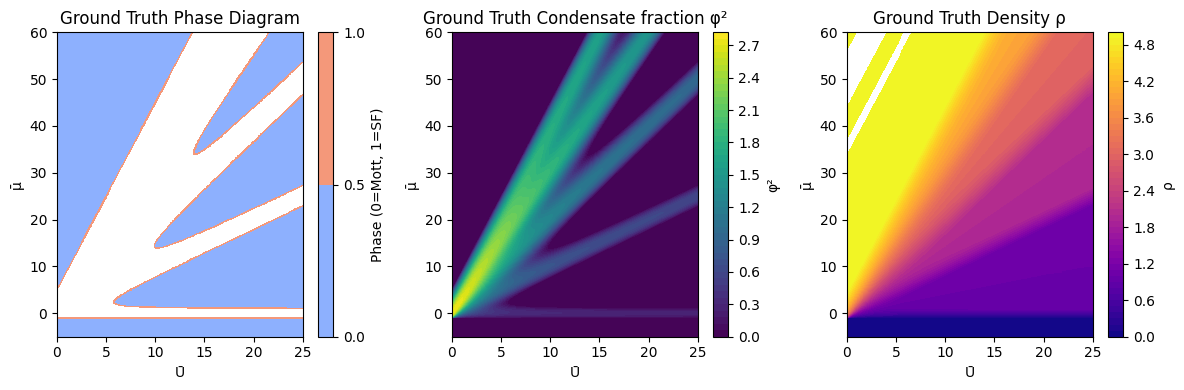

          t  Ubar  Mubar       Density          Phi2        Energy  Iters  \
0       1.0   0.0   -5.0  1.048576e-14  1.048576e-14  2.097152e-13      8   
1       1.0   0.0   -4.9  1.508449e-14  1.508449e-14  2.882646e-13      8   
2       1.0   0.0   -4.8  2.186340e-14  2.186340e-14  3.987884e-13      8   
3       1.0   0.0   -4.7  3.193733e-14  3.193733e-14  5.553901e-13      8   
4       1.0   0.0   -4.6  4.703477e-14  4.703477e-14  7.788958e-13      8   
...     ...   ...    ...           ...           ...           ...    ...   
163396  1.0  25.0   59.6  3.000000e+00  8.530376e-13 -1.038000e+02     21   
163397  1.0  25.0   59.7  3.000000e+00  7.586920e-13 -1.041000e+02     21   
163398  1.0  25.0   59.8  3.000000e+00  6.791729e-13 -1.044000e+02     21   
163399  1.0  25.0   59.9  3.000000e+00  6.119027e-13 -1.047000e+02     21   
163400  1.0  25.0   60.0  3.000000e+00  5.548081e-13 -1.050000e+02     21   

        Phase  
0           0  
1           0  
2           0  
3          

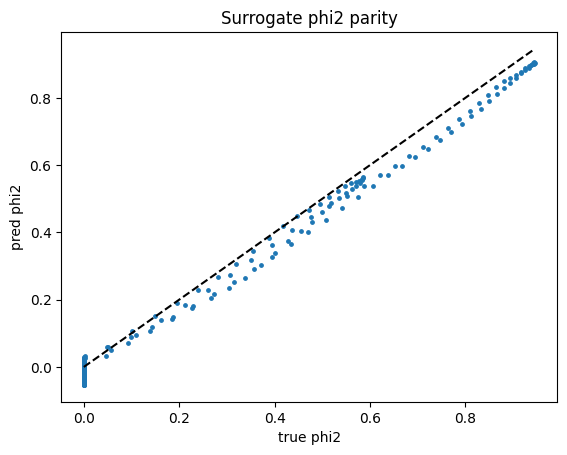

Epoch 0: lam_phys_current=0.000000
Epoch 1/200
543/543 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.2683 - phase_accuracy: 0.8219 - phase_loss: 0.3871 - phi2_loss: 0.1067 - phys_res_loss: 0.1070 - rho_loss: 0.6668 - val_loss: 0.5589 - val_phase_accuracy: 0.7773 - val_phase_loss: 0.4457 - val_phi2_loss: 0.0401 - val_phys_res_loss: 0.0382 - val_rho_loss: 0.0361 - learning_rate: 0.0010
Epoch 1: lam_phys_current=0.000000
Epoch 2/200
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2767 - phase_accuracy: 0.9123 - phase_loss: 0.1993 - phi2_loss: 0.0334 - phys_res_loss: 0.0332 - rho_loss: 0.0107 - val_loss: 0.3351 - val_phase_accuracy: 0.8588 - val_phase_loss: 0.2619 - val_phi2_loss: 0.0228 - val_phys_res_loss: 0.0214 - val_rho_loss: 0.0301 - learning_rate: 0.0010
Epoch 2: lam_phys_current=0.000000
Epoch 3/200
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1433 - phase_accuracy: 0.9692 - phase_loss: 0.1106 - phi2_loss: 0.0131 - phys_res_loss: 0.0129 - rho_loss: 0.0066 - val_loss: 0.1910 -

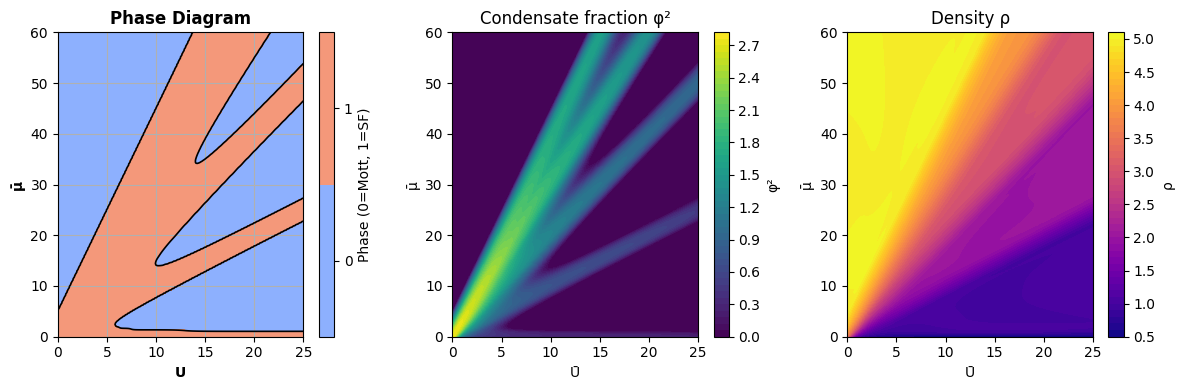

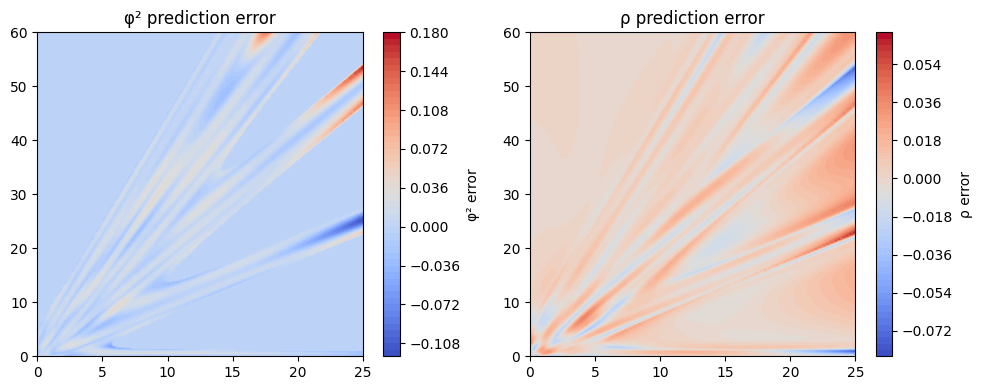

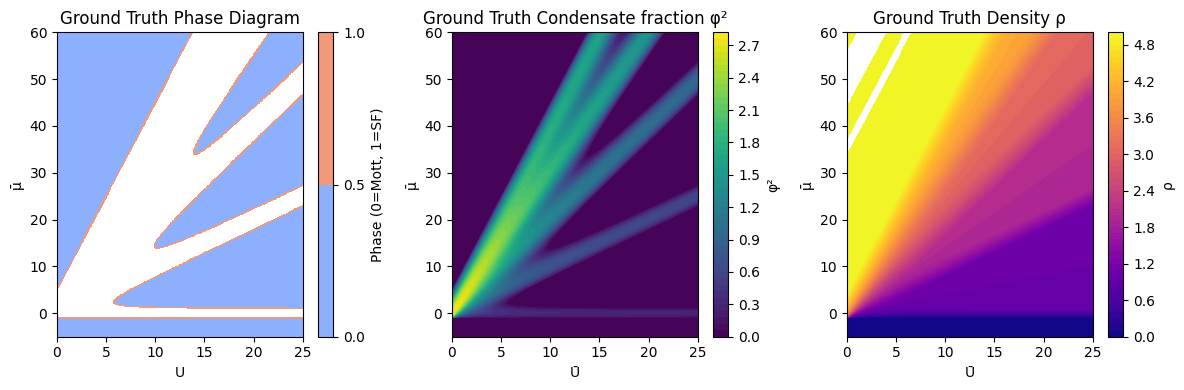


📊 Classification Report (Phase):
              precision    recall  f1-score   support

           0     0.9996    0.9984    0.9990     97450
           1     0.9976    0.9995    0.9985     65951

    accuracy                         0.9988    163401
   macro avg     0.9986    0.9989    0.9988    163401
weighted avg     0.9988    0.9988    0.9988    163401



C:\Users\DELL\AppData\Local\Temp\ipykernel_6640\3115339313.py:428: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_true_labels = df["Phase"].astype(int).ravel()


In [20]:
# Callback to ramp lam_phys in model.loss via attribute; implement as example where model has attribute lam_phys
import tensorflow as tf

class LambdaRamp(tf.keras.callbacks.Callback):
    def __init__(self, start_epoch, end_epoch, final_value):
        self.start = start_epoch
        self.end = end_epoch
        self.final = final_value
    def on_epoch_begin(self, epoch, logs=None):
        if epoch < self.start:
            val = 0.0
        elif epoch >= self.end:
            val = self.final
        else:
            val = (epoch - self.start)/(self.end - self.start) * self.final
        # store in model for your physics loss lambda to read
        setattr(self.model, "lam_phys_current", float(val))
        # optional logging
        print(f"Epoch {epoch}: lam_phys_current={val:.6f}")

# Modify physics loss lambda in compile to read model.lam_phys_current; easiest: implement phys loss using closure that reads model attribute
# Example usage:
ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
# pass ramp_cb to fit callbacks
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from pytorch_tabnet.tab_model import TabNetClassifier


# Label: 1 = Superfluid, 0 = Mott
def label_phase(rho, phi2, tol_rho=1e-3, tol_phi=1e-6):
    """
    Classify phase:
    - Mott insulator if (rho ~ integer) and (phi^2 ~ 0).
    - Superfluid otherwise.
    """
    is_integer_rho = np.isclose(rho, np.round(rho), atol=tol_rho)
    is_zero_phi = phi2 < tol_phi
    
    if is_integer_rho and is_zero_phi:
        return 0  # Mott
    else:
        return 1  # Superfluid

        
# # ---------- 1) Load and label ----------
# df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# # Label: 1 = Superfluid, 0 = Mott
# df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

# # Features and target: **only** Ubar, Mubar
# X = df[["Ubar", "Mubar"]].copy()
# y = df["Phase"].copy()

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.25, random_state=42,
#     stratify=y
# )


# # Apply physics-based labeling
# df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)

# # Features and target: **only** Ubar, Mubar
# X = df[["Ubar", "Mubar"]].copy()
# y = df["Phase"].copy()

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.25, random_state=42,
#     stratify=y
# )

# ---------- 1) Load and label ----------
df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Apply physics-based labeling (optional, but consistent)
df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)




# # --- pick deep MI (phi2 ≈ 0, density ~ integer) ---



# df_MI = df[
#     (df["Phi2"] < 1e-8) &
#     (np.isclose(df["Density"], np.round(df["Density"]), atol=1e-3))
# ]

# # --- pick deep SF (large phi2) ---
# df_SF = df[df["Phi2"] > 1e-2]

# # --- pick boundary (ambiguous region) ---
# df_boundary = df[
#     (df["Phi2"] > 1e-6) & (df["Phi2"] < 1e-2)
# ]

# # ------------------------------
# # Smart sampling strategy
# # ------------------------------
# # n_MI = min(2000, len(df_MI))             # cap deep MI
# # n_SF = min(2000, len(df_SF))             # cap deep SF
# # n_boundary = min(6000, len(df_boundary)) # oversample boundary

# n_MI = min(5000, len(df_MI))
# n_SF = min(5000, len(df_SF))
# n_boundary = min(10000, len(df_boundary))


# df_reduced = pd.concat([
#     df_MI.sample(n_MI, random_state=42),
#     df_SF.sample(n_SF, random_state=42),
#     df_boundary.sample(n_boundary, random_state=42)
# ])
# print(df)
# df_reduced = df_reduced.reset_index(drop=True)
# # Use reduced dataset
# df = df_reduced.reset_index(drop=True)
# print(df)


# print("Reduced dataset summary:")
# print(df_reduced["Phase"].value_counts())

# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")

# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()

# --- 1) Load data ---
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# # Load dataset
# df = reduced_df

print(df)

# Features and targets
X = df[["Ubar","Mubar"]].values.astype(np.float32)
y = {
    "phase": df["Phase"].values.astype(np.float32),
    "phi2": df["Phi2"].values.astype(np.float32),
    "rho": df["Density"].values.astype(np.float32),
}

# --- 2) Train surrogate model ---
def build_surrogate(hidden=(128,64)):
    inp = keras.Input(shape=(2,))
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="relu")(x)
    out = layers.Dense(2, activation="linear")(x)   # [phi2, rho]
    m = keras.Model(inp, out)
    m.compile(optimizer="adam", loss="mse")
    return m

X_surr = df[["Ubar","Mubar"]].values.astype(np.float32)
y_surr = df[["Phi2","Density"]].values.astype(np.float32)

surrogate = build_surrogate()
surrogate.fit(
    X_surr, y_surr,
    epochs=200, batch_size=512,
    validation_split=0.15, verbose=1
)

# Surrogate validation
from sklearn.metrics import mean_squared_error, mean_absolute_error
X_val = X_surr[-500:]   # or better: shuffle and split properly
y_val = y_surr[-500:]
y_pred = surrogate.predict(X_val)
print("Surrogate MSE:", mean_squared_error(y_val, y_pred))
print("Surrogate MAE:", mean_absolute_error(y_val, y_pred))

# parity plot
import matplotlib.pyplot as plt
plt.scatter(y_val[:,0], y_pred[:,0], s=6); plt.xlabel("true phi2"); plt.ylabel("pred phi2"); plt.title("Surrogate phi2 parity")
plt.plot([y_val[:,0].min(), y_val[:,0].max()],[y_val[:,0].min(), y_val[:,0].max()], 'k--'); plt.show()


# Save & reload in new Keras format
surrogate.save("surrogate_phi_rho.keras")
surrogate = keras.models.load_model("surrogate_phi_rho.keras", compile=False)
surrogate.trainable = False   # freeze surrogate

# --- 3) PINN with surrogate residual ---
def make_pinn_with_surrogate(hidden=(128,64), lam_phase=1.0, lam_phys=1.0):
    inp = keras.Input(shape=(2,), name="input")   # [Ubar, Mubar]
    lam_phys_var = tf.Variable(lam_phys, trainable=False, dtype=tf.float32, name="lam_phys")
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="tanh")(x)

    phase_out = layers.Dense(1, activation="sigmoid", name="phase")(x)
    phi_out   = layers.Dense(1, activation="relu", name="phi2")(x)
    rho_out   = layers.Dense(1, activation="relu", name="rho")(x)

    # Physics residual via surrogate
    def phys_residual(inputs):
        UMb, phi_pred = inputs[0], inputs[1]
        s = surrogate(UMb)                  # surrogate predictions [phi2, rho]
        s_phi = tf.expand_dims(s[:, 0], -1) # only phi2
        return phi_pred - s_phi

    phys_out = layers.Lambda(
        lambda t: phys_residual([t[0], t[1]]),
        name="phys_res"
    )([inp, phi_out])

    model = keras.Model(inputs=inp, outputs=[phase_out, phi_out, rho_out, phys_out])

    losses = {
        "phase": "binary_crossentropy",
        "phi2": "mse",
        "rho": "mse",
        "phys_res": lambda y_true, y_pred: lam_phys_var * tf.reduce_mean(tf.square(y_pred))
    }
    loss_weights = {"phase": lam_phase, "phi2": 1.0, "rho": 1.0, "phys_res": 1.0}

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss=losses,
        loss_weights=loss_weights,
        metrics={"phase":"accuracy"}
    )
    model.lam_phys = lam_phys_var
    return model

pinn_surrogate = make_pinn_with_surrogate()

# --- 4) Train PINN ---
y_targets = {
    "phase": df["Phase"].values.reshape(-1,1).astype(np.float32),
    "phi2":  df["Phi2"].values.reshape(-1,1).astype(np.float32),
    "rho":   df["Density"].values.reshape(-1,1).astype(np.float32),
    "phys_res": np.zeros((len(df),1), dtype=np.float32)
}


def mc_predict(model, X, n=50):
    preds = []
    for _ in range(n):
        p = model(X, training=True)  # keep dropout active
        preds.append(p[0].numpy())   # phase output
    preds = np.stack(preds, axis=0)
    return preds.mean(0), preds.std(0)

    
ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
history = pinn_surrogate.fit(
    X, y_targets,
    batch_size=256,
    epochs=200,
    validation_split=0.15,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(patience=8, factor=0.5),ramp_cb
        # keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True)
    ]
)

# --- 5) Phase diagram prediction ---
U_vals = np.linspace(0, 25, 200)   # Ū axis
mu_vals = np.linspace(0, 60, 200)  # μ̄ axis
UU, MU = np.meshgrid(U_vals, mu_vals)
X_grid = np.stack([UU.ravel(), MU.ravel()], axis=1).astype(np.float32)

# Predict → 4 outputs
y_pred_grid = pinn_surrogate.predict(X_grid, verbose=0)
phase_pred, phi2_pred, rho_pred, _ = y_pred_grid

phase_pred = phase_pred.reshape(UU.shape)
phi2_pred  = phi2_pred.reshape(UU.shape)
rho_pred   = rho_pred.reshape(UU.shape)
phase_pred_class = (phase_pred > 0.5).astype(int)

plt.figure(figsize=(12,4))

# --- Phase diagram ---
plt.subplot(1,3,1)
mappable = plt.contourf(UU, MU, phase_pred_class,
                        levels=[-0.5, 0.5, 1.5], cmap="coolwarm")
plt.colorbar(mappable, ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
plt.contour(UU, MU, phase_pred, levels=[0.5], colors="k", linewidths=1.2)  # phase boundary
plt.xlabel("U",fontsize=10,fontweight="bold")
plt.ylabel("μ̄",fontsize=10, fontweight="bold")
plt.title("Phase Diagram",fontsize=12, fontweight="bold")
plt.grid(True)
plt.savefig('fulldata-Pinn-keras-pred', dpi=300, bbox_inches='tight')

# --- φ² diagram ---
plt.subplot(1,3,2)
mappable = plt.contourf(UU, MU, phi2_pred, 50, cmap="viridis")
plt.colorbar(mappable, label="φ²")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Condensate fraction φ²")

# --- ρ diagram ---
plt.subplot(1,3,3)
mappable = plt.contourf(UU, MU, rho_pred, 50, cmap="plasma")
plt.colorbar(mappable, label="ρ")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Density ρ")

plt.tight_layout()
plt.show()

from scipy.interpolate import griddata

# Ground truth values
points = df[["Ubar","Mubar"]].values
phi2_true_interp = griddata(points, df["Phi2"].values, (UU, MU), method="linear")
rho_true_interp  = griddata(points, df["Density"].values, (UU, MU), method="linear")

# Compute errors on grid
phi2_err = phi2_pred - phi2_true_interp
rho_err  = rho_pred - rho_true_interp

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.contourf(UU, MU, phi2_err, 50, cmap="coolwarm")
plt.colorbar(label="φ² error")
plt.title("φ² prediction error")

plt.subplot(1,2,2)
plt.contourf(UU, MU, rho_err, 50, cmap="coolwarm")
plt.colorbar(label="ρ error")
plt.title("ρ prediction error")
plt.tight_layout(); plt.show()



# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("U")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")


# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()


# --- 6) Classification report ---
y_pred_phase, y_pred_phi2, y_pred_rho, _ = pinn_surrogate.predict(X, verbose=0)
y_pred_labels = (y_pred_phase > 0.5).astype(int).ravel()
y_true_labels = df["Phase"].astype(int).ravel()

print("\n📊 Classification Report (Phase):")
print(classification_report(y_true_labels, y_pred_labels, digits=4))



# FULL extra

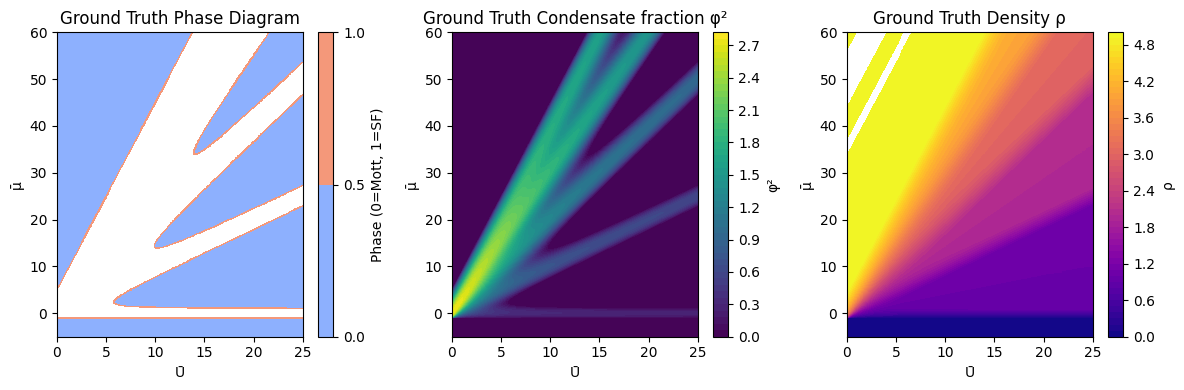

          t  Ubar  Mubar       Density          Phi2        Energy  Iters  \
0       1.0   0.0   -5.0  1.048576e-14  1.048576e-14  2.097152e-13      8   
1       1.0   0.0   -4.9  1.508449e-14  1.508449e-14  2.882646e-13      8   
2       1.0   0.0   -4.8  2.186340e-14  2.186340e-14  3.987884e-13      8   
3       1.0   0.0   -4.7  3.193733e-14  3.193733e-14  5.553901e-13      8   
4       1.0   0.0   -4.6  4.703477e-14  4.703477e-14  7.788958e-13      8   
...     ...   ...    ...           ...           ...           ...    ...   
163396  1.0  25.0   59.6  3.000000e+00  8.530376e-13 -1.038000e+02     21   
163397  1.0  25.0   59.7  3.000000e+00  7.586920e-13 -1.041000e+02     21   
163398  1.0  25.0   59.8  3.000000e+00  6.791729e-13 -1.044000e+02     21   
163399  1.0  25.0   59.9  3.000000e+00  6.119027e-13 -1.047000e+02     21   
163400  1.0  25.0   60.0  3.000000e+00  5.548081e-13 -1.050000e+02     21   

        Phase  
0           0  
1           0  
2           0  
3          

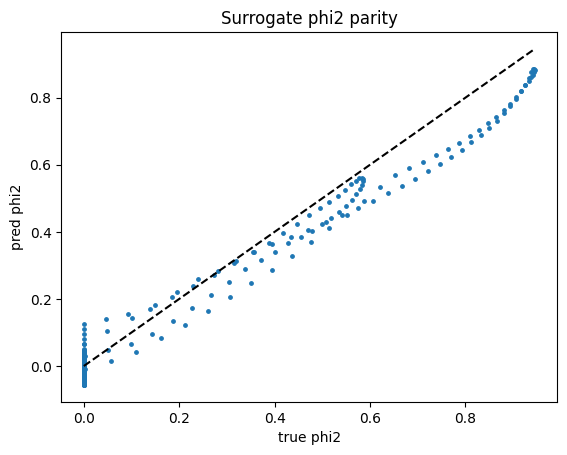

Epoch 0: lam_phys_current=0.000000
Epoch 1/200
543/543 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.8101 - phase_accuracy: 0.8308 - phase_loss: 0.3758 - phi2_loss: 0.1083 - phys_res_loss: 0.1079 - rho_loss: 0.2178 - val_loss: 0.5597 - val_phase_accuracy: 0.7734 - val_phase_loss: 0.4415 - val_phi2_loss: 0.0421 - val_phys_res_loss: 0.0365 - val_rho_loss: 0.0407 - learning_rate: 0.0010
Epoch 1: lam_phys_current=0.000000
Epoch 2/200
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3074 - phase_accuracy: 0.9089 - phase_loss: 0.2071 - phi2_loss: 0.0442 - phys_res_loss: 0.0442 - rho_loss: 0.0119 - val_loss: 0.3907 - val_phase_accuracy: 0.8542 - val_phase_loss: 0.2988 - val_phi2_loss: 0.0338 - val_phys_res_loss: 0.0303 - val_rho_loss: 0.0292 - learning_rate: 0.0010
Epoch 2: lam_phys_current=0.000000
Epoch 3/200
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1879 - phase_accuracy: 0.9584 - phase_loss: 0.1304 - phi2_loss: 0.0247 - phys_res_loss: 0.0248 - rho_loss: 0.0080 - val_loss: 0.2245 -

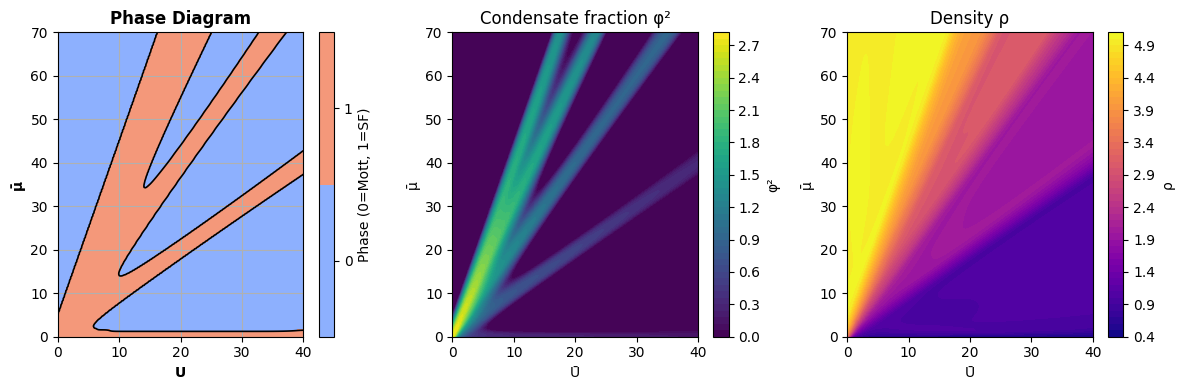

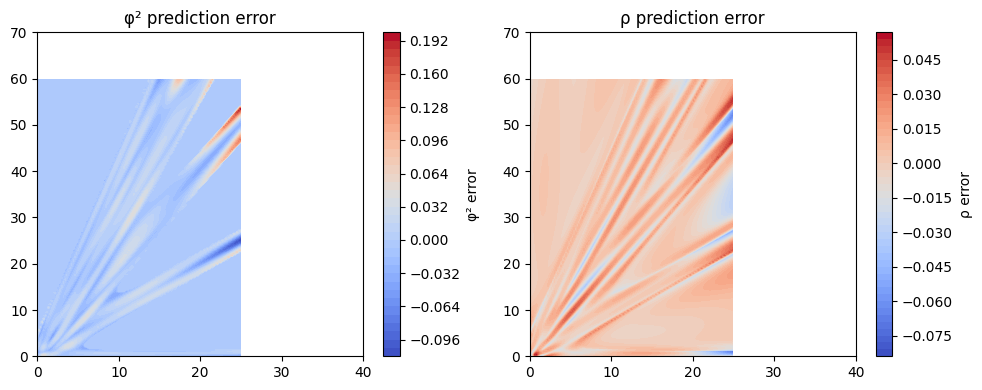

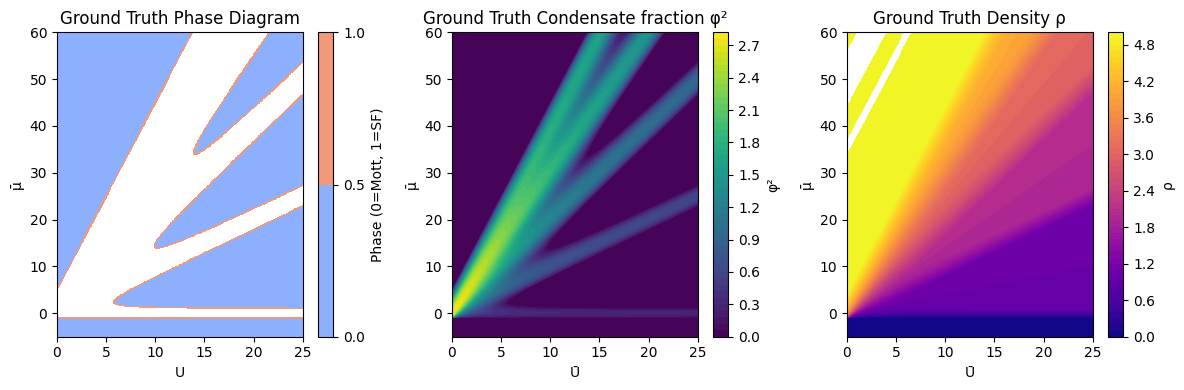


📊 Classification Report (Phase):
              precision    recall  f1-score   support

           0     0.9994    0.9978    0.9986     97450
           1     0.9968    0.9992    0.9980     65951

    accuracy                         0.9984    163401
   macro avg     0.9981    0.9985    0.9983    163401
weighted avg     0.9984    0.9984    0.9984    163401



C:\Users\DELL\AppData\Local\Temp\ipykernel_21340\577275019.py:428: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_true_labels = df["Phase"].astype(int).ravel()


In [5]:
# Callback to ramp lam_phys in model.loss via attribute; implement as example where model has attribute lam_phys
import tensorflow as tf

class LambdaRamp(tf.keras.callbacks.Callback):
    def __init__(self, start_epoch, end_epoch, final_value):
        self.start = start_epoch
        self.end = end_epoch
        self.final = final_value
    def on_epoch_begin(self, epoch, logs=None):
        if epoch < self.start:
            val = 0.0
        elif epoch >= self.end:
            val = self.final
        else:
            val = (epoch - self.start)/(self.end - self.start) * self.final
        # store in model for your physics loss lambda to read
        setattr(self.model, "lam_phys_current", float(val))
        # optional logging
        print(f"Epoch {epoch}: lam_phys_current={val:.6f}")

# Modify physics loss lambda in compile to read model.lam_phys_current; easiest: implement phys loss using closure that reads model attribute
# Example usage:
ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
# pass ramp_cb to fit callbacks
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from pytorch_tabnet.tab_model import TabNetClassifier


# Label: 1 = Superfluid, 0 = Mott
def label_phase(rho, phi2, tol_rho=1e-3, tol_phi=1e-6):
    """
    Classify phase:
    - Mott insulator if (rho ~ integer) and (phi^2 ~ 0).
    - Superfluid otherwise.
    """
    is_integer_rho = np.isclose(rho, np.round(rho), atol=tol_rho)
    is_zero_phi = phi2 < tol_phi
    
    if is_integer_rho and is_zero_phi:
        return 0  # Mott
    else:
        return 1  # Superfluid

        
# # ---------- 1) Load and label ----------
# df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# # Label: 1 = Superfluid, 0 = Mott
# df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

# # Features and target: **only** Ubar, Mubar
# X = df[["Ubar", "Mubar"]].copy()
# y = df["Phase"].copy()

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.25, random_state=42,
#     stratify=y
# )


# # Apply physics-based labeling
# df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)

# # Features and target: **only** Ubar, Mubar
# X = df[["Ubar", "Mubar"]].copy()
# y = df["Phase"].copy()

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.25, random_state=42,
#     stratify=y
# )

# ---------- 1) Load and label ----------
df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Apply physics-based labeling (optional, but consistent)
df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)




# # --- pick deep MI (phi2 ≈ 0, density ~ integer) ---



# df_MI = df[
#     (df["Phi2"] < 1e-8) &
#     (np.isclose(df["Density"], np.round(df["Density"]), atol=1e-3))
# ]

# # --- pick deep SF (large phi2) ---
# df_SF = df[df["Phi2"] > 1e-2]

# # --- pick boundary (ambiguous region) ---
# df_boundary = df[
#     (df["Phi2"] > 1e-6) & (df["Phi2"] < 1e-2)
# ]

# # ------------------------------
# # Smart sampling strategy
# # ------------------------------
# # n_MI = min(2000, len(df_MI))             # cap deep MI
# # n_SF = min(2000, len(df_SF))             # cap deep SF
# # n_boundary = min(6000, len(df_boundary)) # oversample boundary

# n_MI = min(5000, len(df_MI))
# n_SF = min(5000, len(df_SF))
# n_boundary = min(10000, len(df_boundary))


# df_reduced = pd.concat([
#     df_MI.sample(n_MI, random_state=42),
#     df_SF.sample(n_SF, random_state=42),
#     df_boundary.sample(n_boundary, random_state=42)
# ])
# print(df)
# df_reduced = df_reduced.reset_index(drop=True)
# # Use reduced dataset
# df = df_reduced.reset_index(drop=True)
# print(df)


# print("Reduced dataset summary:")
# print(df_reduced["Phase"].value_counts())

# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")

# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()

# --- 1) Load data ---
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# # Load dataset
# df = reduced_df

print(df)

# Features and targets
X = df[["Ubar","Mubar"]].values.astype(np.float32)
y = {
    "phase": df["Phase"].values.astype(np.float32),
    "phi2": df["Phi2"].values.astype(np.float32),
    "rho": df["Density"].values.astype(np.float32),
}

# --- 2) Train surrogate model ---
def build_surrogate(hidden=(128,64)):
    inp = keras.Input(shape=(2,))
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="relu")(x)
    out = layers.Dense(2, activation="linear")(x)   # [phi2, rho]
    m = keras.Model(inp, out)
    m.compile(optimizer="adam", loss="mse")
    return m

X_surr = df[["Ubar","Mubar"]].values.astype(np.float32)
y_surr = df[["Phi2","Density"]].values.astype(np.float32)

surrogate = build_surrogate()
surrogate.fit(
    X_surr, y_surr,
    epochs=200, batch_size=512,
    validation_split=0.15, verbose=1
)

# Surrogate validation
from sklearn.metrics import mean_squared_error, mean_absolute_error
X_val = X_surr[-500:]   # or better: shuffle and split properly
y_val = y_surr[-500:]
y_pred = surrogate.predict(X_val)
print("Surrogate MSE:", mean_squared_error(y_val, y_pred))
print("Surrogate MAE:", mean_absolute_error(y_val, y_pred))

# parity plot
import matplotlib.pyplot as plt
plt.scatter(y_val[:,0], y_pred[:,0], s=6); plt.xlabel("true phi2"); plt.ylabel("pred phi2"); plt.title("Surrogate phi2 parity")
plt.plot([y_val[:,0].min(), y_val[:,0].max()],[y_val[:,0].min(), y_val[:,0].max()], 'k--'); plt.show()


# Save & reload in new Keras format
surrogate.save("surrogate_phi_rho.keras")
surrogate = keras.models.load_model("surrogate_phi_rho.keras", compile=False)
surrogate.trainable = False   # freeze surrogate

# --- 3) PINN with surrogate residual ---
def make_pinn_with_surrogate(hidden=(128,64), lam_phase=1.0, lam_phys=1.0):
    inp = keras.Input(shape=(2,), name="input")   # [Ubar, Mubar]
    lam_phys_var = tf.Variable(lam_phys, trainable=False, dtype=tf.float32, name="lam_phys")
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="tanh")(x)

    phase_out = layers.Dense(1, activation="sigmoid", name="phase")(x)
    phi_out   = layers.Dense(1, activation="relu", name="phi2")(x)
    rho_out   = layers.Dense(1, activation="relu", name="rho")(x)

    # Physics residual via surrogate
    def phys_residual(inputs):
        UMb, phi_pred = inputs[0], inputs[1]
        s = surrogate(UMb)                  # surrogate predictions [phi2, rho]
        s_phi = tf.expand_dims(s[:, 0], -1) # only phi2
        return phi_pred - s_phi

    phys_out = layers.Lambda(
        lambda t: phys_residual([t[0], t[1]]),
        name="phys_res"
    )([inp, phi_out])

    model = keras.Model(inputs=inp, outputs=[phase_out, phi_out, rho_out, phys_out])

    losses = {
        "phase": "binary_crossentropy",
        "phi2": "mse",
        "rho": "mse",
        "phys_res": lambda y_true, y_pred: lam_phys_var * tf.reduce_mean(tf.square(y_pred))
    }
    loss_weights = {"phase": lam_phase, "phi2": 1.0, "rho": 1.0, "phys_res": 1.0}

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss=losses,
        loss_weights=loss_weights,
        metrics={"phase":"accuracy"}
    )
    model.lam_phys = lam_phys_var
    return model

pinn_surrogate = make_pinn_with_surrogate()

# --- 4) Train PINN ---
y_targets = {
    "phase": df["Phase"].values.reshape(-1,1).astype(np.float32),
    "phi2":  df["Phi2"].values.reshape(-1,1).astype(np.float32),
    "rho":   df["Density"].values.reshape(-1,1).astype(np.float32),
    "phys_res": np.zeros((len(df),1), dtype=np.float32)
}


def mc_predict(model, X, n=50):
    preds = []
    for _ in range(n):
        p = model(X, training=True)  # keep dropout active
        preds.append(p[0].numpy())   # phase output
    preds = np.stack(preds, axis=0)
    return preds.mean(0), preds.std(0)

    
ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
history = pinn_surrogate.fit(
    X, y_targets,
    batch_size=256,
    epochs=200,
    validation_split=0.15,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(patience=8, factor=0.5),ramp_cb
        # keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True)
    ]
)

# --- 5) Phase diagram prediction ---
U_vals = np.linspace(0, 40, 200)   # Ū axis
mu_vals = np.linspace(0, 70, 200)  # μ̄ axis
UU, MU = np.meshgrid(U_vals, mu_vals)
X_grid = np.stack([UU.ravel(), MU.ravel()], axis=1).astype(np.float32)

# Predict → 4 outputs
y_pred_grid = pinn_surrogate.predict(X_grid, verbose=0)
phase_pred, phi2_pred, rho_pred, _ = y_pred_grid

phase_pred = phase_pred.reshape(UU.shape)
phi2_pred  = phi2_pred.reshape(UU.shape)
rho_pred   = rho_pred.reshape(UU.shape)
phase_pred_class = (phase_pred > 0.5).astype(int)

plt.figure(figsize=(12,4))

# --- Phase diagram ---
plt.subplot(1,3,1)
mappable = plt.contourf(UU, MU, phase_pred_class,
                        levels=[-0.5, 0.5, 1.5], cmap="coolwarm")
plt.colorbar(mappable, ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
plt.contour(UU, MU, phase_pred, levels=[0.5], colors="k", linewidths=1.2)  # phase boundary
plt.xlabel("U",fontsize=10,fontweight="bold")
plt.ylabel("μ̄",fontsize=10, fontweight="bold")
plt.title("Phase Diagram",fontsize=12, fontweight="bold")
plt.grid(True)
plt.savefig('fulldata-extra-Pinn-keras-pred', dpi=300, bbox_inches='tight')

# --- φ² diagram ---
plt.subplot(1,3,2)
mappable = plt.contourf(UU, MU, phi2_pred, 50, cmap="viridis")
plt.colorbar(mappable, label="φ²")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Condensate fraction φ²")

# --- ρ diagram ---
plt.subplot(1,3,3)
mappable = plt.contourf(UU, MU, rho_pred, 50, cmap="plasma")
plt.colorbar(mappable, label="ρ")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Density ρ")

plt.tight_layout()
plt.show()

from scipy.interpolate import griddata

# Ground truth values
points = df[["Ubar","Mubar"]].values
phi2_true_interp = griddata(points, df["Phi2"].values, (UU, MU), method="linear")
rho_true_interp  = griddata(points, df["Density"].values, (UU, MU), method="linear")

# Compute errors on grid
phi2_err = phi2_pred - phi2_true_interp
rho_err  = rho_pred - rho_true_interp

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.contourf(UU, MU, phi2_err, 50, cmap="coolwarm")
plt.colorbar(label="φ² error")
plt.title("φ² prediction error")

plt.subplot(1,2,2)
plt.contourf(UU, MU, rho_err, 50, cmap="coolwarm")
plt.colorbar(label="ρ error")
plt.title("ρ prediction error")
plt.tight_layout(); plt.show()



# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("U")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")


# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()


# --- 6) Classification report ---
y_pred_phase, y_pred_phi2, y_pred_rho, _ = pinn_surrogate.predict(X, verbose=0)
y_pred_labels = (y_pred_phase > 0.5).astype(int).ravel()
y_true_labels = df["Phase"].astype(int).ravel()

print("\n📊 Classification Report (Phase):")
print(classification_report(y_true_labels, y_pred_labels, digits=4))



# 10k

          t  Ubar  Mubar       Density          Phi2        Energy  Iters  \
0       1.0   0.0   -5.0  1.048576e-14  1.048576e-14  2.097152e-13      8   
1       1.0   0.0   -4.9  1.508449e-14  1.508449e-14  2.882646e-13      8   
2       1.0   0.0   -4.8  2.186340e-14  2.186340e-14  3.987884e-13      8   
3       1.0   0.0   -4.7  3.193733e-14  3.193733e-14  5.553901e-13      8   
4       1.0   0.0   -4.6  4.703477e-14  4.703477e-14  7.788958e-13      8   
...     ...   ...    ...           ...           ...           ...    ...   
163396  1.0  25.0   59.6  3.000000e+00  8.530376e-13 -1.038000e+02     21   
163397  1.0  25.0   59.7  3.000000e+00  7.586920e-13 -1.041000e+02     21   
163398  1.0  25.0   59.8  3.000000e+00  6.791729e-13 -1.044000e+02     21   
163399  1.0  25.0   59.9  3.000000e+00  6.119027e-13 -1.047000e+02     21   
163400  1.0  25.0   60.0  3.000000e+00  5.548081e-13 -1.050000e+02     21   

        Phase  
0           0  
1           0  
2           0  
3          

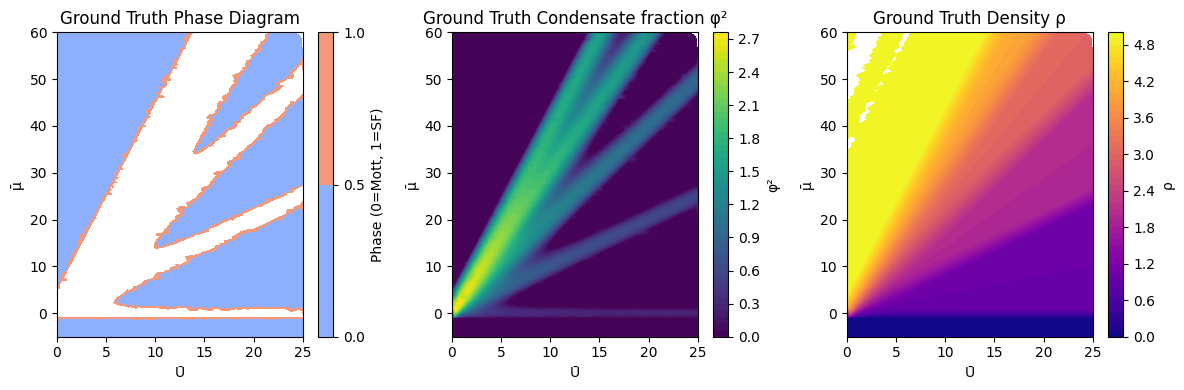

         t  Ubar  Mubar       Density          Phi2        Energy  Iters  \
0      1.0  24.4   13.4  1.000000e+00  6.034134e-14 -1.340000e+01      9   
1      1.0  16.0   -1.1  8.624612e-11  8.624612e-11  9.487073e-12    101   
2      1.0  22.4    6.0  1.000000e+00  5.328648e-14 -6.000000e+00     10   
3      1.0  14.2   22.4  2.000000e+00  6.649626e-12 -3.060000e+01     37   
4      1.0  22.0    7.5  1.000000e+00  1.363996e-14 -7.500000e+00     10   
...    ...   ...    ...           ...           ...           ...    ...   
10679  1.0   3.6   -1.0  8.456767e-05  8.456471e-05  4.598585e-09   4589   
10680  1.0   5.3   26.2  4.999955e+00  2.254263e-04 -7.800000e+01   7465   
10681  1.0  10.9   17.5  2.000244e+00  2.100670e-03 -2.410000e+01   2451   
10682  1.0  16.3   -1.0  6.803388e-05  6.803021e-05  4.123775e-09   4118   
10683  1.0   5.1   25.4  4.999955e+00  2.261209e-04 -7.600000e+01   7477   

       Phase  
0          0  
1          0  
2          0  
3          0  
4          0

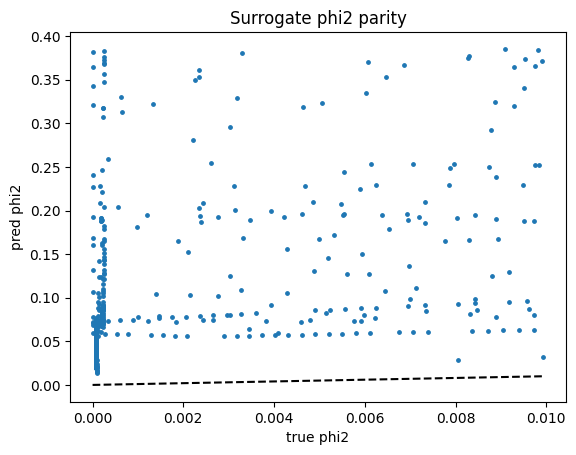

Epoch 0: lam_phys_current=0.000000
Epoch 1/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.7550 - phase_accuracy: 0.5844 - phase_loss: 0.6834 - phi2_loss: 0.6615 - phys_res_loss: 0.6665 - rho_loss: 1.7253 - val_loss: 2.2928 - val_phase_accuracy: 0.5384 - val_phase_loss: 0.8637 - val_phi2_loss: 0.5433 - val_phys_res_loss: 0.5483 - val_rho_loss: 0.2341 - learning_rate: 0.0010
Epoch 1: lam_phys_current=0.000000
Epoch 2/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3984 - phase_accuracy: 0.7224 - phase_loss: 0.6088 - phi2_loss: 0.3201 - phys_res_loss: 0.3046 - rho_loss: 0.1593 - val_loss: 1.4253 - val_phase_accuracy: 0.4959 - val_phase_loss: 0.8205 - val_phi2_loss: 0.2660 - val_phys_res_loss: 0.2111 - val_rho_loss: 0.1461 - learning_rate: 0.0010
Epoch 2: lam_phys_current=0.000000
Epoch 3/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0045 - phase_accuracy: 0.7398 - phase_loss: 0.5793 - phi2_loss: 0.1808 - phys_res_loss: 0.1656 - rho_loss: 0.0784 - val_loss: 1.2738 - val_p

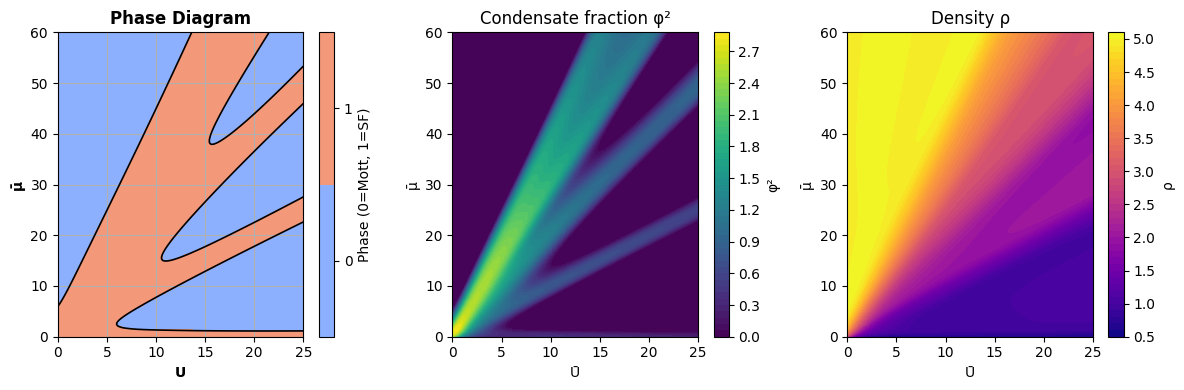

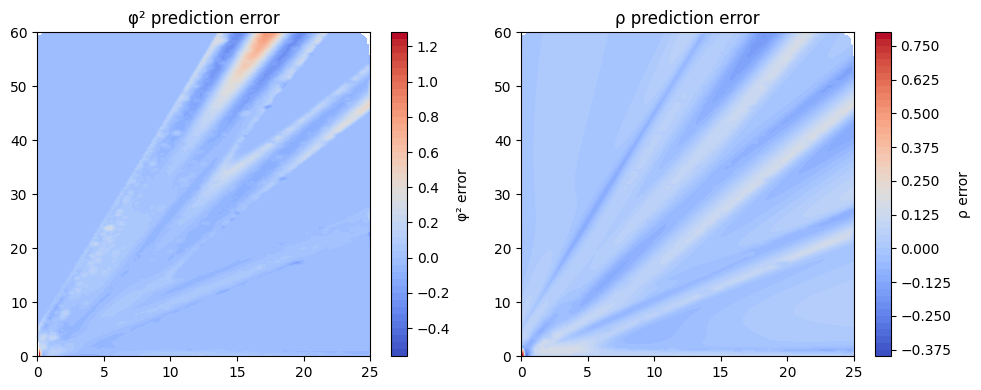

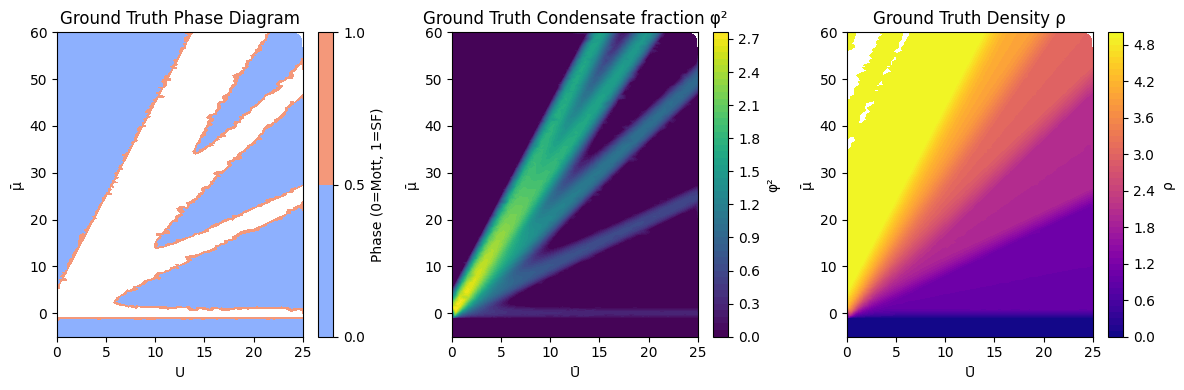


📊 Classification Report (Phase):
              precision    recall  f1-score   support

           0     0.9373    0.9830    0.9596      5000
           1     0.9844    0.9421    0.9628      5684

    accuracy                         0.9613     10684
   macro avg     0.9608    0.9626    0.9612     10684
weighted avg     0.9623    0.9613    0.9613     10684



C:\Users\DELL\AppData\Local\Temp\ipykernel_6640\2614218057.py:428: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_true_labels = df["Phase"].astype(int).ravel()


In [21]:
# Callback to ramp lam_phys in model.loss via attribute; implement as example where model has attribute lam_phys
import tensorflow as tf

class LambdaRamp(tf.keras.callbacks.Callback):
    def __init__(self, start_epoch, end_epoch, final_value):
        self.start = start_epoch
        self.end = end_epoch
        self.final = final_value
    def on_epoch_begin(self, epoch, logs=None):
        if epoch < self.start:
            val = 0.0
        elif epoch >= self.end:
            val = self.final
        else:
            val = (epoch - self.start)/(self.end - self.start) * self.final
        # store in model for your physics loss lambda to read
        setattr(self.model, "lam_phys_current", float(val))
        # optional logging
        print(f"Epoch {epoch}: lam_phys_current={val:.6f}")

# Modify physics loss lambda in compile to read model.lam_phys_current; easiest: implement phys loss using closure that reads model attribute
# Example usage:
ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
# pass ramp_cb to fit callbacks
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from pytorch_tabnet.tab_model import TabNetClassifier


# Label: 1 = Superfluid, 0 = Mott
def label_phase(rho, phi2, tol_rho=1e-3, tol_phi=1e-6):
    """
    Classify phase:
    - Mott insulator if (rho ~ integer) and (phi^2 ~ 0).
    - Superfluid otherwise.
    """
    is_integer_rho = np.isclose(rho, np.round(rho), atol=tol_rho)
    is_zero_phi = phi2 < tol_phi
    
    if is_integer_rho and is_zero_phi:
        return 0  # Mott
    else:
        return 1  # Superfluid

        
# # ---------- 1) Load and label ----------
# df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# # Label: 1 = Superfluid, 0 = Mott
# df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

# # Features and target: **only** Ubar, Mubar
# X = df[["Ubar", "Mubar"]].copy()
# y = df["Phase"].copy()

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.25, random_state=42,
#     stratify=y
# )


# # Apply physics-based labeling
# df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)

# # Features and target: **only** Ubar, Mubar
# X = df[["Ubar", "Mubar"]].copy()
# y = df["Phase"].copy()

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.25, random_state=42,
#     stratify=y
# )

# ---------- 1) Load and label ----------
df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Apply physics-based labeling (optional, but consistent)
df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)




# --- pick deep MI (phi2 ≈ 0, density ~ integer) ---



df_MI = df[
    (df["Phi2"] < 1e-8) &
    (np.isclose(df["Density"], np.round(df["Density"]), atol=1e-3))
]

# --- pick deep SF (large phi2) ---
df_SF = df[df["Phi2"] > 1e-2]

# --- pick boundary (ambiguous region) ---
df_boundary = df[
    (df["Phi2"] > 1e-6) & (df["Phi2"] < 1e-2)
]

# ------------------------------
# Smart sampling strategy
# ------------------------------
# n_MI = min(2000, len(df_MI))             # cap deep MI
# n_SF = min(2000, len(df_SF))             # cap deep SF
# n_boundary = min(6000, len(df_boundary)) # oversample boundary

n_MI = min(5000, len(df_MI))
n_SF = min(5000, len(df_SF))
n_boundary = min(10000, len(df_boundary))


df_reduced = pd.concat([
    df_MI.sample(n_MI, random_state=42),
    df_SF.sample(n_SF, random_state=42),
    df_boundary.sample(n_boundary, random_state=42)
])
print(df)
df_reduced = df_reduced.reset_index(drop=True)
# Use reduced dataset
df = df_reduced.reset_index(drop=True)
print(df)


print("Reduced dataset summary:")
print(df_reduced["Phase"].value_counts())

# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")

# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()

# --- 1) Load data ---
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# # Load dataset
# df = reduced_df

print(df)

# Features and targets
X = df[["Ubar","Mubar"]].values.astype(np.float32)
y = {
    "phase": df["Phase"].values.astype(np.float32),
    "phi2": df["Phi2"].values.astype(np.float32),
    "rho": df["Density"].values.astype(np.float32),
}

# --- 2) Train surrogate model ---
def build_surrogate(hidden=(128,64)):
    inp = keras.Input(shape=(2,))
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="relu")(x)
    out = layers.Dense(2, activation="linear")(x)   # [phi2, rho]
    m = keras.Model(inp, out)
    m.compile(optimizer="adam", loss="mse")
    return m

X_surr = df[["Ubar","Mubar"]].values.astype(np.float32)
y_surr = df[["Phi2","Density"]].values.astype(np.float32)

surrogate = build_surrogate()
surrogate.fit(
    X_surr, y_surr,
    epochs=200, batch_size=512,
    validation_split=0.15, verbose=1
)

# Surrogate validation
from sklearn.metrics import mean_squared_error, mean_absolute_error
X_val = X_surr[-500:]   # or better: shuffle and split properly
y_val = y_surr[-500:]
y_pred = surrogate.predict(X_val)
print("Surrogate MSE:", mean_squared_error(y_val, y_pred))
print("Surrogate MAE:", mean_absolute_error(y_val, y_pred))

# parity plot
import matplotlib.pyplot as plt
plt.scatter(y_val[:,0], y_pred[:,0], s=6); plt.xlabel("true phi2"); plt.ylabel("pred phi2"); plt.title("Surrogate phi2 parity")
plt.plot([y_val[:,0].min(), y_val[:,0].max()],[y_val[:,0].min(), y_val[:,0].max()], 'k--'); plt.show()


# Save & reload in new Keras format
surrogate.save("surrogate_phi_rho.keras")
surrogate = keras.models.load_model("surrogate_phi_rho.keras", compile=False)
surrogate.trainable = False   # freeze surrogate

# --- 3) PINN with surrogate residual ---
def make_pinn_with_surrogate(hidden=(128,64), lam_phase=1.0, lam_phys=1.0):
    inp = keras.Input(shape=(2,), name="input")   # [Ubar, Mubar]
    lam_phys_var = tf.Variable(lam_phys, trainable=False, dtype=tf.float32, name="lam_phys")
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="tanh")(x)

    phase_out = layers.Dense(1, activation="sigmoid", name="phase")(x)
    phi_out   = layers.Dense(1, activation="relu", name="phi2")(x)
    rho_out   = layers.Dense(1, activation="relu", name="rho")(x)

    # Physics residual via surrogate
    def phys_residual(inputs):
        UMb, phi_pred = inputs[0], inputs[1]
        s = surrogate(UMb)                  # surrogate predictions [phi2, rho]
        s_phi = tf.expand_dims(s[:, 0], -1) # only phi2
        return phi_pred - s_phi

    phys_out = layers.Lambda(
        lambda t: phys_residual([t[0], t[1]]),
        name="phys_res"
    )([inp, phi_out])

    model = keras.Model(inputs=inp, outputs=[phase_out, phi_out, rho_out, phys_out])

    losses = {
        "phase": "binary_crossentropy",
        "phi2": "mse",
        "rho": "mse",
        "phys_res": lambda y_true, y_pred: lam_phys_var * tf.reduce_mean(tf.square(y_pred))
    }
    loss_weights = {"phase": lam_phase, "phi2": 1.0, "rho": 1.0, "phys_res": 1.0}

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss=losses,
        loss_weights=loss_weights,
        metrics={"phase":"accuracy"}
    )
    model.lam_phys = lam_phys_var
    return model

pinn_surrogate = make_pinn_with_surrogate()

# --- 4) Train PINN ---
y_targets = {
    "phase": df["Phase"].values.reshape(-1,1).astype(np.float32),
    "phi2":  df["Phi2"].values.reshape(-1,1).astype(np.float32),
    "rho":   df["Density"].values.reshape(-1,1).astype(np.float32),
    "phys_res": np.zeros((len(df),1), dtype=np.float32)
}


def mc_predict(model, X, n=50):
    preds = []
    for _ in range(n):
        p = model(X, training=True)  # keep dropout active
        preds.append(p[0].numpy())   # phase output
    preds = np.stack(preds, axis=0)
    return preds.mean(0), preds.std(0)

    
ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
history = pinn_surrogate.fit(
    X, y_targets,
    batch_size=256,
    epochs=200,
    validation_split=0.15,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(patience=8, factor=0.5),ramp_cb
        # keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True)
    ]
)

# --- 5) Phase diagram prediction ---
U_vals = np.linspace(0, 25, 200)   # Ū axis
mu_vals = np.linspace(0, 60, 200)  # μ̄ axis
UU, MU = np.meshgrid(U_vals, mu_vals)
X_grid = np.stack([UU.ravel(), MU.ravel()], axis=1).astype(np.float32)

# Predict → 4 outputs
y_pred_grid = pinn_surrogate.predict(X_grid, verbose=0)
phase_pred, phi2_pred, rho_pred, _ = y_pred_grid

phase_pred = phase_pred.reshape(UU.shape)
phi2_pred  = phi2_pred.reshape(UU.shape)
rho_pred   = rho_pred.reshape(UU.shape)
phase_pred_class = (phase_pred > 0.5).astype(int)

plt.figure(figsize=(12,4))

# --- Phase diagram ---
plt.subplot(1,3,1)
mappable = plt.contourf(UU, MU, phase_pred_class,
                        levels=[-0.5, 0.5, 1.5], cmap="coolwarm")
plt.colorbar(mappable, ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
plt.contour(UU, MU, phase_pred, levels=[0.5], colors="k", linewidths=1.2)  # phase boundary
plt.xlabel("U",fontsize=10,fontweight="bold")
plt.ylabel("μ̄",fontsize=10, fontweight="bold")
plt.title("Phase Diagram",fontsize=12, fontweight="bold")
plt.grid(True)
plt.savefig('10k-Pinn-keras-pred', dpi=300, bbox_inches='tight')

# --- φ² diagram ---
plt.subplot(1,3,2)
mappable = plt.contourf(UU, MU, phi2_pred, 50, cmap="viridis")
plt.colorbar(mappable, label="φ²")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Condensate fraction φ²")

# --- ρ diagram ---
plt.subplot(1,3,3)
mappable = plt.contourf(UU, MU, rho_pred, 50, cmap="plasma")
plt.colorbar(mappable, label="ρ")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Density ρ")

plt.tight_layout()
plt.show()

from scipy.interpolate import griddata

# Ground truth values
points = df[["Ubar","Mubar"]].values
phi2_true_interp = griddata(points, df["Phi2"].values, (UU, MU), method="linear")
rho_true_interp  = griddata(points, df["Density"].values, (UU, MU), method="linear")

# Compute errors on grid
phi2_err = phi2_pred - phi2_true_interp
rho_err  = rho_pred - rho_true_interp

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.contourf(UU, MU, phi2_err, 50, cmap="coolwarm")
plt.colorbar(label="φ² error")
plt.title("φ² prediction error")

plt.subplot(1,2,2)
plt.contourf(UU, MU, rho_err, 50, cmap="coolwarm")
plt.colorbar(label="ρ error")
plt.title("ρ prediction error")
plt.tight_layout(); plt.show()



# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("U")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")


# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()


# --- 6) Classification report ---
y_pred_phase, y_pred_phi2, y_pred_rho, _ = pinn_surrogate.predict(X, verbose=0)
y_pred_labels = (y_pred_phase > 0.5).astype(int).ravel()
y_true_labels = df["Phase"].astype(int).ravel()

print("\n📊 Classification Report (Phase):")
print(classification_report(y_true_labels, y_pred_labels, digits=4))



# 10k extra

          t  Ubar  Mubar       Density          Phi2        Energy  Iters  \
0       1.0   0.0   -5.0  1.048576e-14  1.048576e-14  2.097152e-13      8   
1       1.0   0.0   -4.9  1.508449e-14  1.508449e-14  2.882646e-13      8   
2       1.0   0.0   -4.8  2.186340e-14  2.186340e-14  3.987884e-13      8   
3       1.0   0.0   -4.7  3.193733e-14  3.193733e-14  5.553901e-13      8   
4       1.0   0.0   -4.6  4.703477e-14  4.703477e-14  7.788958e-13      8   
...     ...   ...    ...           ...           ...           ...    ...   
163396  1.0  25.0   59.6  3.000000e+00  8.530376e-13 -1.038000e+02     21   
163397  1.0  25.0   59.7  3.000000e+00  7.586920e-13 -1.041000e+02     21   
163398  1.0  25.0   59.8  3.000000e+00  6.791729e-13 -1.044000e+02     21   
163399  1.0  25.0   59.9  3.000000e+00  6.119027e-13 -1.047000e+02     21   
163400  1.0  25.0   60.0  3.000000e+00  5.548081e-13 -1.050000e+02     21   

        Phase  
0           0  
1           0  
2           0  
3          

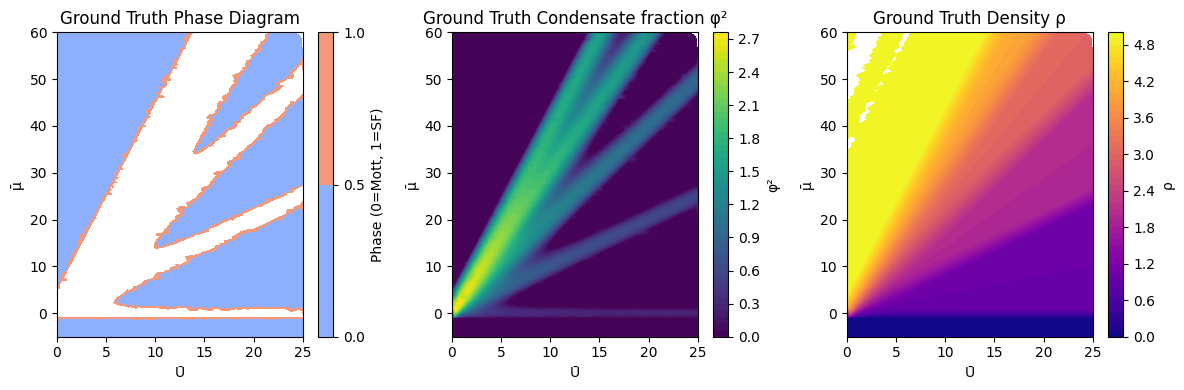

         t  Ubar  Mubar       Density          Phi2        Energy  Iters  \
0      1.0  24.4   13.4  1.000000e+00  6.034134e-14 -1.340000e+01      9   
1      1.0  16.0   -1.1  8.624612e-11  8.624612e-11  9.487073e-12    101   
2      1.0  22.4    6.0  1.000000e+00  5.328648e-14 -6.000000e+00     10   
3      1.0  14.2   22.4  2.000000e+00  6.649626e-12 -3.060000e+01     37   
4      1.0  22.0    7.5  1.000000e+00  1.363996e-14 -7.500000e+00     10   
...    ...   ...    ...           ...           ...           ...    ...   
10679  1.0   3.6   -1.0  8.456767e-05  8.456471e-05  4.598585e-09   4589   
10680  1.0   5.3   26.2  4.999955e+00  2.254263e-04 -7.800000e+01   7465   
10681  1.0  10.9   17.5  2.000244e+00  2.100670e-03 -2.410000e+01   2451   
10682  1.0  16.3   -1.0  6.803388e-05  6.803021e-05  4.123775e-09   4118   
10683  1.0   5.1   25.4  4.999955e+00  2.261209e-04 -7.600000e+01   7477   

       Phase  
0          0  
1          0  
2          0  
3          0  
4          0

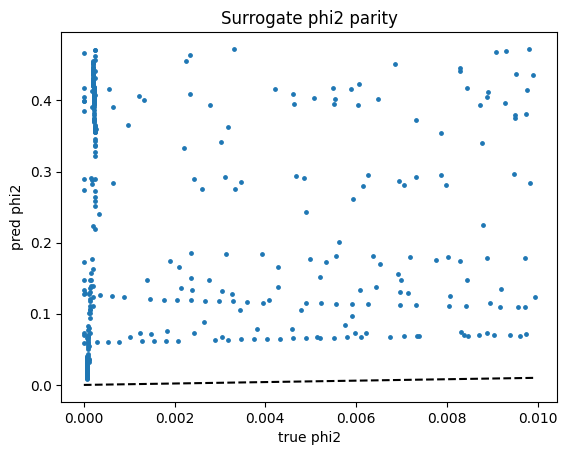


Epoch 0: lam_phys_current=0.000000
Epoch 1/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.7664 - phase_accuracy: 0.5622 - phase_loss: 0.6882 - phi2_loss: 0.3858 - phys_res_loss: 0.3718 - rho_loss: 1.2986 - val_loss: 1.5560 - val_phase_accuracy: 0.4529 - val_phase_loss: 0.8270 - val_phi2_loss: 0.2920 - val_phys_res_loss: 0.2255 - val_rho_loss: 0.2108 - learning_rate: 0.0010
Epoch 1: lam_phys_current=0.000000
Epoch 2/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1447 - phase_accuracy: 0.7060 - phase_loss: 0.6009 - phi2_loss: 0.2259 - phys_res_loss: 0.2116 - rho_loss: 0.1046 - val_loss: 1.3440 - val_phase_accuracy: 0.5777 - val_phase_loss: 0.8264 - val_phi2_loss: 0.2590 - val_phys_res_loss: 0.1820 - val_rho_loss: 0.0955 - learning_rate: 0.0010
Epoch 2: lam_phys_current=0.000000
Epoch 3/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9327 - phase_accuracy: 0.7636 - phase_loss: 0.5441 - phi2_loss: 0.1720 - phys_res_loss: 0.1601 - rho_loss: 0.0564 - val_loss: 1.2627 - val_

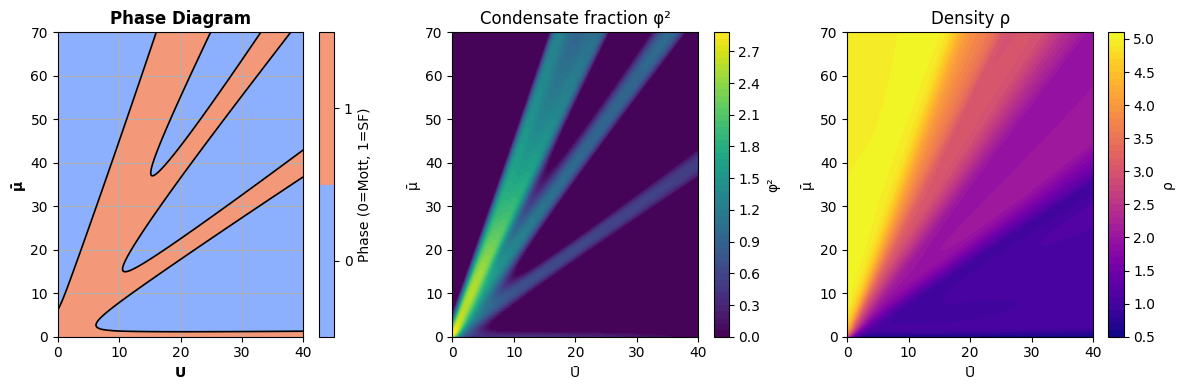

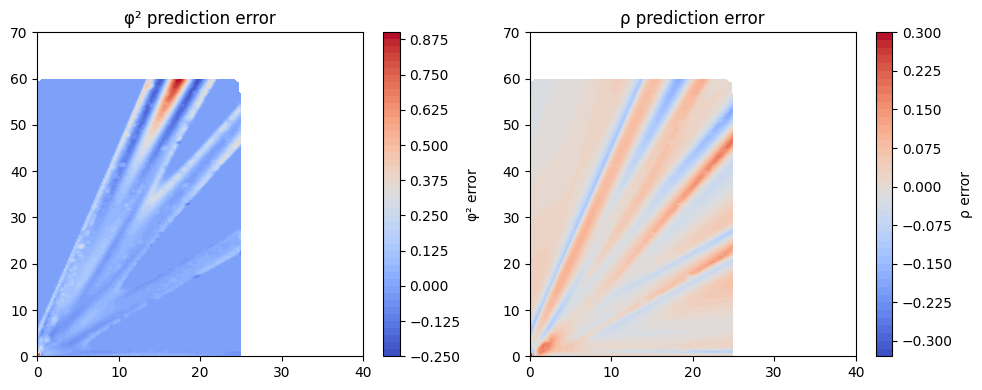

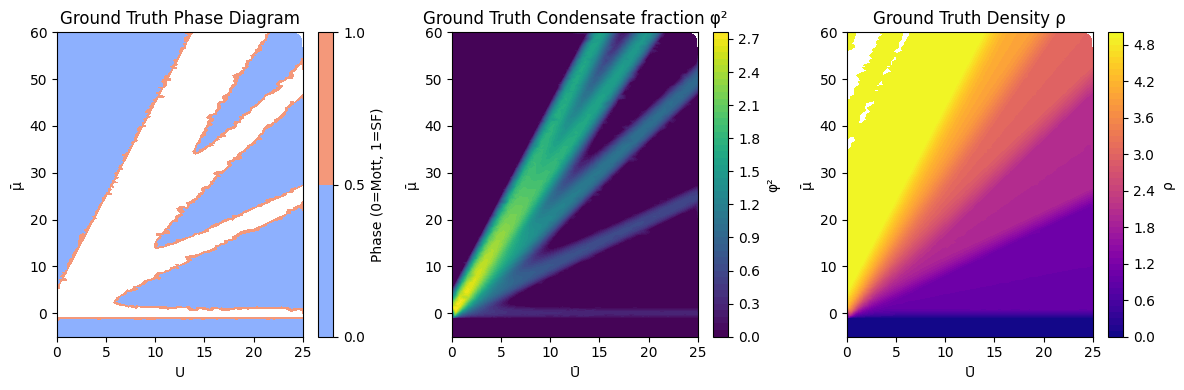


📊 Classification Report (Phase):
              precision    recall  f1-score   support

           0     0.9379    0.9848    0.9608      5000
           1     0.9860    0.9426    0.9638      5684

    accuracy                         0.9624     10684
   macro avg     0.9620    0.9637    0.9623     10684
weighted avg     0.9635    0.9624    0.9624     10684



C:\Users\DELL\AppData\Local\Temp\ipykernel_21340\2640163787.py:428: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_true_labels = df["Phase"].astype(int).ravel()


In [1]:
# Callback to ramp lam_phys in model.loss via attribute; implement as example where model has attribute lam_phys
import tensorflow as tf

class LambdaRamp(tf.keras.callbacks.Callback):
    def __init__(self, start_epoch, end_epoch, final_value):
        self.start = start_epoch
        self.end = end_epoch
        self.final = final_value
    def on_epoch_begin(self, epoch, logs=None):
        if epoch < self.start:
            val = 0.0
        elif epoch >= self.end:
            val = self.final
        else:
            val = (epoch - self.start)/(self.end - self.start) * self.final
        # store in model for your physics loss lambda to read
        setattr(self.model, "lam_phys_current", float(val))
        # optional logging
        print(f"Epoch {epoch}: lam_phys_current={val:.6f}")

# Modify physics loss lambda in compile to read model.lam_phys_current; easiest: implement phys loss using closure that reads model attribute
# Example usage:
ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
# pass ramp_cb to fit callbacks
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from pytorch_tabnet.tab_model import TabNetClassifier


# Label: 1 = Superfluid, 0 = Mott
def label_phase(rho, phi2, tol_rho=1e-3, tol_phi=1e-6):
    """
    Classify phase:
    - Mott insulator if (rho ~ integer) and (phi^2 ~ 0).
    - Superfluid otherwise.
    """
    is_integer_rho = np.isclose(rho, np.round(rho), atol=tol_rho)
    is_zero_phi = phi2 < tol_phi
    
    if is_integer_rho and is_zero_phi:
        return 0  # Mott
    else:
        return 1  # Superfluid

        
# # ---------- 1) Load and label ----------
# df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# # Label: 1 = Superfluid, 0 = Mott
# df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

# # Features and target: **only** Ubar, Mubar
# X = df[["Ubar", "Mubar"]].copy()
# y = df["Phase"].copy()

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.25, random_state=42,
#     stratify=y
# )


# # Apply physics-based labeling
# df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)

# # Features and target: **only** Ubar, Mubar
# X = df[["Ubar", "Mubar"]].copy()
# y = df["Phase"].copy()

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.25, random_state=42,
#     stratify=y
# )

# ---------- 1) Load and label ----------
df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Apply physics-based labeling (optional, but consistent)
df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)




# --- pick deep MI (phi2 ≈ 0, density ~ integer) ---



df_MI = df[
    (df["Phi2"] < 1e-8) &
    (np.isclose(df["Density"], np.round(df["Density"]), atol=1e-3))
]

# --- pick deep SF (large phi2) ---
df_SF = df[df["Phi2"] > 1e-2]

# --- pick boundary (ambiguous region) ---
df_boundary = df[
    (df["Phi2"] > 1e-6) & (df["Phi2"] < 1e-2)
]

# ------------------------------
# Smart sampling strategy
# ------------------------------
# n_MI = min(2000, len(df_MI))             # cap deep MI
# n_SF = min(2000, len(df_SF))             # cap deep SF
# n_boundary = min(6000, len(df_boundary)) # oversample boundary

n_MI = min(5000, len(df_MI))
n_SF = min(5000, len(df_SF))
n_boundary = min(10000, len(df_boundary))


df_reduced = pd.concat([
    df_MI.sample(n_MI, random_state=42),
    df_SF.sample(n_SF, random_state=42),
    df_boundary.sample(n_boundary, random_state=42)
])
print(df)
df_reduced = df_reduced.reset_index(drop=True)
# Use reduced dataset
df = df_reduced.reset_index(drop=True)
print(df)


print("Reduced dataset summary:")
print(df_reduced["Phase"].value_counts())

# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")

# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()

# --- 1) Load data ---
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# # Load dataset
# df = reduced_df

print(df)

# Features and targets
X = df[["Ubar","Mubar"]].values.astype(np.float32)
y = {
    "phase": df["Phase"].values.astype(np.float32),
    "phi2": df["Phi2"].values.astype(np.float32),
    "rho": df["Density"].values.astype(np.float32),
}

# --- 2) Train surrogate model ---
def build_surrogate(hidden=(128,64)):
    inp = keras.Input(shape=(2,))
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="relu")(x)
    out = layers.Dense(2, activation="linear")(x)   # [phi2, rho]
    m = keras.Model(inp, out)
    m.compile(optimizer="adam", loss="mse")
    return m

X_surr = df[["Ubar","Mubar"]].values.astype(np.float32)
y_surr = df[["Phi2","Density"]].values.astype(np.float32)

surrogate = build_surrogate()
surrogate.fit(
    X_surr, y_surr,
    epochs=200, batch_size=512,
    validation_split=0.15, verbose=1
)

# Surrogate validation
from sklearn.metrics import mean_squared_error, mean_absolute_error
X_val = X_surr[-500:]   # or better: shuffle and split properly
y_val = y_surr[-500:]
y_pred = surrogate.predict(X_val)
print("Surrogate MSE:", mean_squared_error(y_val, y_pred))
print("Surrogate MAE:", mean_absolute_error(y_val, y_pred))

# parity plot
import matplotlib.pyplot as plt
plt.scatter(y_val[:,0], y_pred[:,0], s=6); plt.xlabel("true phi2"); plt.ylabel("pred phi2"); plt.title("Surrogate phi2 parity")
plt.plot([y_val[:,0].min(), y_val[:,0].max()],[y_val[:,0].min(), y_val[:,0].max()], 'k--'); plt.show()


# Save & reload in new Keras format
surrogate.save("surrogate_phi_rho.keras")
surrogate = keras.models.load_model("surrogate_phi_rho.keras", compile=False)
surrogate.trainable = False   # freeze surrogate

# --- 3) PINN with surrogate residual ---
def make_pinn_with_surrogate(hidden=(128,64), lam_phase=1.0, lam_phys=1.0):
    inp = keras.Input(shape=(2,), name="input")   # [Ubar, Mubar]
    lam_phys_var = tf.Variable(lam_phys, trainable=False, dtype=tf.float32, name="lam_phys")
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="tanh")(x)

    phase_out = layers.Dense(1, activation="sigmoid", name="phase")(x)
    phi_out   = layers.Dense(1, activation="relu", name="phi2")(x)
    rho_out   = layers.Dense(1, activation="relu", name="rho")(x)

    # Physics residual via surrogate
    def phys_residual(inputs):
        UMb, phi_pred = inputs[0], inputs[1]
        s = surrogate(UMb)                  # surrogate predictions [phi2, rho]
        s_phi = tf.expand_dims(s[:, 0], -1) # only phi2
        return phi_pred - s_phi

    phys_out = layers.Lambda(
        lambda t: phys_residual([t[0], t[1]]),
        name="phys_res"
    )([inp, phi_out])

    model = keras.Model(inputs=inp, outputs=[phase_out, phi_out, rho_out, phys_out])

    losses = {
        "phase": "binary_crossentropy",
        "phi2": "mse",
        "rho": "mse",
        "phys_res": lambda y_true, y_pred: lam_phys_var * tf.reduce_mean(tf.square(y_pred))
    }
    loss_weights = {"phase": lam_phase, "phi2": 1.0, "rho": 1.0, "phys_res": 1.0}

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss=losses,
        loss_weights=loss_weights,
        metrics={"phase":"accuracy"}
    )
    model.lam_phys = lam_phys_var
    return model

pinn_surrogate = make_pinn_with_surrogate()

# --- 4) Train PINN ---
y_targets = {
    "phase": df["Phase"].values.reshape(-1,1).astype(np.float32),
    "phi2":  df["Phi2"].values.reshape(-1,1).astype(np.float32),
    "rho":   df["Density"].values.reshape(-1,1).astype(np.float32),
    "phys_res": np.zeros((len(df),1), dtype=np.float32)
}


def mc_predict(model, X, n=50):
    preds = []
    for _ in range(n):
        p = model(X, training=True)  # keep dropout active
        preds.append(p[0].numpy())   # phase output
    preds = np.stack(preds, axis=0)
    return preds.mean(0), preds.std(0)

    
ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
history = pinn_surrogate.fit(
    X, y_targets,
    batch_size=256,
    epochs=200,
    validation_split=0.15,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(patience=8, factor=0.5),ramp_cb
        # keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True)
    ]
)

# --- 5) Phase diagram prediction ---
U_vals = np.linspace(0, 40, 200)   # Ū axis
mu_vals = np.linspace(0, 70, 200)  # μ̄ axis
UU, MU = np.meshgrid(U_vals, mu_vals)
X_grid = np.stack([UU.ravel(), MU.ravel()], axis=1).astype(np.float32)

# Predict → 4 outputs
y_pred_grid = pinn_surrogate.predict(X_grid, verbose=0)
phase_pred, phi2_pred, rho_pred, _ = y_pred_grid

phase_pred = phase_pred.reshape(UU.shape)
phi2_pred  = phi2_pred.reshape(UU.shape)
rho_pred   = rho_pred.reshape(UU.shape)
phase_pred_class = (phase_pred > 0.5).astype(int)

plt.figure(figsize=(12,4))

# --- Phase diagram ---
plt.subplot(1,3,1)
mappable = plt.contourf(UU, MU, phase_pred_class,
                        levels=[-0.5, 0.5, 1.5], cmap="coolwarm")
plt.colorbar(mappable, ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
plt.contour(UU, MU, phase_pred, levels=[0.5], colors="k", linewidths=1.2)  # phase boundary
plt.xlabel("U",fontsize=10,fontweight="bold")
plt.ylabel("μ̄",fontsize=10, fontweight="bold")
plt.title("Phase Diagram",fontsize=12, fontweight="bold")
plt.grid(True)
plt.savefig('10k-extra-Pinn-keras-pred', dpi=300, bbox_inches='tight')

# --- φ² diagram ---
plt.subplot(1,3,2)
mappable = plt.contourf(UU, MU, phi2_pred, 50, cmap="viridis")
plt.colorbar(mappable, label="φ²")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Condensate fraction φ²")

# --- ρ diagram ---
plt.subplot(1,3,3)
mappable = plt.contourf(UU, MU, rho_pred, 50, cmap="plasma")
plt.colorbar(mappable, label="ρ")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Density ρ")

plt.tight_layout()
plt.show()

from scipy.interpolate import griddata

# Ground truth values
points = df[["Ubar","Mubar"]].values
phi2_true_interp = griddata(points, df["Phi2"].values, (UU, MU), method="linear")
rho_true_interp  = griddata(points, df["Density"].values, (UU, MU), method="linear")

# Compute errors on grid
phi2_err = phi2_pred - phi2_true_interp
rho_err  = rho_pred - rho_true_interp

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.contourf(UU, MU, phi2_err, 50, cmap="coolwarm")
plt.colorbar(label="φ² error")
plt.title("φ² prediction error")

plt.subplot(1,2,2)
plt.contourf(UU, MU, rho_err, 50, cmap="coolwarm")
plt.colorbar(label="ρ error")
plt.title("ρ prediction error")
plt.tight_layout(); plt.show()



# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("U")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")


# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()


# --- 6) Classification report ---
y_pred_phase, y_pred_phi2, y_pred_rho, _ = pinn_surrogate.predict(X, verbose=0)
y_pred_labels = (y_pred_phase > 0.5).astype(int).ravel()
y_true_labels = df["Phase"].astype(int).ravel()

print("\n📊 Classification Report (Phase):")
print(classification_report(y_true_labels, y_pred_labels, digits=4))



# 30k

          t  Ubar  Mubar       Density          Phi2        Energy  Iters  \
0       1.0   0.0   -5.0  1.048576e-14  1.048576e-14  2.097152e-13      8   
1       1.0   0.0   -4.9  1.508449e-14  1.508449e-14  2.882646e-13      8   
2       1.0   0.0   -4.8  2.186340e-14  2.186340e-14  3.987884e-13      8   
3       1.0   0.0   -4.7  3.193733e-14  3.193733e-14  5.553901e-13      8   
4       1.0   0.0   -4.6  4.703477e-14  4.703477e-14  7.788958e-13      8   
...     ...   ...    ...           ...           ...           ...    ...   
163396  1.0  25.0   59.6  3.000000e+00  8.530376e-13 -1.038000e+02     21   
163397  1.0  25.0   59.7  3.000000e+00  7.586920e-13 -1.041000e+02     21   
163398  1.0  25.0   59.8  3.000000e+00  6.791729e-13 -1.044000e+02     21   
163399  1.0  25.0   59.9  3.000000e+00  6.119027e-13 -1.047000e+02     21   
163400  1.0  25.0   60.0  3.000000e+00  5.548081e-13 -1.050000e+02     21   

        Phase  
0           0  
1           0  
2           0  
3          

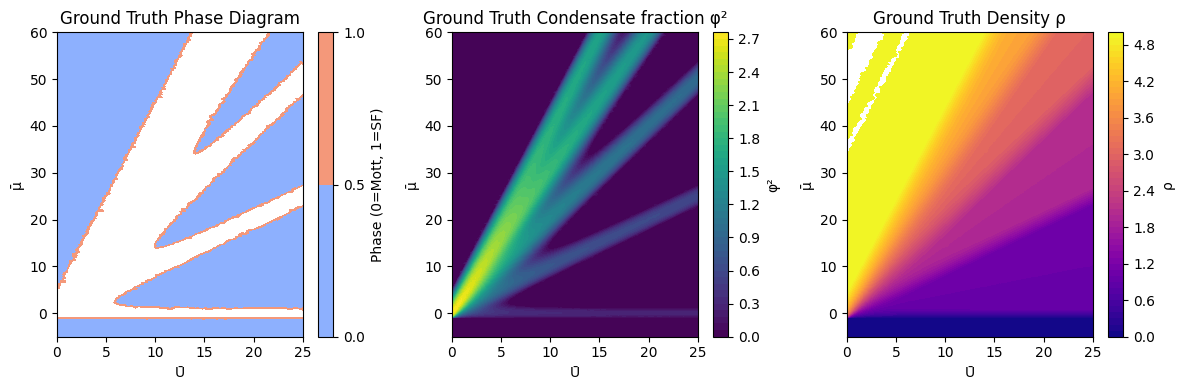

         t  Ubar  Mubar       Density          Phi2        Energy  Iters  \
0      1.0  24.4   13.4  1.000000e+00  6.034134e-14 -1.340000e+01      9   
1      1.0  16.0   -1.1  8.624612e-11  8.624612e-11  9.487073e-12    101   
2      1.0  22.4    6.0  1.000000e+00  5.328648e-14 -6.000000e+00     10   
3      1.0  14.2   22.4  2.000000e+00  6.649626e-12 -3.060000e+01     37   
4      1.0  22.0    7.5  1.000000e+00  1.363996e-14 -7.500000e+00     10   
...    ...   ...    ...           ...           ...           ...    ...   
30679  1.0   3.6   -1.0  8.456767e-05  8.456471e-05  4.598585e-09   4589   
30680  1.0   5.3   26.2  4.999955e+00  2.254263e-04 -7.800000e+01   7465   
30681  1.0  10.9   17.5  2.000244e+00  2.100670e-03 -2.410000e+01   2451   
30682  1.0  16.3   -1.0  6.803388e-05  6.803021e-05  4.123775e-09   4118   
30683  1.0   5.1   25.4  4.999955e+00  2.261209e-04 -7.600000e+01   7477   

       Phase  
0          0  
1          0  
2          0  
3          0  
4          0

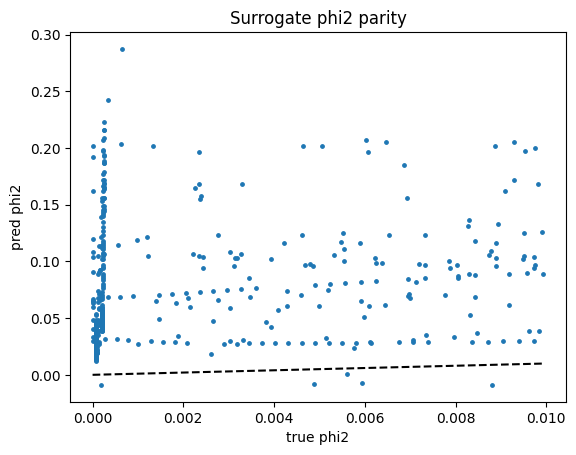

Epoch 0: lam_phys_current=0.000000
Epoch 1/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.4660 - phase_accuracy: 0.6637 - phase_loss: 0.6155 - phi2_loss: 0.2298 - phys_res_loss: 0.2295 - rho_loss: 1.3893 - val_loss: 1.1667 - val_phase_accuracy: 0.6661 - val_phase_loss: 0.6690 - val_phi2_loss: 0.2176 - val_phys_res_loss: 0.2035 - val_rho_loss: 0.0771 - learning_rate: 0.0010
Epoch 1: lam_phys_current=0.000000
Epoch 2/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7476 - phase_accuracy: 0.8225 - phase_loss: 0.4680 - phi2_loss: 0.1174 - phys_res_loss: 0.1159 - rho_loss: 0.0462 - val_loss: 0.9199 - val_phase_accuracy: 0.7717 - val_phase_loss: 0.5182 - val_phi2_loss: 0.1811 - val_phys_res_loss: 0.1684 - val_rho_loss: 0.0525 - learning_rate: 0.0010
Epoch 2: lam_phys_current=0.000000
Epoch 3/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5543 - phase_accuracy: 0.8487 - phase_loss: 0.3667 - phi2_loss: 0.0808 - phys_res_loss: 0.0785 - rho_loss: 0.0282 - val_loss: 0.8247 -

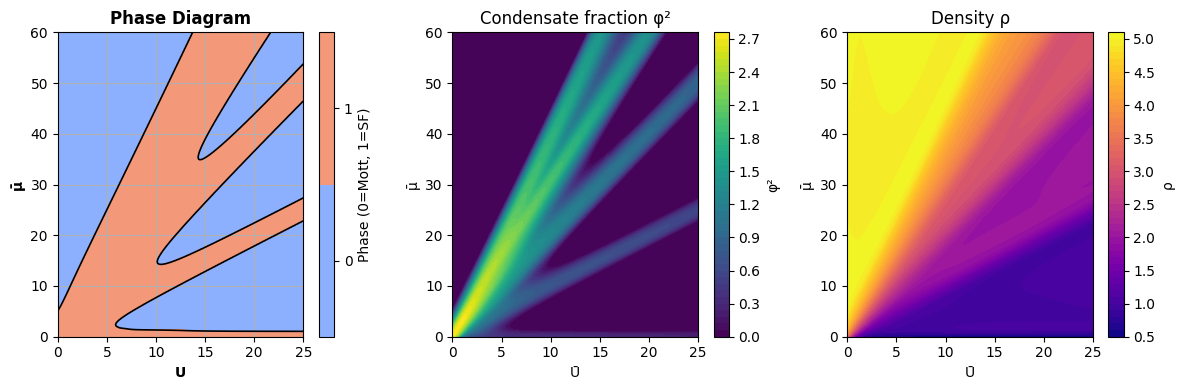

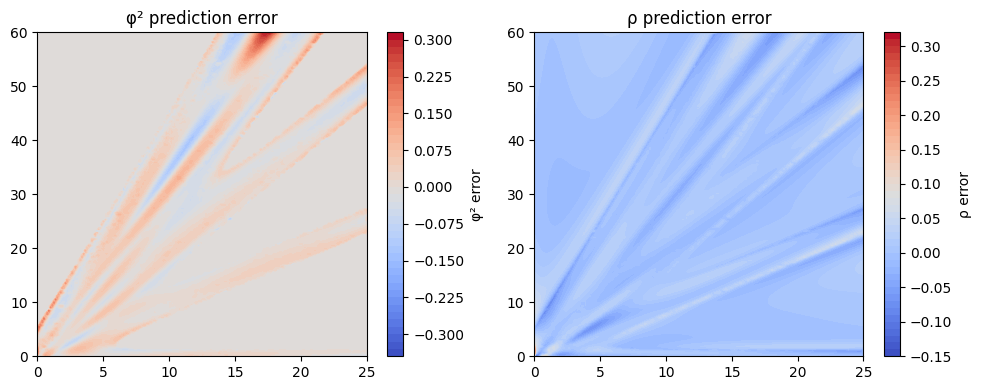

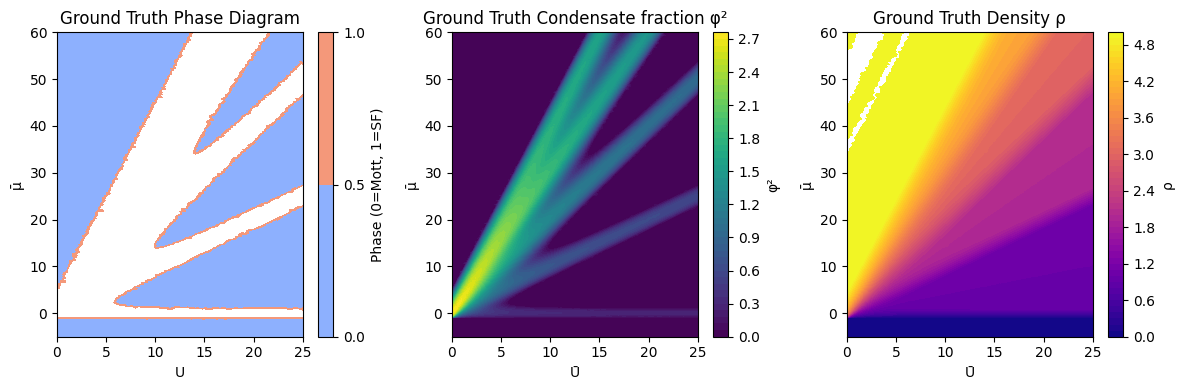


📊 Classification Report (Phase):
              precision    recall  f1-score   support

           0     0.9830    0.9987    0.9908     15000
           1     0.9987    0.9835    0.9910     15684

    accuracy                         0.9909     30684
   macro avg     0.9909    0.9911    0.9909     30684
weighted avg     0.9910    0.9909    0.9909     30684



C:\Users\DELL\AppData\Local\Temp\ipykernel_6640\3721186053.py:428: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_true_labels = df["Phase"].astype(int).ravel()


In [25]:
# Callback to ramp lam_phys in model.loss via attribute; implement as example where model has attribute lam_phys
import tensorflow as tf

class LambdaRamp(tf.keras.callbacks.Callback):
    def __init__(self, start_epoch, end_epoch, final_value):
        self.start = start_epoch
        self.end = end_epoch
        self.final = final_value
    def on_epoch_begin(self, epoch, logs=None):
        if epoch < self.start:
            val = 0.0
        elif epoch >= self.end:
            val = self.final
        else:
            val = (epoch - self.start)/(self.end - self.start) * self.final
        # store in model for your physics loss lambda to read
        setattr(self.model, "lam_phys_current", float(val))
        # optional logging
        print(f"Epoch {epoch}: lam_phys_current={val:.6f}")

# Modify physics loss lambda in compile to read model.lam_phys_current; easiest: implement phys loss using closure that reads model attribute
# Example usage:
ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
# pass ramp_cb to fit callbacks
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from pytorch_tabnet.tab_model import TabNetClassifier


# Label: 1 = Superfluid, 0 = Mott
def label_phase(rho, phi2, tol_rho=1e-3, tol_phi=1e-6):
    """
    Classify phase:
    - Mott insulator if (rho ~ integer) and (phi^2 ~ 0).
    - Superfluid otherwise.
    """
    is_integer_rho = np.isclose(rho, np.round(rho), atol=tol_rho)
    is_zero_phi = phi2 < tol_phi
    
    if is_integer_rho and is_zero_phi:
        return 0  # Mott
    else:
        return 1  # Superfluid

        
# # ---------- 1) Load and label ----------
# df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# # Label: 1 = Superfluid, 0 = Mott
# df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

# # Features and target: **only** Ubar, Mubar
# X = df[["Ubar", "Mubar"]].copy()
# y = df["Phase"].copy()

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.25, random_state=42,
#     stratify=y
# )


# # Apply physics-based labeling
# df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)

# # Features and target: **only** Ubar, Mubar
# X = df[["Ubar", "Mubar"]].copy()
# y = df["Phase"].copy()

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.25, random_state=42,
#     stratify=y
# )

# ---------- 1) Load and label ----------
df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Apply physics-based labeling (optional, but consistent)
df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)




# --- pick deep MI (phi2 ≈ 0, density ~ integer) ---



df_MI = df[
    (df["Phi2"] < 1e-8) &
    (np.isclose(df["Density"], np.round(df["Density"]), atol=1e-3))
]

# --- pick deep SF (large phi2) ---
df_SF = df[df["Phi2"] > 1e-2]

# --- pick boundary (ambiguous region) ---
df_boundary = df[
    (df["Phi2"] > 1e-6) & (df["Phi2"] < 1e-2)
]

# ------------------------------
# Smart sampling strategy
# ------------------------------
# n_MI = min(2000, len(df_MI))             # cap deep MI
# n_SF = min(2000, len(df_SF))             # cap deep SF
# n_boundary = min(6000, len(df_boundary)) # oversample boundary

n_MI = min(15000, len(df_MI))
n_SF = min(15000, len(df_SF))
n_boundary = min(30000, len(df_boundary))


df_reduced = pd.concat([
    df_MI.sample(n_MI, random_state=42),
    df_SF.sample(n_SF, random_state=42),
    df_boundary.sample(n_boundary, random_state=42)
])
print(df)
df_reduced = df_reduced.reset_index(drop=True)
# Use reduced dataset
df = df_reduced.reset_index(drop=True)
print(df)


print("Reduced dataset summary:")
print(df_reduced["Phase"].value_counts())

# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")

# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()

# --- 1) Load data ---
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# # Load dataset
# df = reduced_df

print(df)

# Features and targets
X = df[["Ubar","Mubar"]].values.astype(np.float32)
y = {
    "phase": df["Phase"].values.astype(np.float32),
    "phi2": df["Phi2"].values.astype(np.float32),
    "rho": df["Density"].values.astype(np.float32),
}

# --- 2) Train surrogate model ---
def build_surrogate(hidden=(128,64)):
    inp = keras.Input(shape=(2,))
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="relu")(x)
    out = layers.Dense(2, activation="linear")(x)   # [phi2, rho]
    m = keras.Model(inp, out)
    m.compile(optimizer="adam", loss="mse")
    return m

X_surr = df[["Ubar","Mubar"]].values.astype(np.float32)
y_surr = df[["Phi2","Density"]].values.astype(np.float32)

surrogate = build_surrogate()
surrogate.fit(
    X_surr, y_surr,
    epochs=200, batch_size=512,
    validation_split=0.15, verbose=1
)

# Surrogate validation
from sklearn.metrics import mean_squared_error, mean_absolute_error
X_val = X_surr[-500:]   # or better: shuffle and split properly
y_val = y_surr[-500:]
y_pred = surrogate.predict(X_val)
print("Surrogate MSE:", mean_squared_error(y_val, y_pred))
print("Surrogate MAE:", mean_absolute_error(y_val, y_pred))

# parity plot
import matplotlib.pyplot as plt
plt.scatter(y_val[:,0], y_pred[:,0], s=6); plt.xlabel("true phi2"); plt.ylabel("pred phi2"); plt.title("Surrogate phi2 parity")
plt.plot([y_val[:,0].min(), y_val[:,0].max()],[y_val[:,0].min(), y_val[:,0].max()], 'k--'); plt.show()


# Save & reload in new Keras format
surrogate.save("surrogate_phi_rho.keras")
surrogate = keras.models.load_model("surrogate_phi_rho.keras", compile=False)
surrogate.trainable = False   # freeze surrogate

# --- 3) PINN with surrogate residual ---
def make_pinn_with_surrogate(hidden=(128,64), lam_phase=1.0, lam_phys=1.0):
    inp = keras.Input(shape=(2,), name="input")   # [Ubar, Mubar]
    lam_phys_var = tf.Variable(lam_phys, trainable=False, dtype=tf.float32, name="lam_phys")
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="tanh")(x)

    phase_out = layers.Dense(1, activation="sigmoid", name="phase")(x)
    phi_out   = layers.Dense(1, activation="relu", name="phi2")(x)
    rho_out   = layers.Dense(1, activation="relu", name="rho")(x)

    # Physics residual via surrogate
    def phys_residual(inputs):
        UMb, phi_pred = inputs[0], inputs[1]
        s = surrogate(UMb)                  # surrogate predictions [phi2, rho]
        s_phi = tf.expand_dims(s[:, 0], -1) # only phi2
        return phi_pred - s_phi

    phys_out = layers.Lambda(
        lambda t: phys_residual([t[0], t[1]]),
        name="phys_res"
    )([inp, phi_out])

    model = keras.Model(inputs=inp, outputs=[phase_out, phi_out, rho_out, phys_out])

    losses = {
        "phase": "binary_crossentropy",
        "phi2": "mse",
        "rho": "mse",
        "phys_res": lambda y_true, y_pred: lam_phys_var * tf.reduce_mean(tf.square(y_pred))
    }
    loss_weights = {"phase": lam_phase, "phi2": 1.0, "rho": 1.0, "phys_res": 1.0}

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss=losses,
        loss_weights=loss_weights,
        metrics={"phase":"accuracy"}
    )
    model.lam_phys = lam_phys_var
    return model

pinn_surrogate = make_pinn_with_surrogate()

# --- 4) Train PINN ---
y_targets = {
    "phase": df["Phase"].values.reshape(-1,1).astype(np.float32),
    "phi2":  df["Phi2"].values.reshape(-1,1).astype(np.float32),
    "rho":   df["Density"].values.reshape(-1,1).astype(np.float32),
    "phys_res": np.zeros((len(df),1), dtype=np.float32)
}


def mc_predict(model, X, n=50):
    preds = []
    for _ in range(n):
        p = model(X, training=True)  # keep dropout active
        preds.append(p[0].numpy())   # phase output
    preds = np.stack(preds, axis=0)
    return preds.mean(0), preds.std(0)

    
ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
history = pinn_surrogate.fit(
    X, y_targets,
    batch_size=256,
    epochs=200,
    validation_split=0.15,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(patience=8, factor=0.5),ramp_cb
        # keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True)
    ]
)

# --- 5) Phase diagram prediction ---
U_vals = np.linspace(0, 25, 200)   # Ū axis
mu_vals = np.linspace(0, 60, 200)  # μ̄ axis
UU, MU = np.meshgrid(U_vals, mu_vals)
X_grid = np.stack([UU.ravel(), MU.ravel()], axis=1).astype(np.float32)

# Predict → 4 outputs
y_pred_grid = pinn_surrogate.predict(X_grid, verbose=0)
phase_pred, phi2_pred, rho_pred, _ = y_pred_grid

phase_pred = phase_pred.reshape(UU.shape)
phi2_pred  = phi2_pred.reshape(UU.shape)
rho_pred   = rho_pred.reshape(UU.shape)
phase_pred_class = (phase_pred > 0.5).astype(int)

plt.figure(figsize=(12,4))

# --- Phase diagram ---
plt.subplot(1,3,1)
mappable = plt.contourf(UU, MU, phase_pred_class,
                        levels=[-0.5, 0.5, 1.5], cmap="coolwarm")
plt.colorbar(mappable, ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
plt.contour(UU, MU, phase_pred, levels=[0.5], colors="k", linewidths=1.2)  # phase boundary
plt.xlabel("U",fontsize=10,fontweight="bold")
plt.ylabel("μ̄",fontsize=10, fontweight="bold")
plt.title("Phase Diagram",fontsize=12, fontweight="bold")
plt.grid(True)
plt.savefig('30k-Pinn-keras-pred', dpi=300, bbox_inches='tight')

# --- φ² diagram ---
plt.subplot(1,3,2)
mappable = plt.contourf(UU, MU, phi2_pred, 50, cmap="viridis")
plt.colorbar(mappable, label="φ²")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Condensate fraction φ²")

# --- ρ diagram ---
plt.subplot(1,3,3)
mappable = plt.contourf(UU, MU, rho_pred, 50, cmap="plasma")
plt.colorbar(mappable, label="ρ")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Density ρ")

plt.tight_layout()
plt.show()

from scipy.interpolate import griddata

# Ground truth values
points = df[["Ubar","Mubar"]].values
phi2_true_interp = griddata(points, df["Phi2"].values, (UU, MU), method="linear")
rho_true_interp  = griddata(points, df["Density"].values, (UU, MU), method="linear")

# Compute errors on grid
phi2_err = phi2_pred - phi2_true_interp
rho_err  = rho_pred - rho_true_interp

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.contourf(UU, MU, phi2_err, 50, cmap="coolwarm")
plt.colorbar(label="φ² error")
plt.title("φ² prediction error")

plt.subplot(1,2,2)
plt.contourf(UU, MU, rho_err, 50, cmap="coolwarm")
plt.colorbar(label="ρ error")
plt.title("ρ prediction error")
plt.tight_layout(); plt.show()



# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("U")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")


# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()


# --- 6) Classification report ---
y_pred_phase, y_pred_phi2, y_pred_rho, _ = pinn_surrogate.predict(X, verbose=0)
y_pred_labels = (y_pred_phase > 0.5).astype(int).ravel()
y_true_labels = df["Phase"].astype(int).ravel()

print("\n📊 Classification Report (Phase):")
print(classification_report(y_true_labels, y_pred_labels, digits=4))



# 30k extra

          t  Ubar  Mubar       Density          Phi2        Energy  Iters  \
0       1.0   0.0   -5.0  1.048576e-14  1.048576e-14  2.097152e-13      8   
1       1.0   0.0   -4.9  1.508449e-14  1.508449e-14  2.882646e-13      8   
2       1.0   0.0   -4.8  2.186340e-14  2.186340e-14  3.987884e-13      8   
3       1.0   0.0   -4.7  3.193733e-14  3.193733e-14  5.553901e-13      8   
4       1.0   0.0   -4.6  4.703477e-14  4.703477e-14  7.788958e-13      8   
...     ...   ...    ...           ...           ...           ...    ...   
163396  1.0  25.0   59.6  3.000000e+00  8.530376e-13 -1.038000e+02     21   
163397  1.0  25.0   59.7  3.000000e+00  7.586920e-13 -1.041000e+02     21   
163398  1.0  25.0   59.8  3.000000e+00  6.791729e-13 -1.044000e+02     21   
163399  1.0  25.0   59.9  3.000000e+00  6.119027e-13 -1.047000e+02     21   
163400  1.0  25.0   60.0  3.000000e+00  5.548081e-13 -1.050000e+02     21   

        Phase  
0           0  
1           0  
2           0  
3          

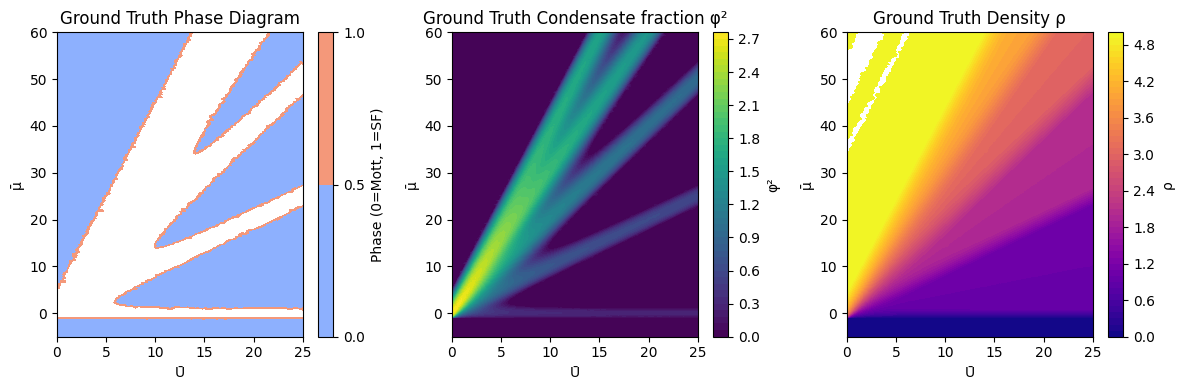

         t  Ubar  Mubar       Density          Phi2        Energy  Iters  \
0      1.0  24.4   13.4  1.000000e+00  6.034134e-14 -1.340000e+01      9   
1      1.0  16.0   -1.1  8.624612e-11  8.624612e-11  9.487073e-12    101   
2      1.0  22.4    6.0  1.000000e+00  5.328648e-14 -6.000000e+00     10   
3      1.0  14.2   22.4  2.000000e+00  6.649626e-12 -3.060000e+01     37   
4      1.0  22.0    7.5  1.000000e+00  1.363996e-14 -7.500000e+00     10   
...    ...   ...    ...           ...           ...           ...    ...   
30679  1.0   3.6   -1.0  8.456767e-05  8.456471e-05  4.598585e-09   4589   
30680  1.0   5.3   26.2  4.999955e+00  2.254263e-04 -7.800000e+01   7465   
30681  1.0  10.9   17.5  2.000244e+00  2.100670e-03 -2.410000e+01   2451   
30682  1.0  16.3   -1.0  6.803388e-05  6.803021e-05  4.123775e-09   4118   
30683  1.0   5.1   25.4  4.999955e+00  2.261209e-04 -7.600000e+01   7477   

       Phase  
0          0  
1          0  
2          0  
3          0  
4          0

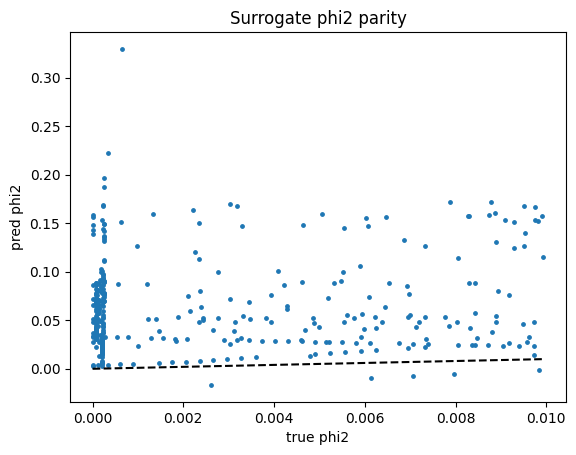

Epoch 0: lam_phys_current=0.000000
Epoch 1/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2.2719 - phase_accuracy: 0.6776 - phase_loss: 0.6072 - phi2_loss: 0.6096 - phys_res_loss: 0.5916 - rho_loss: 0.4630 - val_loss: 3.2015 - val_phase_accuracy: 0.6620 - val_phase_loss: 0.6989 - val_phi2_loss: 1.2384 - val_phys_res_loss: 1.2004 - val_rho_loss: 0.0616 - learning_rate: 0.0010
Epoch 1: lam_phys_current=0.000000
Epoch 2/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7012 - phase_accuracy: 0.8041 - phase_loss: 0.4661 - phi2_loss: 0.6094 - phys_res_loss: 0.5914 - rho_loss: 0.0345 - val_loss: 3.0517 - val_phase_accuracy: 0.6932 - val_phase_loss: 0.5668 - val_phi2_loss: 1.2384 - val_phys_res_loss: 1.2004 - val_rho_loss: 0.0439 - learning_rate: 0.0010
Epoch 2: lam_phys_current=0.000000
Epoch 3/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5897 - phase_accuracy: 0.8335 - phase_loss: 0.3662 - phi2_loss: 0.6093 - phys_res_loss: 0.5913 - rho_loss: 0.0229 - val_loss: 2.9083 -

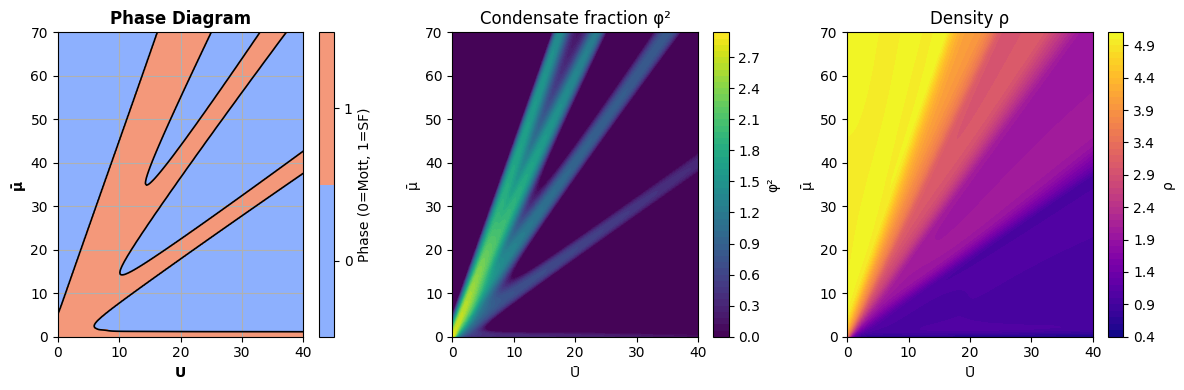

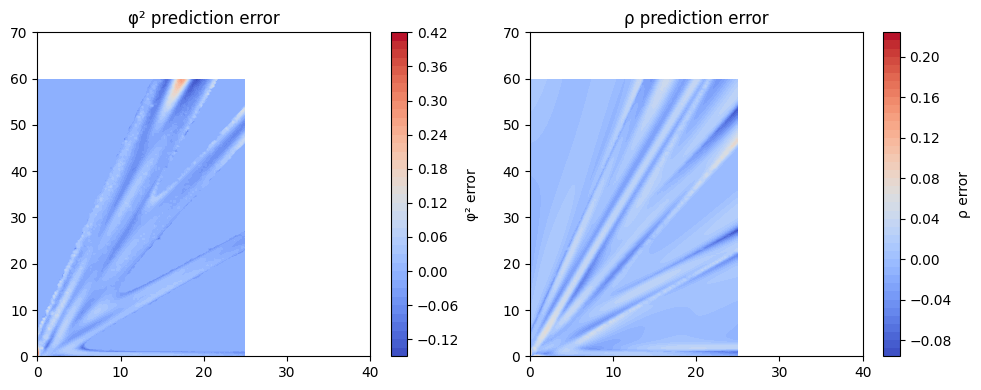

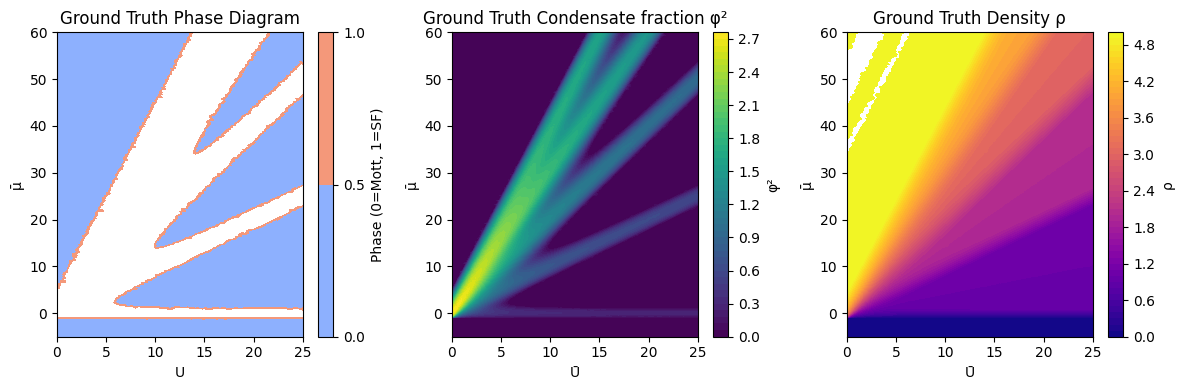


📊 Classification Report (Phase):
              precision    recall  f1-score   support

           0     0.9800    0.9984    0.9891     15000
           1     0.9984    0.9806    0.9894     15684

    accuracy                         0.9893     30684
   macro avg     0.9892    0.9895    0.9893     30684
weighted avg     0.9894    0.9893    0.9893     30684



C:\Users\DELL\AppData\Local\Temp\ipykernel_21340\120478261.py:428: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_true_labels = df["Phase"].astype(int).ravel()


In [2]:
# Callback to ramp lam_phys in model.loss via attribute; implement as example where model has attribute lam_phys
import tensorflow as tf

class LambdaRamp(tf.keras.callbacks.Callback):
    def __init__(self, start_epoch, end_epoch, final_value):
        self.start = start_epoch
        self.end = end_epoch
        self.final = final_value
    def on_epoch_begin(self, epoch, logs=None):
        if epoch < self.start:
            val = 0.0
        elif epoch >= self.end:
            val = self.final
        else:
            val = (epoch - self.start)/(self.end - self.start) * self.final
        # store in model for your physics loss lambda to read
        setattr(self.model, "lam_phys_current", float(val))
        # optional logging
        print(f"Epoch {epoch}: lam_phys_current={val:.6f}")

# Modify physics loss lambda in compile to read model.lam_phys_current; easiest: implement phys loss using closure that reads model attribute
# Example usage:
ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
# pass ramp_cb to fit callbacks
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from pytorch_tabnet.tab_model import TabNetClassifier


# Label: 1 = Superfluid, 0 = Mott
def label_phase(rho, phi2, tol_rho=1e-3, tol_phi=1e-6):
    """
    Classify phase:
    - Mott insulator if (rho ~ integer) and (phi^2 ~ 0).
    - Superfluid otherwise.
    """
    is_integer_rho = np.isclose(rho, np.round(rho), atol=tol_rho)
    is_zero_phi = phi2 < tol_phi
    
    if is_integer_rho and is_zero_phi:
        return 0  # Mott
    else:
        return 1  # Superfluid

        
# # ---------- 1) Load and label ----------
# df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# # Label: 1 = Superfluid, 0 = Mott
# df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

# # Features and target: **only** Ubar, Mubar
# X = df[["Ubar", "Mubar"]].copy()
# y = df["Phase"].copy()

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.25, random_state=42,
#     stratify=y
# )


# # Apply physics-based labeling
# df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)

# # Features and target: **only** Ubar, Mubar
# X = df[["Ubar", "Mubar"]].copy()
# y = df["Phase"].copy()

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.25, random_state=42,
#     stratify=y
# )

# ---------- 1) Load and label ----------
df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Apply physics-based labeling (optional, but consistent)
df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)




# --- pick deep MI (phi2 ≈ 0, density ~ integer) ---



df_MI = df[
    (df["Phi2"] < 1e-8) &
    (np.isclose(df["Density"], np.round(df["Density"]), atol=1e-3))
]

# --- pick deep SF (large phi2) ---
df_SF = df[df["Phi2"] > 1e-2]

# --- pick boundary (ambiguous region) ---
df_boundary = df[
    (df["Phi2"] > 1e-6) & (df["Phi2"] < 1e-2)
]

# ------------------------------
# Smart sampling strategy
# ------------------------------
# n_MI = min(2000, len(df_MI))             # cap deep MI
# n_SF = min(2000, len(df_SF))             # cap deep SF
# n_boundary = min(6000, len(df_boundary)) # oversample boundary

n_MI = min(15000, len(df_MI))
n_SF = min(15000, len(df_SF))
n_boundary = min(30000, len(df_boundary))


df_reduced = pd.concat([
    df_MI.sample(n_MI, random_state=42),
    df_SF.sample(n_SF, random_state=42),
    df_boundary.sample(n_boundary, random_state=42)
])
print(df)
df_reduced = df_reduced.reset_index(drop=True)
# Use reduced dataset
df = df_reduced.reset_index(drop=True)
print(df)


print("Reduced dataset summary:")
print(df_reduced["Phase"].value_counts())

# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")

# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()

# --- 1) Load data ---
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# # Load dataset
# df = reduced_df

print(df)

# Features and targets
X = df[["Ubar","Mubar"]].values.astype(np.float32)
y = {
    "phase": df["Phase"].values.astype(np.float32),
    "phi2": df["Phi2"].values.astype(np.float32),
    "rho": df["Density"].values.astype(np.float32),
}

# --- 2) Train surrogate model ---
def build_surrogate(hidden=(128,64)):
    inp = keras.Input(shape=(2,))
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="relu")(x)
    out = layers.Dense(2, activation="linear")(x)   # [phi2, rho]
    m = keras.Model(inp, out)
    m.compile(optimizer="adam", loss="mse")
    return m

X_surr = df[["Ubar","Mubar"]].values.astype(np.float32)
y_surr = df[["Phi2","Density"]].values.astype(np.float32)

surrogate = build_surrogate()
surrogate.fit(
    X_surr, y_surr,
    epochs=200, batch_size=512,
    validation_split=0.15, verbose=1
)

# Surrogate validation
from sklearn.metrics import mean_squared_error, mean_absolute_error
X_val = X_surr[-500:]   # or better: shuffle and split properly
y_val = y_surr[-500:]
y_pred = surrogate.predict(X_val)
print("Surrogate MSE:", mean_squared_error(y_val, y_pred))
print("Surrogate MAE:", mean_absolute_error(y_val, y_pred))

# parity plot
import matplotlib.pyplot as plt
plt.scatter(y_val[:,0], y_pred[:,0], s=6); plt.xlabel("true phi2"); plt.ylabel("pred phi2"); plt.title("Surrogate phi2 parity")
plt.plot([y_val[:,0].min(), y_val[:,0].max()],[y_val[:,0].min(), y_val[:,0].max()], 'k--'); plt.show()


# Save & reload in new Keras format
surrogate.save("surrogate_phi_rho.keras")
surrogate = keras.models.load_model("surrogate_phi_rho.keras", compile=False)
surrogate.trainable = False   # freeze surrogate

# --- 3) PINN with surrogate residual ---
def make_pinn_with_surrogate(hidden=(128,64), lam_phase=1.0, lam_phys=1.0):
    inp = keras.Input(shape=(2,), name="input")   # [Ubar, Mubar]
    lam_phys_var = tf.Variable(lam_phys, trainable=False, dtype=tf.float32, name="lam_phys")
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="tanh")(x)

    phase_out = layers.Dense(1, activation="sigmoid", name="phase")(x)
    phi_out   = layers.Dense(1, activation="relu", name="phi2")(x)
    rho_out   = layers.Dense(1, activation="relu", name="rho")(x)

    # Physics residual via surrogate
    def phys_residual(inputs):
        UMb, phi_pred = inputs[0], inputs[1]
        s = surrogate(UMb)                  # surrogate predictions [phi2, rho]
        s_phi = tf.expand_dims(s[:, 0], -1) # only phi2
        return phi_pred - s_phi

    phys_out = layers.Lambda(
        lambda t: phys_residual([t[0], t[1]]),
        name="phys_res"
    )([inp, phi_out])

    model = keras.Model(inputs=inp, outputs=[phase_out, phi_out, rho_out, phys_out])

    losses = {
        "phase": "binary_crossentropy",
        "phi2": "mse",
        "rho": "mse",
        "phys_res": lambda y_true, y_pred: lam_phys_var * tf.reduce_mean(tf.square(y_pred))
    }
    loss_weights = {"phase": lam_phase, "phi2": 1.0, "rho": 1.0, "phys_res": 1.0}

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss=losses,
        loss_weights=loss_weights,
        metrics={"phase":"accuracy"}
    )
    model.lam_phys = lam_phys_var
    return model

pinn_surrogate = make_pinn_with_surrogate()

# --- 4) Train PINN ---
y_targets = {
    "phase": df["Phase"].values.reshape(-1,1).astype(np.float32),
    "phi2":  df["Phi2"].values.reshape(-1,1).astype(np.float32),
    "rho":   df["Density"].values.reshape(-1,1).astype(np.float32),
    "phys_res": np.zeros((len(df),1), dtype=np.float32)
}


def mc_predict(model, X, n=50):
    preds = []
    for _ in range(n):
        p = model(X, training=True)  # keep dropout active
        preds.append(p[0].numpy())   # phase output
    preds = np.stack(preds, axis=0)
    return preds.mean(0), preds.std(0)

    
ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
history = pinn_surrogate.fit(
    X, y_targets,
    batch_size=256,
    epochs=200,
    validation_split=0.15,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(patience=8, factor=0.5),ramp_cb
        # keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True)
    ]
)

# --- 5) Phase diagram prediction ---
U_vals = np.linspace(0, 40, 200)   # Ū axis
mu_vals = np.linspace(0, 70, 200)  # μ̄ axis
UU, MU = np.meshgrid(U_vals, mu_vals)
X_grid = np.stack([UU.ravel(), MU.ravel()], axis=1).astype(np.float32)

# Predict → 4 outputs
y_pred_grid = pinn_surrogate.predict(X_grid, verbose=0)
phase_pred, phi2_pred, rho_pred, _ = y_pred_grid

phase_pred = phase_pred.reshape(UU.shape)
phi2_pred  = phi2_pred.reshape(UU.shape)
rho_pred   = rho_pred.reshape(UU.shape)
phase_pred_class = (phase_pred > 0.5).astype(int)

plt.figure(figsize=(12,4))

# --- Phase diagram ---
plt.subplot(1,3,1)
mappable = plt.contourf(UU, MU, phase_pred_class,
                        levels=[-0.5, 0.5, 1.5], cmap="coolwarm")
plt.colorbar(mappable, ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
plt.contour(UU, MU, phase_pred, levels=[0.5], colors="k", linewidths=1.2)  # phase boundary
plt.xlabel("U",fontsize=10,fontweight="bold")
plt.ylabel("μ̄",fontsize=10, fontweight="bold")
plt.title("Phase Diagram",fontsize=12, fontweight="bold")
plt.grid(True)
plt.savefig('30k-extra-Pinn-keras-pred', dpi=300, bbox_inches='tight')

# --- φ² diagram ---
plt.subplot(1,3,2)
mappable = plt.contourf(UU, MU, phi2_pred, 50, cmap="viridis")
plt.colorbar(mappable, label="φ²")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Condensate fraction φ²")

# --- ρ diagram ---
plt.subplot(1,3,3)
mappable = plt.contourf(UU, MU, rho_pred, 50, cmap="plasma")
plt.colorbar(mappable, label="ρ")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Density ρ")

plt.tight_layout()
plt.show()

from scipy.interpolate import griddata

# Ground truth values
points = df[["Ubar","Mubar"]].values
phi2_true_interp = griddata(points, df["Phi2"].values, (UU, MU), method="linear")
rho_true_interp  = griddata(points, df["Density"].values, (UU, MU), method="linear")

# Compute errors on grid
phi2_err = phi2_pred - phi2_true_interp
rho_err  = rho_pred - rho_true_interp

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.contourf(UU, MU, phi2_err, 50, cmap="coolwarm")
plt.colorbar(label="φ² error")
plt.title("φ² prediction error")

plt.subplot(1,2,2)
plt.contourf(UU, MU, rho_err, 50, cmap="coolwarm")
plt.colorbar(label="ρ error")
plt.title("ρ prediction error")
plt.tight_layout(); plt.show()



# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("U")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")


# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()


# --- 6) Classification report ---
y_pred_phase, y_pred_phi2, y_pred_rho, _ = pinn_surrogate.predict(X, verbose=0)
y_pred_labels = (y_pred_phase > 0.5).astype(int).ravel()
y_true_labels = df["Phase"].astype(int).ravel()

print("\n📊 Classification Report (Phase):")
print(classification_report(y_true_labels, y_pred_labels, digits=4))



# 6k

          t  Ubar  Mubar       Density          Phi2        Energy  Iters  \
0       1.0   0.0   -5.0  1.048576e-14  1.048576e-14  2.097152e-13      8   
1       1.0   0.0   -4.9  1.508449e-14  1.508449e-14  2.882646e-13      8   
2       1.0   0.0   -4.8  2.186340e-14  2.186340e-14  3.987884e-13      8   
3       1.0   0.0   -4.7  3.193733e-14  3.193733e-14  5.553901e-13      8   
4       1.0   0.0   -4.6  4.703477e-14  4.703477e-14  7.788958e-13      8   
...     ...   ...    ...           ...           ...           ...    ...   
163396  1.0  25.0   59.6  3.000000e+00  8.530376e-13 -1.038000e+02     21   
163397  1.0  25.0   59.7  3.000000e+00  7.586920e-13 -1.041000e+02     21   
163398  1.0  25.0   59.8  3.000000e+00  6.791729e-13 -1.044000e+02     21   
163399  1.0  25.0   59.9  3.000000e+00  6.119027e-13 -1.047000e+02     21   
163400  1.0  25.0   60.0  3.000000e+00  5.548081e-13 -1.050000e+02     21   

        Phase  
0           0  
1           0  
2           0  
3          

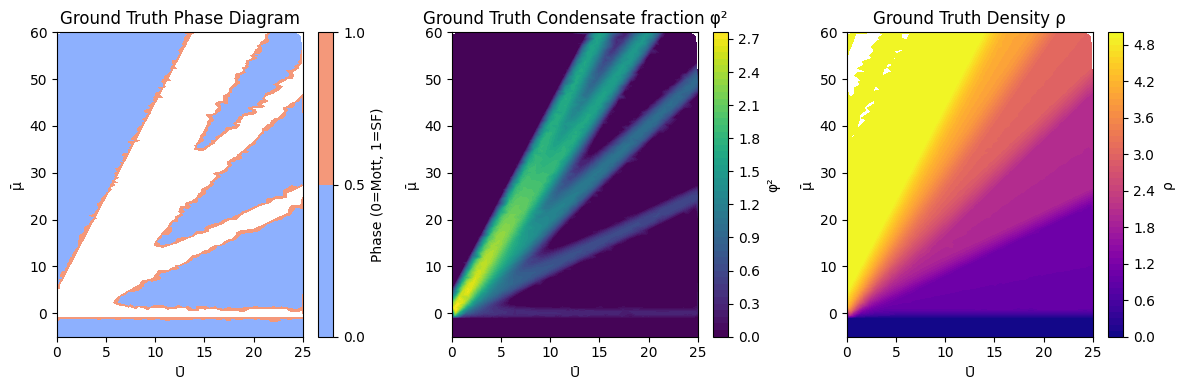

        t  Ubar  Mubar       Density          Phi2        Energy  Iters  Phase
0     1.0  24.4   13.4  1.000000e+00  6.034134e-14 -1.340000e+01      9      0
1     1.0  16.0   -1.1  8.624612e-11  8.624612e-11  9.487073e-12    101      0
2     1.0  22.4    6.0  1.000000e+00  5.328648e-14 -6.000000e+00     10      0
3     1.0  14.2   22.4  2.000000e+00  6.649626e-12 -3.060000e+01     37      0
4     1.0  22.0    7.5  1.000000e+00  1.363996e-14 -7.500000e+00     10      0
...   ...   ...    ...           ...           ...           ...    ...    ...
6679  1.0   3.6   -1.0  8.456767e-05  8.456471e-05  4.598585e-09   4589      1
6680  1.0   5.3   26.2  4.999955e+00  2.254263e-04 -7.800000e+01   7465      1
6681  1.0  10.9   17.5  2.000244e+00  2.100670e-03 -2.410000e+01   2451      1
6682  1.0  16.3   -1.0  6.803388e-05  6.803021e-05  4.123775e-09   4118      1
6683  1.0   5.1   25.4  4.999955e+00  2.261209e-04 -7.600000e+01   7477      1

[6684 rows x 8 columns]
Epoch 1/200
12/12 ━━━━━━━━━

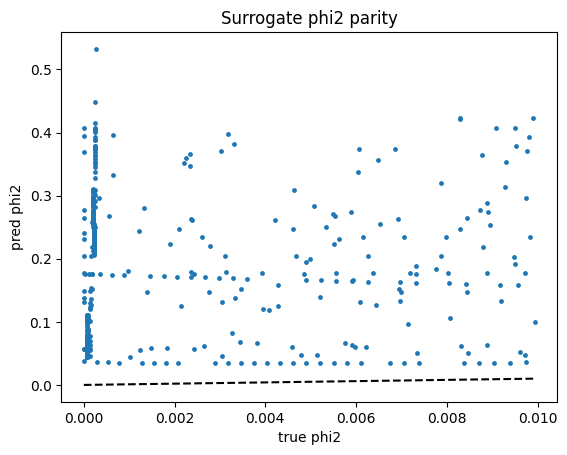

Epoch 0: lam_phys_current=0.000000
Epoch 1/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.5513 - phase_accuracy: 0.4017 - phase_loss: 0.7469 - phi2_loss: 0.7404 - phys_res_loss: 0.7084 - rho_loss: 1.3296 - val_loss: 2.2821 - val_phase_accuracy: 0.0100 - val_phase_loss: 0.9127 - val_phi2_loss: 0.4957 - val_phys_res_loss: 0.4859 - val_rho_loss: 0.3690 - learning_rate: 0.0010
Epoch 1: lam_phys_current=0.000000
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.1252 - phase_accuracy: 0.5768 - phase_loss: 0.6722 - phi2_loss: 0.6719 - phys_res_loss: 0.6369 - rho_loss: 0.1376 - val_loss: 1.9719 - val_phase_accuracy: 0.3539 - val_phase_loss: 0.8196 - val_phi2_loss: 0.4956 - val_phys_res_loss: 0.4861 - val_rho_loss: 0.1520 - learning_rate: 0.0010
Epoch 2: lam_phys_current=0.000000
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.9864 - phase_accuracy: 0.7096 - phase_loss: 0.6068 - phi2_loss: 0.6791 - phys_res_loss: 0.6440 - rho_loss: 0.0689 - val_loss: 1.9134 - val_

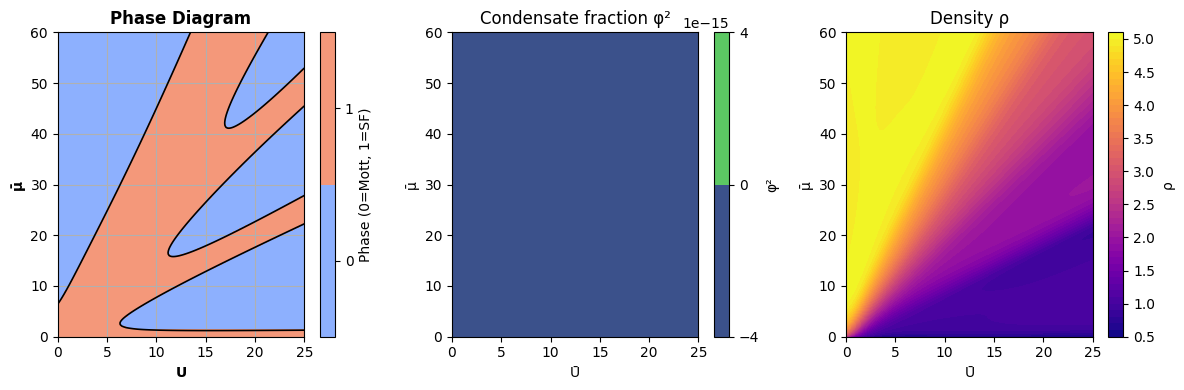

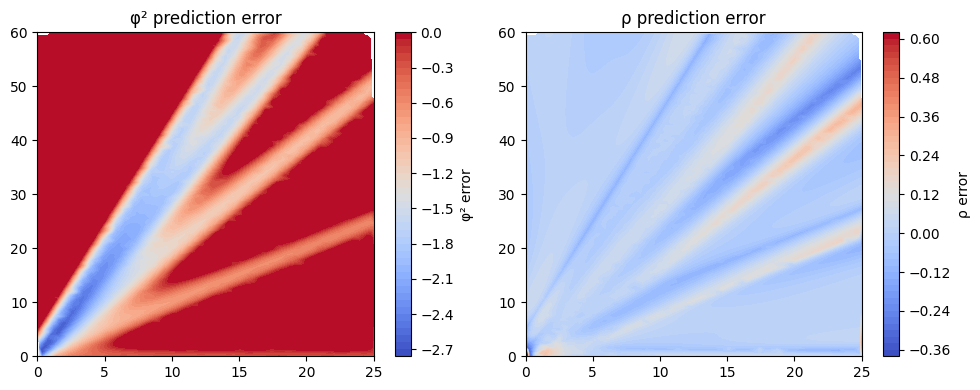

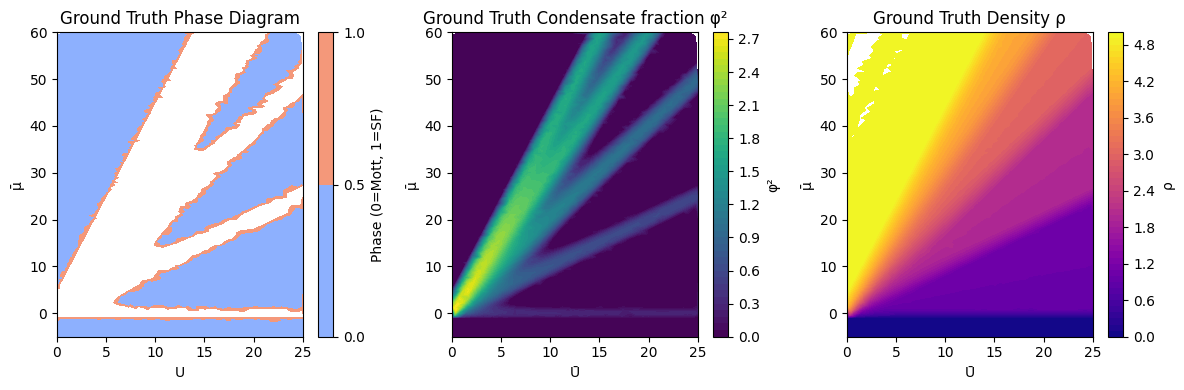


📊 Classification Report (Phase):
              precision    recall  f1-score   support

           0     0.9045    0.9630    0.9328      3000
           1     0.9682    0.9172    0.9420      3684

    accuracy                         0.9378      6684
   macro avg     0.9364    0.9401    0.9374      6684
weighted avg     0.9396    0.9378    0.9379      6684



C:\Users\DELL\AppData\Local\Temp\ipykernel_6640\3071995381.py:428: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_true_labels = df["Phase"].astype(int).ravel()


In [23]:
# Callback to ramp lam_phys in model.loss via attribute; implement as example where model has attribute lam_phys
import tensorflow as tf

class LambdaRamp(tf.keras.callbacks.Callback):
    def __init__(self, start_epoch, end_epoch, final_value):
        self.start = start_epoch
        self.end = end_epoch
        self.final = final_value
    def on_epoch_begin(self, epoch, logs=None):
        if epoch < self.start:
            val = 0.0
        elif epoch >= self.end:
            val = self.final
        else:
            val = (epoch - self.start)/(self.end - self.start) * self.final
        # store in model for your physics loss lambda to read
        setattr(self.model, "lam_phys_current", float(val))
        # optional logging
        print(f"Epoch {epoch}: lam_phys_current={val:.6f}")

# Modify physics loss lambda in compile to read model.lam_phys_current; easiest: implement phys loss using closure that reads model attribute
# Example usage:
ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
# pass ramp_cb to fit callbacks
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from pytorch_tabnet.tab_model import TabNetClassifier


# Label: 1 = Superfluid, 0 = Mott
def label_phase(rho, phi2, tol_rho=1e-3, tol_phi=1e-6):
    """
    Classify phase:
    - Mott insulator if (rho ~ integer) and (phi^2 ~ 0).
    - Superfluid otherwise.
    """
    is_integer_rho = np.isclose(rho, np.round(rho), atol=tol_rho)
    is_zero_phi = phi2 < tol_phi
    
    if is_integer_rho and is_zero_phi:
        return 0  # Mott
    else:
        return 1  # Superfluid

        
# # ---------- 1) Load and label ----------
# df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# # Label: 1 = Superfluid, 0 = Mott
# df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

# # Features and target: **only** Ubar, Mubar
# X = df[["Ubar", "Mubar"]].copy()
# y = df["Phase"].copy()

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.25, random_state=42,
#     stratify=y
# )


# # Apply physics-based labeling
# df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)

# # Features and target: **only** Ubar, Mubar
# X = df[["Ubar", "Mubar"]].copy()
# y = df["Phase"].copy()

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.25, random_state=42,
#     stratify=y
# )

# ---------- 1) Load and label ----------
df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Apply physics-based labeling (optional, but consistent)
df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)




# --- pick deep MI (phi2 ≈ 0, density ~ integer) ---



df_MI = df[
    (df["Phi2"] < 1e-8) &
    (np.isclose(df["Density"], np.round(df["Density"]), atol=1e-3))
]

# --- pick deep SF (large phi2) ---
df_SF = df[df["Phi2"] > 1e-2]

# --- pick boundary (ambiguous region) ---
df_boundary = df[
    (df["Phi2"] > 1e-6) & (df["Phi2"] < 1e-2)
]

# ------------------------------
# Smart sampling strategy
# ------------------------------
# n_MI = min(2000, len(df_MI))             # cap deep MI
# n_SF = min(2000, len(df_SF))             # cap deep SF
# n_boundary = min(6000, len(df_boundary)) # oversample boundary

n_MI = min(3000, len(df_MI))
n_SF = min(3000, len(df_SF))
n_boundary = min(6000, len(df_boundary))


df_reduced = pd.concat([
    df_MI.sample(n_MI, random_state=42),
    df_SF.sample(n_SF, random_state=42),
    df_boundary.sample(n_boundary, random_state=42)
])
print(df)
df_reduced = df_reduced.reset_index(drop=True)
# Use reduced dataset
df = df_reduced.reset_index(drop=True)
print(df)


print("Reduced dataset summary:")
print(df_reduced["Phase"].value_counts())

# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")

# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()

# --- 1) Load data ---
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# # Load dataset
# df = reduced_df

print(df)

# Features and targets
X = df[["Ubar","Mubar"]].values.astype(np.float32)
y = {
    "phase": df["Phase"].values.astype(np.float32),
    "phi2": df["Phi2"].values.astype(np.float32),
    "rho": df["Density"].values.astype(np.float32),
}

# --- 2) Train surrogate model ---
def build_surrogate(hidden=(128,64)):
    inp = keras.Input(shape=(2,))
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="relu")(x)
    out = layers.Dense(2, activation="linear")(x)   # [phi2, rho]
    m = keras.Model(inp, out)
    m.compile(optimizer="adam", loss="mse")
    return m

X_surr = df[["Ubar","Mubar"]].values.astype(np.float32)
y_surr = df[["Phi2","Density"]].values.astype(np.float32)

surrogate = build_surrogate()
surrogate.fit(
    X_surr, y_surr,
    epochs=200, batch_size=512,
    validation_split=0.15, verbose=1
)

# Surrogate validation
from sklearn.metrics import mean_squared_error, mean_absolute_error
X_val = X_surr[-500:]   # or better: shuffle and split properly
y_val = y_surr[-500:]
y_pred = surrogate.predict(X_val)
print("Surrogate MSE:", mean_squared_error(y_val, y_pred))
print("Surrogate MAE:", mean_absolute_error(y_val, y_pred))

# parity plot
import matplotlib.pyplot as plt
plt.scatter(y_val[:,0], y_pred[:,0], s=6); plt.xlabel("true phi2"); plt.ylabel("pred phi2"); plt.title("Surrogate phi2 parity")
plt.plot([y_val[:,0].min(), y_val[:,0].max()],[y_val[:,0].min(), y_val[:,0].max()], 'k--'); plt.show()


# Save & reload in new Keras format
surrogate.save("surrogate_phi_rho.keras")
surrogate = keras.models.load_model("surrogate_phi_rho.keras", compile=False)
surrogate.trainable = False   # freeze surrogate

# --- 3) PINN with surrogate residual ---
def make_pinn_with_surrogate(hidden=(128,64), lam_phase=1.0, lam_phys=1.0):
    inp = keras.Input(shape=(2,), name="input")   # [Ubar, Mubar]
    lam_phys_var = tf.Variable(lam_phys, trainable=False, dtype=tf.float32, name="lam_phys")
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="tanh")(x)

    phase_out = layers.Dense(1, activation="sigmoid", name="phase")(x)
    phi_out   = layers.Dense(1, activation="relu", name="phi2")(x)
    rho_out   = layers.Dense(1, activation="relu", name="rho")(x)

    # Physics residual via surrogate
    def phys_residual(inputs):
        UMb, phi_pred = inputs[0], inputs[1]
        s = surrogate(UMb)                  # surrogate predictions [phi2, rho]
        s_phi = tf.expand_dims(s[:, 0], -1) # only phi2
        return phi_pred - s_phi

    phys_out = layers.Lambda(
        lambda t: phys_residual([t[0], t[1]]),
        name="phys_res"
    )([inp, phi_out])

    model = keras.Model(inputs=inp, outputs=[phase_out, phi_out, rho_out, phys_out])

    losses = {
        "phase": "binary_crossentropy",
        "phi2": "mse",
        "rho": "mse",
        "phys_res": lambda y_true, y_pred: lam_phys_var * tf.reduce_mean(tf.square(y_pred))
    }
    loss_weights = {"phase": lam_phase, "phi2": 1.0, "rho": 1.0, "phys_res": 1.0}

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss=losses,
        loss_weights=loss_weights,
        metrics={"phase":"accuracy"}
    )
    model.lam_phys = lam_phys_var
    return model

pinn_surrogate = make_pinn_with_surrogate()

# --- 4) Train PINN ---
y_targets = {
    "phase": df["Phase"].values.reshape(-1,1).astype(np.float32),
    "phi2":  df["Phi2"].values.reshape(-1,1).astype(np.float32),
    "rho":   df["Density"].values.reshape(-1,1).astype(np.float32),
    "phys_res": np.zeros((len(df),1), dtype=np.float32)
}


def mc_predict(model, X, n=50):
    preds = []
    for _ in range(n):
        p = model(X, training=True)  # keep dropout active
        preds.append(p[0].numpy())   # phase output
    preds = np.stack(preds, axis=0)
    return preds.mean(0), preds.std(0)

    
ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
history = pinn_surrogate.fit(
    X, y_targets,
    batch_size=256,
    epochs=200,
    validation_split=0.15,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(patience=8, factor=0.5),ramp_cb
        # keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True)
    ]
)

# --- 5) Phase diagram prediction ---
U_vals = np.linspace(0, 25, 200)   # Ū axis
mu_vals = np.linspace(0, 60, 200)  # μ̄ axis
UU, MU = np.meshgrid(U_vals, mu_vals)
X_grid = np.stack([UU.ravel(), MU.ravel()], axis=1).astype(np.float32)

# Predict → 4 outputs
y_pred_grid = pinn_surrogate.predict(X_grid, verbose=0)
phase_pred, phi2_pred, rho_pred, _ = y_pred_grid

phase_pred = phase_pred.reshape(UU.shape)
phi2_pred  = phi2_pred.reshape(UU.shape)
rho_pred   = rho_pred.reshape(UU.shape)
phase_pred_class = (phase_pred > 0.5).astype(int)

plt.figure(figsize=(12,4))

# --- Phase diagram ---
plt.subplot(1,3,1)
mappable = plt.contourf(UU, MU, phase_pred_class,
                        levels=[-0.5, 0.5, 1.5], cmap="coolwarm")
plt.colorbar(mappable, ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
plt.contour(UU, MU, phase_pred, levels=[0.5], colors="k", linewidths=1.2)  # phase boundary
plt.xlabel("U",fontsize=10,fontweight="bold")
plt.ylabel("μ̄",fontsize=10, fontweight="bold")
plt.title("Phase Diagram",fontsize=12, fontweight="bold")
plt.grid(True)
plt.savefig('6k-Pinn-keras-pred', dpi=300, bbox_inches='tight')

# --- φ² diagram ---
plt.subplot(1,3,2)
mappable = plt.contourf(UU, MU, phi2_pred, 50, cmap="viridis")
plt.colorbar(mappable, label="φ²")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Condensate fraction φ²")

# --- ρ diagram ---
plt.subplot(1,3,3)
mappable = plt.contourf(UU, MU, rho_pred, 50, cmap="plasma")
plt.colorbar(mappable, label="ρ")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Density ρ")

plt.tight_layout()
plt.show()

from scipy.interpolate import griddata

# Ground truth values
points = df[["Ubar","Mubar"]].values
phi2_true_interp = griddata(points, df["Phi2"].values, (UU, MU), method="linear")
rho_true_interp  = griddata(points, df["Density"].values, (UU, MU), method="linear")

# Compute errors on grid
phi2_err = phi2_pred - phi2_true_interp
rho_err  = rho_pred - rho_true_interp

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.contourf(UU, MU, phi2_err, 50, cmap="coolwarm")
plt.colorbar(label="φ² error")
plt.title("φ² prediction error")

plt.subplot(1,2,2)
plt.contourf(UU, MU, rho_err, 50, cmap="coolwarm")
plt.colorbar(label="ρ error")
plt.title("ρ prediction error")
plt.tight_layout(); plt.show()



# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("U")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")


# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()


# --- 6) Classification report ---
y_pred_phase, y_pred_phi2, y_pred_rho, _ = pinn_surrogate.predict(X, verbose=0)
y_pred_labels = (y_pred_phase > 0.5).astype(int).ravel()
y_true_labels = df["Phase"].astype(int).ravel()

print("\n📊 Classification Report (Phase):")
print(classification_report(y_true_labels, y_pred_labels, digits=4))



# 6k extra

          t  Ubar  Mubar       Density          Phi2        Energy  Iters  \
0       1.0   0.0   -5.0  1.048576e-14  1.048576e-14  2.097152e-13      8   
1       1.0   0.0   -4.9  1.508449e-14  1.508449e-14  2.882646e-13      8   
2       1.0   0.0   -4.8  2.186340e-14  2.186340e-14  3.987884e-13      8   
3       1.0   0.0   -4.7  3.193733e-14  3.193733e-14  5.553901e-13      8   
4       1.0   0.0   -4.6  4.703477e-14  4.703477e-14  7.788958e-13      8   
...     ...   ...    ...           ...           ...           ...    ...   
163396  1.0  25.0   59.6  3.000000e+00  8.530376e-13 -1.038000e+02     21   
163397  1.0  25.0   59.7  3.000000e+00  7.586920e-13 -1.041000e+02     21   
163398  1.0  25.0   59.8  3.000000e+00  6.791729e-13 -1.044000e+02     21   
163399  1.0  25.0   59.9  3.000000e+00  6.119027e-13 -1.047000e+02     21   
163400  1.0  25.0   60.0  3.000000e+00  5.548081e-13 -1.050000e+02     21   

        Phase  
0           0  
1           0  
2           0  
3          

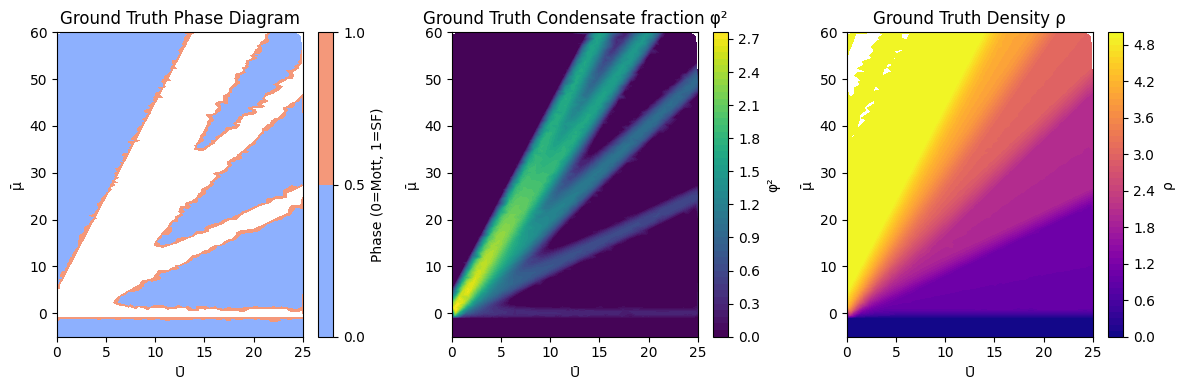

        t  Ubar  Mubar       Density          Phi2        Energy  Iters  Phase
0     1.0  24.4   13.4  1.000000e+00  6.034134e-14 -1.340000e+01      9      0
1     1.0  16.0   -1.1  8.624612e-11  8.624612e-11  9.487073e-12    101      0
2     1.0  22.4    6.0  1.000000e+00  5.328648e-14 -6.000000e+00     10      0
3     1.0  14.2   22.4  2.000000e+00  6.649626e-12 -3.060000e+01     37      0
4     1.0  22.0    7.5  1.000000e+00  1.363996e-14 -7.500000e+00     10      0
...   ...   ...    ...           ...           ...           ...    ...    ...
6679  1.0   3.6   -1.0  8.456767e-05  8.456471e-05  4.598585e-09   4589      1
6680  1.0   5.3   26.2  4.999955e+00  2.254263e-04 -7.800000e+01   7465      1
6681  1.0  10.9   17.5  2.000244e+00  2.100670e-03 -2.410000e+01   2451      1
6682  1.0  16.3   -1.0  6.803388e-05  6.803021e-05  4.123775e-09   4118      1
6683  1.0   5.1   25.4  4.999955e+00  2.261209e-04 -7.600000e+01   7477      1

[6684 rows x 8 columns]
Epoch 1/200
12/12 ━━━━━━━━━

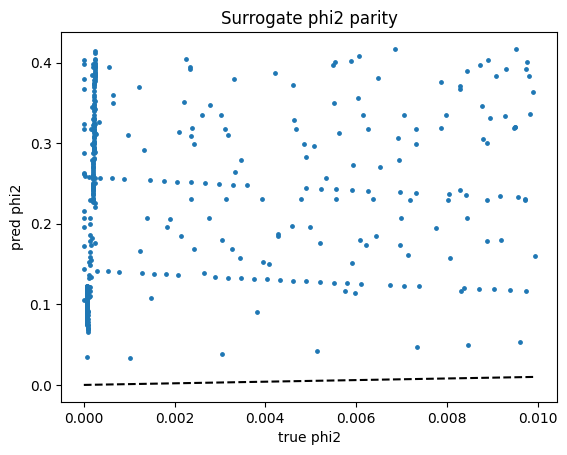

Epoch 0: lam_phys_current=0.000000
Epoch 1/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.6900 - phase_accuracy: 0.5323 - phase_loss: 0.7067 - phi2_loss: 0.4538 - phys_res_loss: 0.4338 - rho_loss: 1.0644 - val_loss: 1.4531 - val_phase_accuracy: 0.8804 - val_phase_loss: 0.5766 - val_phi2_loss: 0.3061 - val_phys_res_loss: 0.2179 - val_rho_loss: 0.3465 - learning_rate: 0.0010
Epoch 1: lam_phys_current=0.000000
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3656 - phase_accuracy: 0.6439 - phase_loss: 0.6348 - phi2_loss: 0.2977 - phys_res_loss: 0.2706 - rho_loss: 0.1559 - val_loss: 1.4206 - val_phase_accuracy: 0.6231 - val_phase_loss: 0.7865 - val_phi2_loss: 0.2971 - val_phys_res_loss: 0.1732 - val_rho_loss: 0.1634 - learning_rate: 0.0010
Epoch 2: lam_phys_current=0.000000
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0936 - phase_accuracy: 0.7664 - phase_loss: 0.6004 - phi2_loss: 0.2240 - phys_res_loss: 0.1986 - rho_loss: 0.0680 - val_loss: 1.3716 - val_

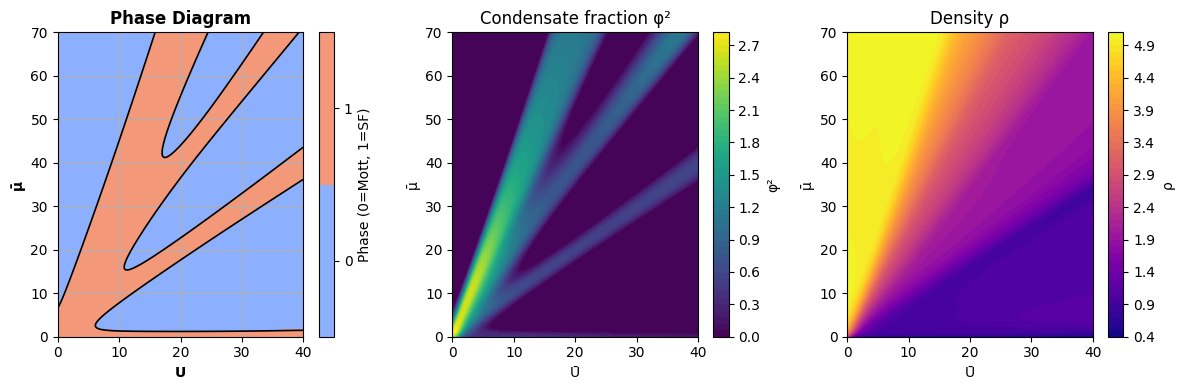

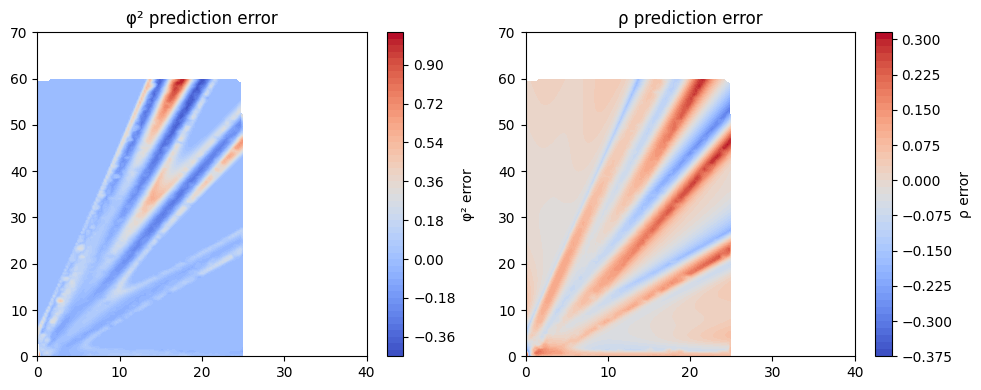

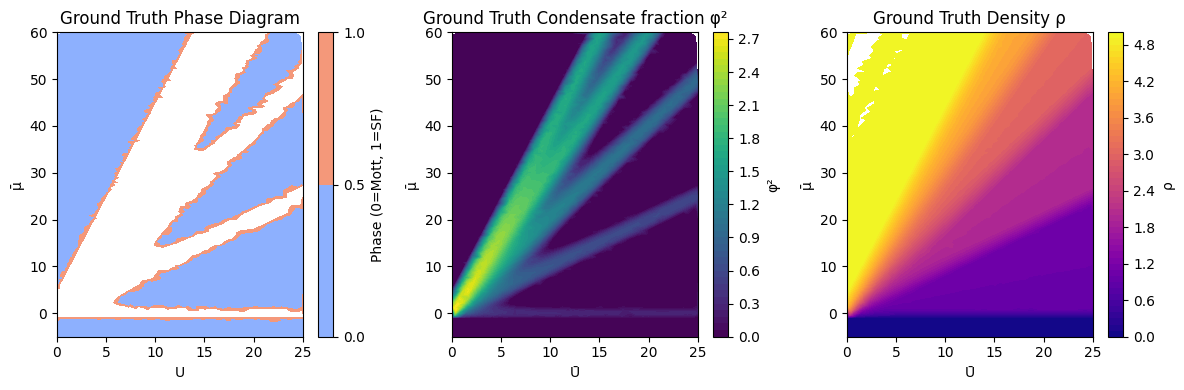


📊 Classification Report (Phase):
              precision    recall  f1-score   support

           0     0.9178    0.9673    0.9419      3000
           1     0.9722    0.9294    0.9503      3684

    accuracy                         0.9464      6684
   macro avg     0.9450    0.9484    0.9461      6684
weighted avg     0.9478    0.9464    0.9465      6684



C:\Users\DELL\AppData\Local\Temp\ipykernel_21340\2618442371.py:428: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_true_labels = df["Phase"].astype(int).ravel()


In [3]:
# Callback to ramp lam_phys in model.loss via attribute; implement as example where model has attribute lam_phys
import tensorflow as tf

class LambdaRamp(tf.keras.callbacks.Callback):
    def __init__(self, start_epoch, end_epoch, final_value):
        self.start = start_epoch
        self.end = end_epoch
        self.final = final_value
    def on_epoch_begin(self, epoch, logs=None):
        if epoch < self.start:
            val = 0.0
        elif epoch >= self.end:
            val = self.final
        else:
            val = (epoch - self.start)/(self.end - self.start) * self.final
        # store in model for your physics loss lambda to read
        setattr(self.model, "lam_phys_current", float(val))
        # optional logging
        print(f"Epoch {epoch}: lam_phys_current={val:.6f}")

# Modify physics loss lambda in compile to read model.lam_phys_current; easiest: implement phys loss using closure that reads model attribute
# Example usage:
ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
# pass ramp_cb to fit callbacks
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from pytorch_tabnet.tab_model import TabNetClassifier


# Label: 1 = Superfluid, 0 = Mott
def label_phase(rho, phi2, tol_rho=1e-3, tol_phi=1e-6):
    """
    Classify phase:
    - Mott insulator if (rho ~ integer) and (phi^2 ~ 0).
    - Superfluid otherwise.
    """
    is_integer_rho = np.isclose(rho, np.round(rho), atol=tol_rho)
    is_zero_phi = phi2 < tol_phi
    
    if is_integer_rho and is_zero_phi:
        return 0  # Mott
    else:
        return 1  # Superfluid

        
# # ---------- 1) Load and label ----------
# df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# # Label: 1 = Superfluid, 0 = Mott
# df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

# # Features and target: **only** Ubar, Mubar
# X = df[["Ubar", "Mubar"]].copy()
# y = df["Phase"].copy()

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.25, random_state=42,
#     stratify=y
# )


# # Apply physics-based labeling
# df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)

# # Features and target: **only** Ubar, Mubar
# X = df[["Ubar", "Mubar"]].copy()
# y = df["Phase"].copy()

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.25, random_state=42,
#     stratify=y
# )

# ---------- 1) Load and label ----------
df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Apply physics-based labeling (optional, but consistent)
df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)




# --- pick deep MI (phi2 ≈ 0, density ~ integer) ---



df_MI = df[
    (df["Phi2"] < 1e-8) &
    (np.isclose(df["Density"], np.round(df["Density"]), atol=1e-3))
]

# --- pick deep SF (large phi2) ---
df_SF = df[df["Phi2"] > 1e-2]

# --- pick boundary (ambiguous region) ---
df_boundary = df[
    (df["Phi2"] > 1e-6) & (df["Phi2"] < 1e-2)
]

# ------------------------------
# Smart sampling strategy
# ------------------------------
# n_MI = min(2000, len(df_MI))             # cap deep MI
# n_SF = min(2000, len(df_SF))             # cap deep SF
# n_boundary = min(6000, len(df_boundary)) # oversample boundary

n_MI = min(3000, len(df_MI))
n_SF = min(3000, len(df_SF))
n_boundary = min(6000, len(df_boundary))


df_reduced = pd.concat([
    df_MI.sample(n_MI, random_state=42),
    df_SF.sample(n_SF, random_state=42),
    df_boundary.sample(n_boundary, random_state=42)
])
print(df)
df_reduced = df_reduced.reset_index(drop=True)
# Use reduced dataset
df = df_reduced.reset_index(drop=True)
print(df)


print("Reduced dataset summary:")
print(df_reduced["Phase"].value_counts())

# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")

# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()

# --- 1) Load data ---
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# # Load dataset
# df = reduced_df

print(df)

# Features and targets
X = df[["Ubar","Mubar"]].values.astype(np.float32)
y = {
    "phase": df["Phase"].values.astype(np.float32),
    "phi2": df["Phi2"].values.astype(np.float32),
    "rho": df["Density"].values.astype(np.float32),
}

# --- 2) Train surrogate model ---
def build_surrogate(hidden=(128,64)):
    inp = keras.Input(shape=(2,))
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="relu")(x)
    out = layers.Dense(2, activation="linear")(x)   # [phi2, rho]
    m = keras.Model(inp, out)
    m.compile(optimizer="adam", loss="mse")
    return m

X_surr = df[["Ubar","Mubar"]].values.astype(np.float32)
y_surr = df[["Phi2","Density"]].values.astype(np.float32)

surrogate = build_surrogate()
surrogate.fit(
    X_surr, y_surr,
    epochs=200, batch_size=512,
    validation_split=0.15, verbose=1
)

# Surrogate validation
from sklearn.metrics import mean_squared_error, mean_absolute_error
X_val = X_surr[-500:]   # or better: shuffle and split properly
y_val = y_surr[-500:]
y_pred = surrogate.predict(X_val)
print("Surrogate MSE:", mean_squared_error(y_val, y_pred))
print("Surrogate MAE:", mean_absolute_error(y_val, y_pred))

# parity plot
import matplotlib.pyplot as plt
plt.scatter(y_val[:,0], y_pred[:,0], s=6); plt.xlabel("true phi2"); plt.ylabel("pred phi2"); plt.title("Surrogate phi2 parity")
plt.plot([y_val[:,0].min(), y_val[:,0].max()],[y_val[:,0].min(), y_val[:,0].max()], 'k--'); plt.show()


# Save & reload in new Keras format
surrogate.save("surrogate_phi_rho.keras")
surrogate = keras.models.load_model("surrogate_phi_rho.keras", compile=False)
surrogate.trainable = False   # freeze surrogate

# --- 3) PINN with surrogate residual ---
def make_pinn_with_surrogate(hidden=(128,64), lam_phase=1.0, lam_phys=1.0):
    inp = keras.Input(shape=(2,), name="input")   # [Ubar, Mubar]
    lam_phys_var = tf.Variable(lam_phys, trainable=False, dtype=tf.float32, name="lam_phys")
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="tanh")(x)

    phase_out = layers.Dense(1, activation="sigmoid", name="phase")(x)
    phi_out   = layers.Dense(1, activation="relu", name="phi2")(x)
    rho_out   = layers.Dense(1, activation="relu", name="rho")(x)

    # Physics residual via surrogate
    def phys_residual(inputs):
        UMb, phi_pred = inputs[0], inputs[1]
        s = surrogate(UMb)                  # surrogate predictions [phi2, rho]
        s_phi = tf.expand_dims(s[:, 0], -1) # only phi2
        return phi_pred - s_phi

    phys_out = layers.Lambda(
        lambda t: phys_residual([t[0], t[1]]),
        name="phys_res"
    )([inp, phi_out])

    model = keras.Model(inputs=inp, outputs=[phase_out, phi_out, rho_out, phys_out])

    losses = {
        "phase": "binary_crossentropy",
        "phi2": "mse",
        "rho": "mse",
        "phys_res": lambda y_true, y_pred: lam_phys_var * tf.reduce_mean(tf.square(y_pred))
    }
    loss_weights = {"phase": lam_phase, "phi2": 1.0, "rho": 1.0, "phys_res": 1.0}

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss=losses,
        loss_weights=loss_weights,
        metrics={"phase":"accuracy"}
    )
    model.lam_phys = lam_phys_var
    return model

pinn_surrogate = make_pinn_with_surrogate()

# --- 4) Train PINN ---
y_targets = {
    "phase": df["Phase"].values.reshape(-1,1).astype(np.float32),
    "phi2":  df["Phi2"].values.reshape(-1,1).astype(np.float32),
    "rho":   df["Density"].values.reshape(-1,1).astype(np.float32),
    "phys_res": np.zeros((len(df),1), dtype=np.float32)
}


def mc_predict(model, X, n=50):
    preds = []
    for _ in range(n):
        p = model(X, training=True)  # keep dropout active
        preds.append(p[0].numpy())   # phase output
    preds = np.stack(preds, axis=0)
    return preds.mean(0), preds.std(0)

    
ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
history = pinn_surrogate.fit(
    X, y_targets,
    batch_size=256,
    epochs=200,
    validation_split=0.15,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(patience=8, factor=0.5),ramp_cb
        # keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True)
    ]
)

# --- 5) Phase diagram prediction ---
U_vals = np.linspace(0, 40, 200)   # Ū axis
mu_vals = np.linspace(0, 70, 200)  # μ̄ axis
UU, MU = np.meshgrid(U_vals, mu_vals)
X_grid = np.stack([UU.ravel(), MU.ravel()], axis=1).astype(np.float32)

# Predict → 4 outputs
y_pred_grid = pinn_surrogate.predict(X_grid, verbose=0)
phase_pred, phi2_pred, rho_pred, _ = y_pred_grid

phase_pred = phase_pred.reshape(UU.shape)
phi2_pred  = phi2_pred.reshape(UU.shape)
rho_pred   = rho_pred.reshape(UU.shape)
phase_pred_class = (phase_pred > 0.5).astype(int)

plt.figure(figsize=(12,4))

# --- Phase diagram ---
plt.subplot(1,3,1)
mappable = plt.contourf(UU, MU, phase_pred_class,
                        levels=[-0.5, 0.5, 1.5], cmap="coolwarm")
plt.colorbar(mappable, ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
plt.contour(UU, MU, phase_pred, levels=[0.5], colors="k", linewidths=1.2)  # phase boundary
plt.xlabel("U",fontsize=10,fontweight="bold")
plt.ylabel("μ̄",fontsize=10, fontweight="bold")
plt.title("Phase Diagram",fontsize=12, fontweight="bold")
plt.grid(True)
plt.savefig('6k-extra-Pinn-keras-pred', dpi=300, bbox_inches='tight')

# --- φ² diagram ---
plt.subplot(1,3,2)
mappable = plt.contourf(UU, MU, phi2_pred, 50, cmap="viridis")
plt.colorbar(mappable, label="φ²")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Condensate fraction φ²")

# --- ρ diagram ---
plt.subplot(1,3,3)
mappable = plt.contourf(UU, MU, rho_pred, 50, cmap="plasma")
plt.colorbar(mappable, label="ρ")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Density ρ")

plt.tight_layout()
plt.show()

from scipy.interpolate import griddata

# Ground truth values
points = df[["Ubar","Mubar"]].values
phi2_true_interp = griddata(points, df["Phi2"].values, (UU, MU), method="linear")
rho_true_interp  = griddata(points, df["Density"].values, (UU, MU), method="linear")

# Compute errors on grid
phi2_err = phi2_pred - phi2_true_interp
rho_err  = rho_pred - rho_true_interp

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.contourf(UU, MU, phi2_err, 50, cmap="coolwarm")
plt.colorbar(label="φ² error")
plt.title("φ² prediction error")

plt.subplot(1,2,2)
plt.contourf(UU, MU, rho_err, 50, cmap="coolwarm")
plt.colorbar(label="ρ error")
plt.title("ρ prediction error")
plt.tight_layout(); plt.show()



# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("U")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")


# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()


# --- 6) Classification report ---
y_pred_phase, y_pred_phi2, y_pred_rho, _ = pinn_surrogate.predict(X, verbose=0)
y_pred_labels = (y_pred_phase > 0.5).astype(int).ravel()
y_true_labels = df["Phase"].astype(int).ravel()

print("\n📊 Classification Report (Phase):")
print(classification_report(y_true_labels, y_pred_labels, digits=4))



# 4k

          t  Ubar  Mubar       Density          Phi2        Energy  Iters  \
0       1.0   0.0   -5.0  1.048576e-14  1.048576e-14  2.097152e-13      8   
1       1.0   0.0   -4.9  1.508449e-14  1.508449e-14  2.882646e-13      8   
2       1.0   0.0   -4.8  2.186340e-14  2.186340e-14  3.987884e-13      8   
3       1.0   0.0   -4.7  3.193733e-14  3.193733e-14  5.553901e-13      8   
4       1.0   0.0   -4.6  4.703477e-14  4.703477e-14  7.788958e-13      8   
...     ...   ...    ...           ...           ...           ...    ...   
163396  1.0  25.0   59.6  3.000000e+00  8.530376e-13 -1.038000e+02     21   
163397  1.0  25.0   59.7  3.000000e+00  7.586920e-13 -1.041000e+02     21   
163398  1.0  25.0   59.8  3.000000e+00  6.791729e-13 -1.044000e+02     21   
163399  1.0  25.0   59.9  3.000000e+00  6.119027e-13 -1.047000e+02     21   
163400  1.0  25.0   60.0  3.000000e+00  5.548081e-13 -1.050000e+02     21   

        Phase  
0           0  
1           0  
2           0  
3          

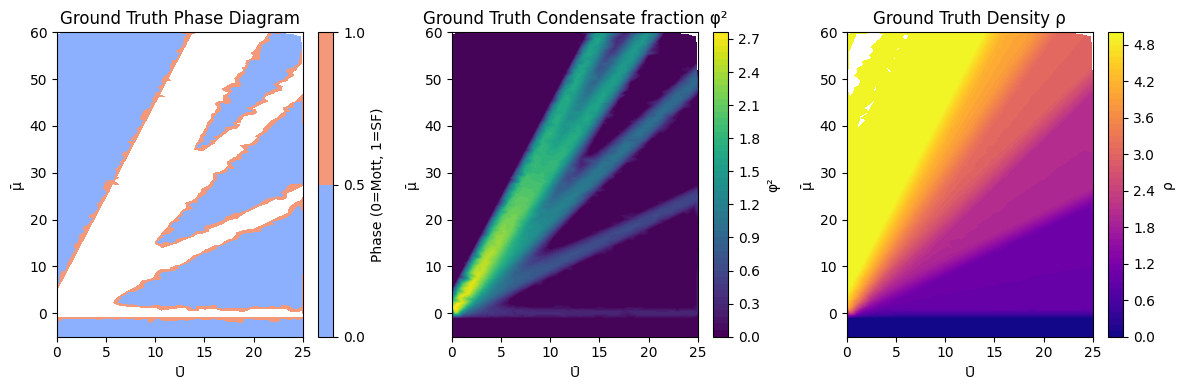

        t  Ubar  Mubar       Density          Phi2        Energy  Iters  Phase
0     1.0  24.4   13.4  1.000000e+00  6.034134e-14 -1.340000e+01      9      0
1     1.0  16.0   -1.1  8.624612e-11  8.624612e-11  9.487073e-12    101      0
2     1.0  22.4    6.0  1.000000e+00  5.328648e-14 -6.000000e+00     10      0
3     1.0  14.2   22.4  2.000000e+00  6.649626e-12 -3.060000e+01     37      0
4     1.0  22.0    7.5  1.000000e+00  1.363996e-14 -7.500000e+00     10      0
...   ...   ...    ...           ...           ...           ...    ...    ...
4679  1.0   3.6   -1.0  8.456767e-05  8.456471e-05  4.598585e-09   4589      1
4680  1.0   5.3   26.2  4.999955e+00  2.254263e-04 -7.800000e+01   7465      1
4681  1.0  10.9   17.5  2.000244e+00  2.100670e-03 -2.410000e+01   2451      1
4682  1.0  16.3   -1.0  6.803388e-05  6.803021e-05  4.123775e-09   4118      1
4683  1.0   5.1   25.4  4.999955e+00  2.261209e-04 -7.600000e+01   7477      1

[4684 rows x 8 columns]
Epoch 1/200
8/8 ━━━━━━━━━━━

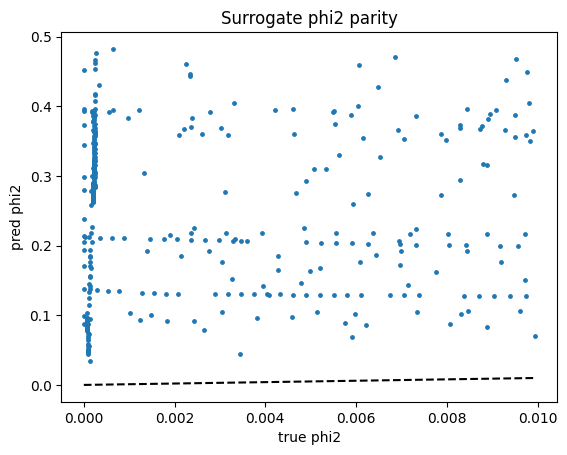

Epoch 0: lam_phys_current=0.000000
Epoch 1/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.6854 - phase_accuracy: 0.4851 - phase_loss: 0.7179 - phi2_loss: 0.4653 - phys_res_loss: 0.4412 - rho_loss: 1.0324 - val_loss: 1.4160 - val_phase_accuracy: 0.5178 - val_phase_loss: 0.8203 - val_phi2_loss: 0.1265 - val_phys_res_loss: 0.0480 - val_rho_loss: 0.4167 - learning_rate: 0.0010
Epoch 1: lam_phys_current=0.000000
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4030 - phase_accuracy: 0.6247 - phase_loss: 0.6530 - phi2_loss: 0.2886 - phys_res_loss: 0.2587 - rho_loss: 0.1964 - val_loss: 1.3342 - val_phase_accuracy: 0.4680 - val_phase_loss: 0.8496 - val_phi2_loss: 0.2081 - val_phys_res_loss: 0.0724 - val_rho_loss: 0.2050 - learning_rate: 0.0010
Epoch 2: lam_phys_current=0.000000
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1302 - phase_accuracy: 0.7546 - phase_loss: 0.6195 - phi2_loss: 0.2296 - phys_res_loss: 0.1996 - rho_loss: 0.0786 - val_loss: 1.3684 - val_

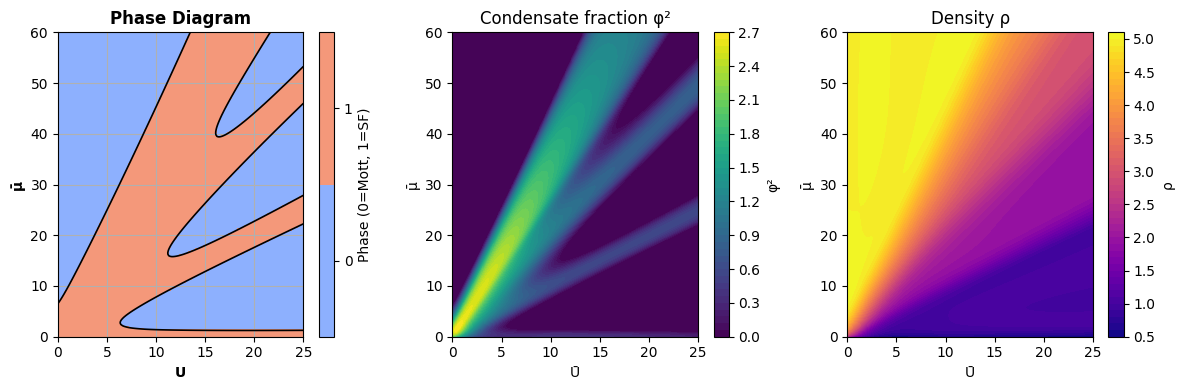

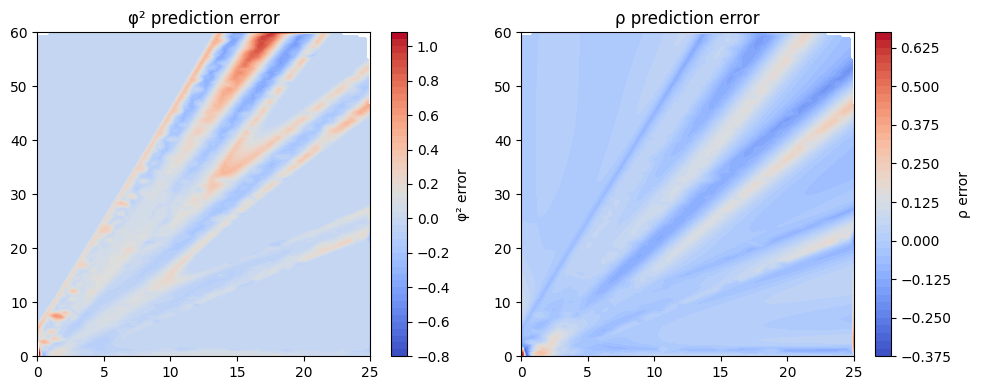

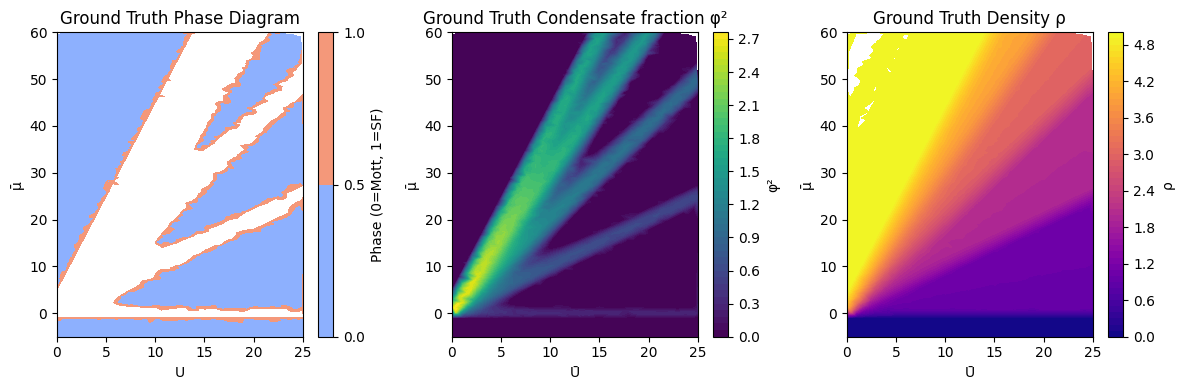


📊 Classification Report (Phase):
              precision    recall  f1-score   support

           0     0.9091    0.9655    0.9365      2000
           1     0.9730    0.9281    0.9500      2684

    accuracy                         0.9441      4684
   macro avg     0.9411    0.9468    0.9433      4684
weighted avg     0.9458    0.9441    0.9442      4684



C:\Users\DELL\AppData\Local\Temp\ipykernel_6640\21035671.py:428: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_true_labels = df["Phase"].astype(int).ravel()


In [24]:
# Callback to ramp lam_phys in model.loss via attribute; implement as example where model has attribute lam_phys
import tensorflow as tf

class LambdaRamp(tf.keras.callbacks.Callback):
    def __init__(self, start_epoch, end_epoch, final_value):
        self.start = start_epoch
        self.end = end_epoch
        self.final = final_value
    def on_epoch_begin(self, epoch, logs=None):
        if epoch < self.start:
            val = 0.0
        elif epoch >= self.end:
            val = self.final
        else:
            val = (epoch - self.start)/(self.end - self.start) * self.final
        # store in model for your physics loss lambda to read
        setattr(self.model, "lam_phys_current", float(val))
        # optional logging
        print(f"Epoch {epoch}: lam_phys_current={val:.6f}")

# Modify physics loss lambda in compile to read model.lam_phys_current; easiest: implement phys loss using closure that reads model attribute
# Example usage:
ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
# pass ramp_cb to fit callbacks
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from pytorch_tabnet.tab_model import TabNetClassifier


# Label: 1 = Superfluid, 0 = Mott
def label_phase(rho, phi2, tol_rho=1e-3, tol_phi=1e-6):
    """
    Classify phase:
    - Mott insulator if (rho ~ integer) and (phi^2 ~ 0).
    - Superfluid otherwise.
    """
    is_integer_rho = np.isclose(rho, np.round(rho), atol=tol_rho)
    is_zero_phi = phi2 < tol_phi
    
    if is_integer_rho and is_zero_phi:
        return 0  # Mott
    else:
        return 1  # Superfluid

        
# # ---------- 1) Load and label ----------
# df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# # Label: 1 = Superfluid, 0 = Mott
# df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

# # Features and target: **only** Ubar, Mubar
# X = df[["Ubar", "Mubar"]].copy()
# y = df["Phase"].copy()

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.25, random_state=42,
#     stratify=y
# )


# # Apply physics-based labeling
# df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)

# # Features and target: **only** Ubar, Mubar
# X = df[["Ubar", "Mubar"]].copy()
# y = df["Phase"].copy()

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.25, random_state=42,
#     stratify=y
# )

# ---------- 1) Load and label ----------
df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Apply physics-based labeling (optional, but consistent)
df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)




# --- pick deep MI (phi2 ≈ 0, density ~ integer) ---



df_MI = df[
    (df["Phi2"] < 1e-8) &
    (np.isclose(df["Density"], np.round(df["Density"]), atol=1e-3))
]

# --- pick deep SF (large phi2) ---
df_SF = df[df["Phi2"] > 1e-2]

# --- pick boundary (ambiguous region) ---
df_boundary = df[
    (df["Phi2"] > 1e-6) & (df["Phi2"] < 1e-2)
]

# ------------------------------
# Smart sampling strategy
# ------------------------------
# n_MI = min(2000, len(df_MI))             # cap deep MI
# n_SF = min(2000, len(df_SF))             # cap deep SF
# n_boundary = min(6000, len(df_boundary)) # oversample boundary

n_MI = min(2000, len(df_MI))
n_SF = min(2000, len(df_SF))
n_boundary = min(4000, len(df_boundary))


df_reduced = pd.concat([
    df_MI.sample(n_MI, random_state=42),
    df_SF.sample(n_SF, random_state=42),
    df_boundary.sample(n_boundary, random_state=42)
])
print(df)
df_reduced = df_reduced.reset_index(drop=True)
# Use reduced dataset
df = df_reduced.reset_index(drop=True)
print(df)


print("Reduced dataset summary:")
print(df_reduced["Phase"].value_counts())

# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")

# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()

# --- 1) Load data ---
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# # Load dataset
# df = reduced_df

print(df)

# Features and targets
X = df[["Ubar","Mubar"]].values.astype(np.float32)
y = {
    "phase": df["Phase"].values.astype(np.float32),
    "phi2": df["Phi2"].values.astype(np.float32),
    "rho": df["Density"].values.astype(np.float32),
}

# --- 2) Train surrogate model ---
def build_surrogate(hidden=(128,64)):
    inp = keras.Input(shape=(2,))
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="relu")(x)
    out = layers.Dense(2, activation="linear")(x)   # [phi2, rho]
    m = keras.Model(inp, out)
    m.compile(optimizer="adam", loss="mse")
    return m

X_surr = df[["Ubar","Mubar"]].values.astype(np.float32)
y_surr = df[["Phi2","Density"]].values.astype(np.float32)

surrogate = build_surrogate()
surrogate.fit(
    X_surr, y_surr,
    epochs=200, batch_size=512,
    validation_split=0.15, verbose=1
)

# Surrogate validation
from sklearn.metrics import mean_squared_error, mean_absolute_error
X_val = X_surr[-500:]   # or better: shuffle and split properly
y_val = y_surr[-500:]
y_pred = surrogate.predict(X_val)
print("Surrogate MSE:", mean_squared_error(y_val, y_pred))
print("Surrogate MAE:", mean_absolute_error(y_val, y_pred))

# parity plot
import matplotlib.pyplot as plt
plt.scatter(y_val[:,0], y_pred[:,0], s=6); plt.xlabel("true phi2"); plt.ylabel("pred phi2"); plt.title("Surrogate phi2 parity")
plt.plot([y_val[:,0].min(), y_val[:,0].max()],[y_val[:,0].min(), y_val[:,0].max()], 'k--'); plt.show()


# Save & reload in new Keras format
surrogate.save("surrogate_phi_rho.keras")
surrogate = keras.models.load_model("surrogate_phi_rho.keras", compile=False)
surrogate.trainable = False   # freeze surrogate

# --- 3) PINN with surrogate residual ---
def make_pinn_with_surrogate(hidden=(128,64), lam_phase=1.0, lam_phys=1.0):
    inp = keras.Input(shape=(2,), name="input")   # [Ubar, Mubar]
    lam_phys_var = tf.Variable(lam_phys, trainable=False, dtype=tf.float32, name="lam_phys")
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="tanh")(x)

    phase_out = layers.Dense(1, activation="sigmoid", name="phase")(x)
    phi_out   = layers.Dense(1, activation="relu", name="phi2")(x)
    rho_out   = layers.Dense(1, activation="relu", name="rho")(x)

    # Physics residual via surrogate
    def phys_residual(inputs):
        UMb, phi_pred = inputs[0], inputs[1]
        s = surrogate(UMb)                  # surrogate predictions [phi2, rho]
        s_phi = tf.expand_dims(s[:, 0], -1) # only phi2
        return phi_pred - s_phi

    phys_out = layers.Lambda(
        lambda t: phys_residual([t[0], t[1]]),
        name="phys_res"
    )([inp, phi_out])

    model = keras.Model(inputs=inp, outputs=[phase_out, phi_out, rho_out, phys_out])

    losses = {
        "phase": "binary_crossentropy",
        "phi2": "mse",
        "rho": "mse",
        "phys_res": lambda y_true, y_pred: lam_phys_var * tf.reduce_mean(tf.square(y_pred))
    }
    loss_weights = {"phase": lam_phase, "phi2": 1.0, "rho": 1.0, "phys_res": 1.0}

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss=losses,
        loss_weights=loss_weights,
        metrics={"phase":"accuracy"}
    )
    model.lam_phys = lam_phys_var
    return model

pinn_surrogate = make_pinn_with_surrogate()

# --- 4) Train PINN ---
y_targets = {
    "phase": df["Phase"].values.reshape(-1,1).astype(np.float32),
    "phi2":  df["Phi2"].values.reshape(-1,1).astype(np.float32),
    "rho":   df["Density"].values.reshape(-1,1).astype(np.float32),
    "phys_res": np.zeros((len(df),1), dtype=np.float32)
}


def mc_predict(model, X, n=50):
    preds = []
    for _ in range(n):
        p = model(X, training=True)  # keep dropout active
        preds.append(p[0].numpy())   # phase output
    preds = np.stack(preds, axis=0)
    return preds.mean(0), preds.std(0)

    
ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
history = pinn_surrogate.fit(
    X, y_targets,
    batch_size=256,
    epochs=200,
    validation_split=0.15,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(patience=8, factor=0.5),ramp_cb
        # keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True)
    ]
)

# --- 5) Phase diagram prediction ---
U_vals = np.linspace(0, 25, 200)   # Ū axis
mu_vals = np.linspace(0, 60, 200)  # μ̄ axis
UU, MU = np.meshgrid(U_vals, mu_vals)
X_grid = np.stack([UU.ravel(), MU.ravel()], axis=1).astype(np.float32)

# Predict → 4 outputs
y_pred_grid = pinn_surrogate.predict(X_grid, verbose=0)
phase_pred, phi2_pred, rho_pred, _ = y_pred_grid

phase_pred = phase_pred.reshape(UU.shape)
phi2_pred  = phi2_pred.reshape(UU.shape)
rho_pred   = rho_pred.reshape(UU.shape)
phase_pred_class = (phase_pred > 0.5).astype(int)

plt.figure(figsize=(12,4))

# --- Phase diagram ---
plt.subplot(1,3,1)
mappable = plt.contourf(UU, MU, phase_pred_class,
                        levels=[-0.5, 0.5, 1.5], cmap="coolwarm")
plt.colorbar(mappable, ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
plt.contour(UU, MU, phase_pred, levels=[0.5], colors="k", linewidths=1.2)  # phase boundary
plt.xlabel("U",fontsize=10,fontweight="bold")
plt.ylabel("μ̄",fontsize=10, fontweight="bold")
plt.title("Phase Diagram",fontsize=12, fontweight="bold")
plt.grid(True)
plt.savefig('4k-Pinn-keras-pred', dpi=300, bbox_inches='tight')

# --- φ² diagram ---
plt.subplot(1,3,2)
mappable = plt.contourf(UU, MU, phi2_pred, 50, cmap="viridis")
plt.colorbar(mappable, label="φ²")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Condensate fraction φ²")

# --- ρ diagram ---
plt.subplot(1,3,3)
mappable = plt.contourf(UU, MU, rho_pred, 50, cmap="plasma")
plt.colorbar(mappable, label="ρ")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Density ρ")

plt.tight_layout()
plt.show()

from scipy.interpolate import griddata

# Ground truth values
points = df[["Ubar","Mubar"]].values
phi2_true_interp = griddata(points, df["Phi2"].values, (UU, MU), method="linear")
rho_true_interp  = griddata(points, df["Density"].values, (UU, MU), method="linear")

# Compute errors on grid
phi2_err = phi2_pred - phi2_true_interp
rho_err  = rho_pred - rho_true_interp

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.contourf(UU, MU, phi2_err, 50, cmap="coolwarm")
plt.colorbar(label="φ² error")
plt.title("φ² prediction error")

plt.subplot(1,2,2)
plt.contourf(UU, MU, rho_err, 50, cmap="coolwarm")
plt.colorbar(label="ρ error")
plt.title("ρ prediction error")
plt.tight_layout(); plt.show()



# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("U")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")


# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()


# --- 6) Classification report ---
y_pred_phase, y_pred_phi2, y_pred_rho, _ = pinn_surrogate.predict(X, verbose=0)
y_pred_labels = (y_pred_phase > 0.5).astype(int).ravel()
y_true_labels = df["Phase"].astype(int).ravel()

print("\n📊 Classification Report (Phase):")
print(classification_report(y_true_labels, y_pred_labels, digits=4))



# 4K EXTRA

          t  Ubar  Mubar       Density          Phi2        Energy  Iters  \
0       1.0   0.0   -5.0  1.048576e-14  1.048576e-14  2.097152e-13      8   
1       1.0   0.0   -4.9  1.508449e-14  1.508449e-14  2.882646e-13      8   
2       1.0   0.0   -4.8  2.186340e-14  2.186340e-14  3.987884e-13      8   
3       1.0   0.0   -4.7  3.193733e-14  3.193733e-14  5.553901e-13      8   
4       1.0   0.0   -4.6  4.703477e-14  4.703477e-14  7.788958e-13      8   
...     ...   ...    ...           ...           ...           ...    ...   
163396  1.0  25.0   59.6  3.000000e+00  8.530376e-13 -1.038000e+02     21   
163397  1.0  25.0   59.7  3.000000e+00  7.586920e-13 -1.041000e+02     21   
163398  1.0  25.0   59.8  3.000000e+00  6.791729e-13 -1.044000e+02     21   
163399  1.0  25.0   59.9  3.000000e+00  6.119027e-13 -1.047000e+02     21   
163400  1.0  25.0   60.0  3.000000e+00  5.548081e-13 -1.050000e+02     21   

        Phase  
0           0  
1           0  
2           0  
3          

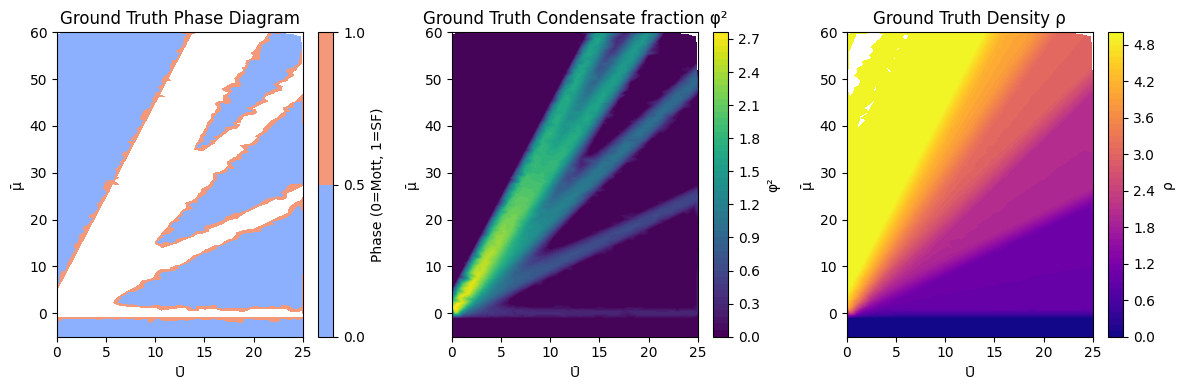

        t  Ubar  Mubar       Density          Phi2        Energy  Iters  Phase
0     1.0  24.4   13.4  1.000000e+00  6.034134e-14 -1.340000e+01      9      0
1     1.0  16.0   -1.1  8.624612e-11  8.624612e-11  9.487073e-12    101      0
2     1.0  22.4    6.0  1.000000e+00  5.328648e-14 -6.000000e+00     10      0
3     1.0  14.2   22.4  2.000000e+00  6.649626e-12 -3.060000e+01     37      0
4     1.0  22.0    7.5  1.000000e+00  1.363996e-14 -7.500000e+00     10      0
...   ...   ...    ...           ...           ...           ...    ...    ...
4679  1.0   3.6   -1.0  8.456767e-05  8.456471e-05  4.598585e-09   4589      1
4680  1.0   5.3   26.2  4.999955e+00  2.254263e-04 -7.800000e+01   7465      1
4681  1.0  10.9   17.5  2.000244e+00  2.100670e-03 -2.410000e+01   2451      1
4682  1.0  16.3   -1.0  6.803388e-05  6.803021e-05  4.123775e-09   4118      1
4683  1.0   5.1   25.4  4.999955e+00  2.261209e-04 -7.600000e+01   7477      1

[4684 rows x 8 columns]
Epoch 1/200
8/8 ━━━━━━━━━━━

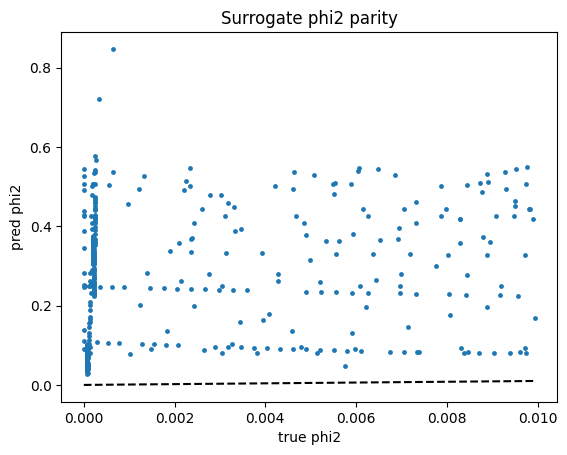

Epoch 0: lam_phys_current=0.000000
Epoch 1/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.9452 - phase_accuracy: 0.5682 - phase_loss: 0.7060 - phi2_loss: 0.3648 - phys_res_loss: 0.3412 - rho_loss: 1.4938 - val_loss: 1.5042 - val_phase_accuracy: 0.2959 - val_phase_loss: 0.8968 - val_phi2_loss: 0.2680 - val_phys_res_loss: 0.0866 - val_rho_loss: 0.2537 - learning_rate: 0.0010
Epoch 1: lam_phys_current=0.000000
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.4191 - phase_accuracy: 0.5956 - phase_loss: 0.6551 - phi2_loss: 0.2752 - phys_res_loss: 0.2582 - rho_loss: 0.2279 - val_loss: 1.3588 - val_phase_accuracy: 0.4680 - val_phase_loss: 0.7482 - val_phi2_loss: 0.3253 - val_phys_res_loss: 0.1131 - val_rho_loss: 0.1750 - learning_rate: 0.0010
Epoch 2: lam_phys_current=0.000000
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1487 - phase_accuracy: 0.7214 - phase_loss: 0.6168 - phi2_loss: 0.2185 - phys_res_loss: 0.1910 - rho_loss: 0.1190 - val_loss: 1.4119 - val_

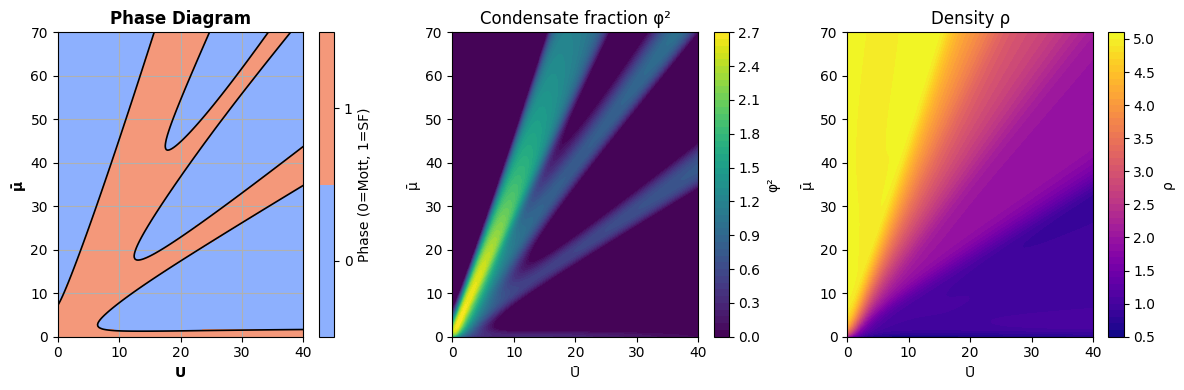

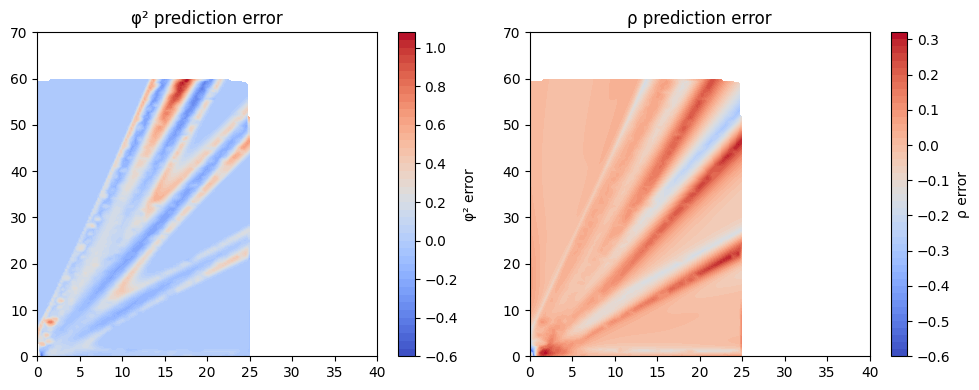

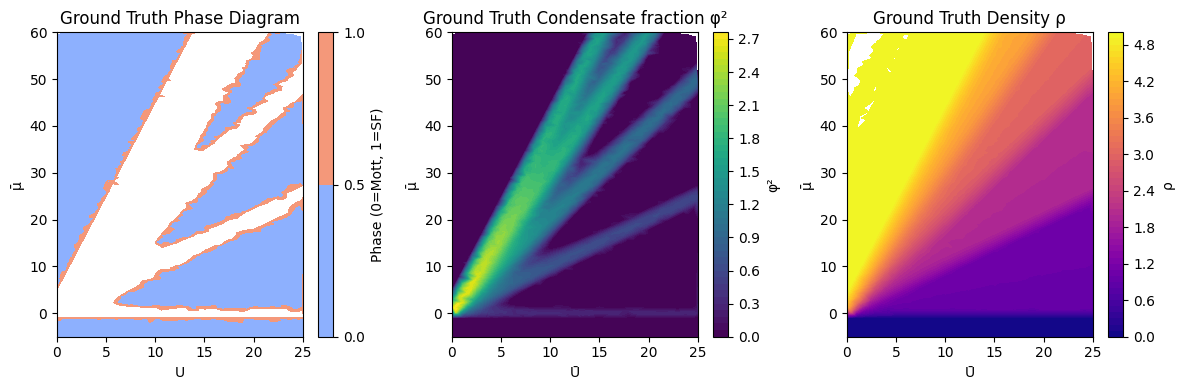


📊 Classification Report (Phase):
              precision    recall  f1-score   support

           0     0.8980    0.9335    0.9154      2000
           1     0.9489    0.9210    0.9348      2684

    accuracy                         0.9263      4684
   macro avg     0.9235    0.9273    0.9251      4684
weighted avg     0.9272    0.9263    0.9265      4684



C:\Users\DELL\AppData\Local\Temp\ipykernel_21340\1770532396.py:428: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_true_labels = df["Phase"].astype(int).ravel()


In [4]:
# Callback to ramp lam_phys in model.loss via attribute; implement as example where model has attribute lam_phys
import tensorflow as tf

class LambdaRamp(tf.keras.callbacks.Callback):
    def __init__(self, start_epoch, end_epoch, final_value):
        self.start = start_epoch
        self.end = end_epoch
        self.final = final_value
    def on_epoch_begin(self, epoch, logs=None):
        if epoch < self.start:
            val = 0.0
        elif epoch >= self.end:
            val = self.final
        else:
            val = (epoch - self.start)/(self.end - self.start) * self.final
        # store in model for your physics loss lambda to read
        setattr(self.model, "lam_phys_current", float(val))
        # optional logging
        print(f"Epoch {epoch}: lam_phys_current={val:.6f}")

# Modify physics loss lambda in compile to read model.lam_phys_current; easiest: implement phys loss using closure that reads model attribute
# Example usage:
ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
# pass ramp_cb to fit callbacks
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from pytorch_tabnet.tab_model import TabNetClassifier


# Label: 1 = Superfluid, 0 = Mott
def label_phase(rho, phi2, tol_rho=1e-3, tol_phi=1e-6):
    """
    Classify phase:
    - Mott insulator if (rho ~ integer) and (phi^2 ~ 0).
    - Superfluid otherwise.
    """
    is_integer_rho = np.isclose(rho, np.round(rho), atol=tol_rho)
    is_zero_phi = phi2 < tol_phi
    
    if is_integer_rho and is_zero_phi:
        return 0  # Mott
    else:
        return 1  # Superfluid

        
# # ---------- 1) Load and label ----------
# df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# # Label: 1 = Superfluid, 0 = Mott
# df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

# # Features and target: **only** Ubar, Mubar
# X = df[["Ubar", "Mubar"]].copy()
# y = df["Phase"].copy()

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.25, random_state=42,
#     stratify=y
# )


# # Apply physics-based labeling
# df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)

# # Features and target: **only** Ubar, Mubar
# X = df[["Ubar", "Mubar"]].copy()
# y = df["Phase"].copy()

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.25, random_state=42,
#     stratify=y
# )

# ---------- 1) Load and label ----------
df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Apply physics-based labeling (optional, but consistent)
df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)




# --- pick deep MI (phi2 ≈ 0, density ~ integer) ---



df_MI = df[
    (df["Phi2"] < 1e-8) &
    (np.isclose(df["Density"], np.round(df["Density"]), atol=1e-3))
]

# --- pick deep SF (large phi2) ---
df_SF = df[df["Phi2"] > 1e-2]

# --- pick boundary (ambiguous region) ---
df_boundary = df[
    (df["Phi2"] > 1e-6) & (df["Phi2"] < 1e-2)
]

# ------------------------------
# Smart sampling strategy
# ------------------------------
# n_MI = min(2000, len(df_MI))             # cap deep MI
# n_SF = min(2000, len(df_SF))             # cap deep SF
# n_boundary = min(6000, len(df_boundary)) # oversample boundary

n_MI = min(2000, len(df_MI))
n_SF = min(2000, len(df_SF))
n_boundary = min(4000, len(df_boundary))


df_reduced = pd.concat([
    df_MI.sample(n_MI, random_state=42),
    df_SF.sample(n_SF, random_state=42),
    df_boundary.sample(n_boundary, random_state=42)
])
print(df)
df_reduced = df_reduced.reset_index(drop=True)
# Use reduced dataset
df = df_reduced.reset_index(drop=True)
print(df)


print("Reduced dataset summary:")
print(df_reduced["Phase"].value_counts())

# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")

# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()

# --- 1) Load data ---
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# # Load dataset
# df = reduced_df

print(df)

# Features and targets
X = df[["Ubar","Mubar"]].values.astype(np.float32)
y = {
    "phase": df["Phase"].values.astype(np.float32),
    "phi2": df["Phi2"].values.astype(np.float32),
    "rho": df["Density"].values.astype(np.float32),
}

# --- 2) Train surrogate model ---
def build_surrogate(hidden=(128,64)):
    inp = keras.Input(shape=(2,))
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="relu")(x)
    out = layers.Dense(2, activation="linear")(x)   # [phi2, rho]
    m = keras.Model(inp, out)
    m.compile(optimizer="adam", loss="mse")
    return m

X_surr = df[["Ubar","Mubar"]].values.astype(np.float32)
y_surr = df[["Phi2","Density"]].values.astype(np.float32)

surrogate = build_surrogate()
surrogate.fit(
    X_surr, y_surr,
    epochs=200, batch_size=512,
    validation_split=0.15, verbose=1
)

# Surrogate validation
from sklearn.metrics import mean_squared_error, mean_absolute_error
X_val = X_surr[-500:]   # or better: shuffle and split properly
y_val = y_surr[-500:]
y_pred = surrogate.predict(X_val)
print("Surrogate MSE:", mean_squared_error(y_val, y_pred))
print("Surrogate MAE:", mean_absolute_error(y_val, y_pred))

# parity plot
import matplotlib.pyplot as plt
plt.scatter(y_val[:,0], y_pred[:,0], s=6); plt.xlabel("true phi2"); plt.ylabel("pred phi2"); plt.title("Surrogate phi2 parity")
plt.plot([y_val[:,0].min(), y_val[:,0].max()],[y_val[:,0].min(), y_val[:,0].max()], 'k--'); plt.show()


# Save & reload in new Keras format
surrogate.save("surrogate_phi_rho.keras")
surrogate = keras.models.load_model("surrogate_phi_rho.keras", compile=False)
surrogate.trainable = False   # freeze surrogate

# --- 3) PINN with surrogate residual ---
def make_pinn_with_surrogate(hidden=(128,64), lam_phase=1.0, lam_phys=1.0):
    inp = keras.Input(shape=(2,), name="input")   # [Ubar, Mubar]
    lam_phys_var = tf.Variable(lam_phys, trainable=False, dtype=tf.float32, name="lam_phys")
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="tanh")(x)

    phase_out = layers.Dense(1, activation="sigmoid", name="phase")(x)
    phi_out   = layers.Dense(1, activation="relu", name="phi2")(x)
    rho_out   = layers.Dense(1, activation="relu", name="rho")(x)

    # Physics residual via surrogate
    def phys_residual(inputs):
        UMb, phi_pred = inputs[0], inputs[1]
        s = surrogate(UMb)                  # surrogate predictions [phi2, rho]
        s_phi = tf.expand_dims(s[:, 0], -1) # only phi2
        return phi_pred - s_phi

    phys_out = layers.Lambda(
        lambda t: phys_residual([t[0], t[1]]),
        name="phys_res"
    )([inp, phi_out])

    model = keras.Model(inputs=inp, outputs=[phase_out, phi_out, rho_out, phys_out])

    losses = {
        "phase": "binary_crossentropy",
        "phi2": "mse",
        "rho": "mse",
        "phys_res": lambda y_true, y_pred: lam_phys_var * tf.reduce_mean(tf.square(y_pred))
    }
    loss_weights = {"phase": lam_phase, "phi2": 1.0, "rho": 1.0, "phys_res": 1.0}

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss=losses,
        loss_weights=loss_weights,
        metrics={"phase":"accuracy"}
    )
    model.lam_phys = lam_phys_var
    return model

pinn_surrogate = make_pinn_with_surrogate()

# --- 4) Train PINN ---
y_targets = {
    "phase": df["Phase"].values.reshape(-1,1).astype(np.float32),
    "phi2":  df["Phi2"].values.reshape(-1,1).astype(np.float32),
    "rho":   df["Density"].values.reshape(-1,1).astype(np.float32),
    "phys_res": np.zeros((len(df),1), dtype=np.float32)
}


def mc_predict(model, X, n=50):
    preds = []
    for _ in range(n):
        p = model(X, training=True)  # keep dropout active
        preds.append(p[0].numpy())   # phase output
    preds = np.stack(preds, axis=0)
    return preds.mean(0), preds.std(0)

    
ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
history = pinn_surrogate.fit(
    X, y_targets,
    batch_size=256,
    epochs=200,
    validation_split=0.15,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(patience=8, factor=0.5),ramp_cb
        # keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True)
    ]
)

# --- 5) Phase diagram prediction ---
U_vals = np.linspace(0, 40, 200)   # Ū axis
mu_vals = np.linspace(0, 70, 200)  # μ̄ axis
UU, MU = np.meshgrid(U_vals, mu_vals)
X_grid = np.stack([UU.ravel(), MU.ravel()], axis=1).astype(np.float32)

# Predict → 4 outputs
y_pred_grid = pinn_surrogate.predict(X_grid, verbose=0)
phase_pred, phi2_pred, rho_pred, _ = y_pred_grid

phase_pred = phase_pred.reshape(UU.shape)
phi2_pred  = phi2_pred.reshape(UU.shape)
rho_pred   = rho_pred.reshape(UU.shape)
phase_pred_class = (phase_pred > 0.5).astype(int)

plt.figure(figsize=(12,4))

# --- Phase diagram ---
plt.subplot(1,3,1)
mappable = plt.contourf(UU, MU, phase_pred_class,
                        levels=[-0.5, 0.5, 1.5], cmap="coolwarm")
plt.colorbar(mappable, ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
plt.contour(UU, MU, phase_pred, levels=[0.5], colors="k", linewidths=1.2)  # phase boundary
plt.xlabel("U",fontsize=10,fontweight="bold")
plt.ylabel("μ̄",fontsize=10, fontweight="bold")
plt.title("Phase Diagram",fontsize=12, fontweight="bold")
plt.grid(True)
plt.savefig('4k-extra-Pinn-keras-pred', dpi=300, bbox_inches='tight')

# --- φ² diagram ---
plt.subplot(1,3,2)
mappable = plt.contourf(UU, MU, phi2_pred, 50, cmap="viridis")
plt.colorbar(mappable, label="φ²")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Condensate fraction φ²")

# --- ρ diagram ---
plt.subplot(1,3,3)
mappable = plt.contourf(UU, MU, rho_pred, 50, cmap="plasma")
plt.colorbar(mappable, label="ρ")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Density ρ")

plt.tight_layout()
plt.show()

from scipy.interpolate import griddata

# Ground truth values
points = df[["Ubar","Mubar"]].values
phi2_true_interp = griddata(points, df["Phi2"].values, (UU, MU), method="linear")
rho_true_interp  = griddata(points, df["Density"].values, (UU, MU), method="linear")

# Compute errors on grid
phi2_err = phi2_pred - phi2_true_interp
rho_err  = rho_pred - rho_true_interp

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.contourf(UU, MU, phi2_err, 50, cmap="coolwarm")
plt.colorbar(label="φ² error")
plt.title("φ² prediction error")

plt.subplot(1,2,2)
plt.contourf(UU, MU, rho_err, 50, cmap="coolwarm")
plt.colorbar(label="ρ error")
plt.title("ρ prediction error")
plt.tight_layout(); plt.show()



# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("U")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")


# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()


# --- 6) Classification report ---
y_pred_phase, y_pred_phi2, y_pred_rho, _ = pinn_surrogate.predict(X, verbose=0)
y_pred_labels = (y_pred_phase > 0.5).astype(int).ravel()
y_true_labels = df["Phase"].astype(int).ravel()

print("\n📊 Classification Report (Phase):")
print(classification_report(y_true_labels, y_pred_labels, digits=4))

